In [302]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as datetime
import statistics as stat
!pip install kmodes
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import OneHotEncoder

In [303]:
#Download data set (originally downloaded from Toronto Open Data website in January 2020).

fire_data = pd.read_csv('https://raw.githubusercontent.com/terrygitersos/CKME136/master/Data/Original%20Fire%20Incidents%20Data.csv')

In [304]:
#Create class attribute, human_risk

fire_data['human_risk'] = np.where((fire_data.Civilian_Casualties > 0) | (fire_data.Count_of_Persons_Rescued > 0) | (fire_data.TFS_Firefighter_Casualties > 0), 1, 0)
fire_data.human_risk = fire_data.human_risk.astype('category')

print(fire_data['human_risk'].value_counts())

0    11662
1     1025
Name: human_risk, dtype: int64


In [305]:
fire_data.info()

fire_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12687 entries, 0 to 12686
Data columns (total 44 columns):
 #   Column                                                         Non-Null Count  Dtype   
---  ------                                                         --------------  -----   
 0   _id                                                            12687 non-null  int64   
 1   Area_of_Origin                                                 12687 non-null  object  
 2   Building_Status                                                9205 non-null   object  
 3   Business_Impact                                                9203 non-null   object  
 4   Civilian_Casualties                                            12687 non-null  int64   
 5   Count_of_Persons_Rescued                                       12687 non-null  int64   
 6   Estimated_Dollar_Loss                                          12686 non-null  float64 
 7   Estimated_Number_Of_Persons_Displaced            

,_id,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Number_of_responding_apparatus,Number_of_responding_personnel,TFS_Firefighter_Casualties
count,12687.000000,12687.000000,12687.000000,1.268600e+04,9204.000000,279.000000,12687.000000,12613.000000,12686.000000,12686.000000,12687.000000,12687.000000,12687.000000
mean,346271.000000,0.082604,0.039253,3.044486e+04,16.799652,1.612903,286.324269,21.047729,43.708331,-79.406279,7.389296,24.411997,0.017341
std,3662.565767,0.398586,0.380062,2.269139e+05,117.160897,1.025210,110.616508,12.301572,0.052580,0.105077,7.914590,24.268019,0.162790
min,339928.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,111.000000,1.000000,43.588660,-79.636530,1.000000,1.000000,0.000000
25%,343099.500000,0.000000,0.000000,3.000000e+02,0.000000,1.000000,212.000000,10.000000,43.663663,-79.488660,4.000000,14.000000,0.000000
50%,346271.000000,0.000000,0.000000,2.500000e+03,0.000000,1.000000,314.000000,20.000000,43.702620,-79.408450,6.000000,21.000000,0.000000
75%,349442.500000,0.000000,0.000000,1.200000e+04,1.000000,2.000000,411.000000,30.000000,43.752070,-79.337150,8.000000,29.000000,0.000000
max,352614.000000,15.000000,16.000000,1.300000e+07,999.000000,7.000000,445.000000,44.000000,43.848190,-79.124410,436.000000,1275.000000,4.000000


What jumps out immediately are that the majority of these attributes are not numeric, and that some attributes have quite a bit of missing data.

In [306]:
#_id
#Definition: unique, numeric row identifier for the City of Toronto’s Open Data database. This attribute has no relevance to the research question, and can be removed.
del fire_data['_id']

0
count                            12687
unique                              72
top       24 - Cooking Area or Kitchen
freq                              2413
Name: Area_of_Origin, dtype: object
Index(['Building services/Support Facilities', 'Functional Area',
       'Means of Egress', 'Miscellaneous', 'Outside Area', 'Storage Area',
       'Structural Area', 'Vehicle Areas'],
      dtype='object')


Functional Area                         0.365413
Vehicle Areas                           0.198313
Storage Area                            0.115867
Structural Area                         0.106960
Outside Area                            0.088831
Miscellaneous                           0.054308
Building services/Support Facilities    0.052652
Means of Egress                         0.017656
Name: Area_of_Origin, dtype: float64

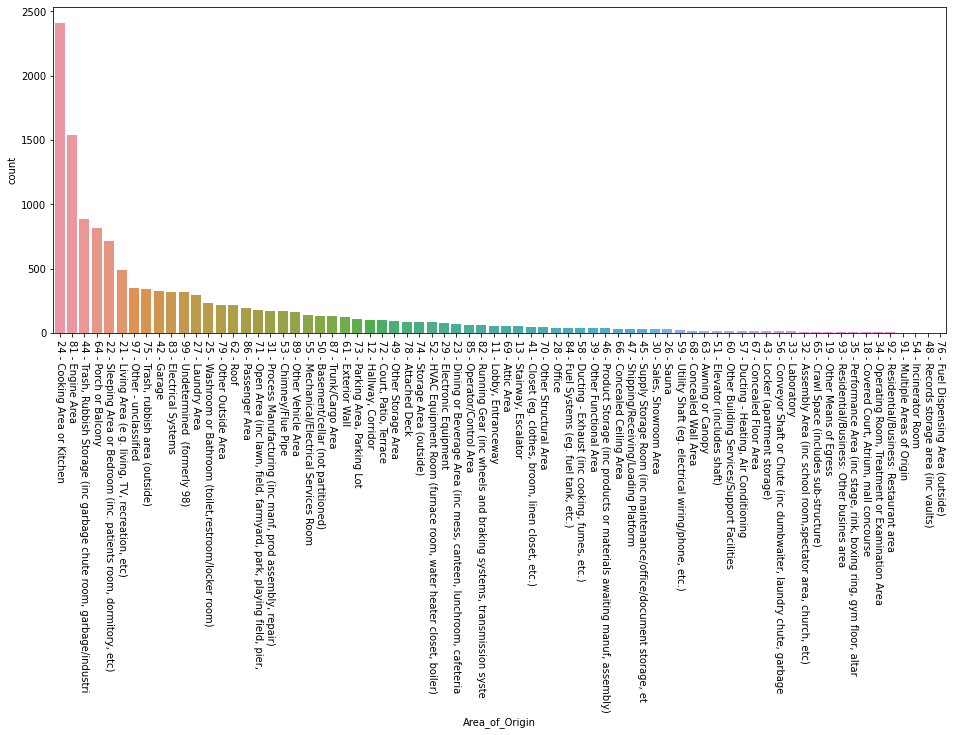

In [307]:
#Area_of_Origin
#Definiton: A code and description assigned to the fire incident by the Ontario Fire Marshal (OFM). It describes the area of the structure where the fire occurred.

print(fire_data['Area_of_Origin'].isna().sum())
print(fire_data['Area_of_Origin'].describe())

#With only 72 unique values, this attribute contains categorical data instead of character data.

plt.figure(figsize=(16, 6))
sns.countplot(x='Area_of_Origin', data=fire_data, order = fire_data['Area_of_Origin'].value_counts().index)
plt.xticks(rotation=-90)

fire_data['Area_of_Origin'].value_counts(normalize = True, dropna = False)
#There is great variance among the different levels of this data, which the most common level ("Cooking Area or Kitchen") making up 19% of the data, and the least common levels appearing to make up just a handful of examples.

#High cardinality can present significant problems for machine learning algoritms in terms of dimensionality and computing resources, so it is best to group the levels together where possible. Luckily in this case, the Ontario Fire Marshal has already grouped their codes together for this attribute and several others in this dataset. You can find a document with these groups here: https://collections.ola.org/mon/2000/10298759.pdf. Grouping together the codes as specified would reduce the cardinality for this particular attribute from 72 levels to a much more manageable 8.

AOE_dict = {'Means of Egress': ['11 - Lobby, Entranceway', 
                                '12 - Hallway, Corridor', 
                                '13 - Stairway, Escalator', 
                                '18 - Covered Court, Atrium, mall concourse', 
                                '19 - Other Means of Egress'],
            'Functional Area': ['21 - Living Area (e.g. living, TV, recreation, etc)',
                                '22 - Sleeping Area or Bedroom (inc. patients room, dormitory, etc)',
                                '23 - Dining or Beverage Area (inc mess, canteen, lunchroom, cafeteria',
                                '24 - Cooking Area or Kitchen',
                                '25 - Washroom or Bathroom (toilet,restroom/locker room)', 
                                '26 - Sauna', 
                                '27 - Laundry Area', 
                                '28 - Office', 
                                '29 - Electronic Equipment', 
                                '30 - Sales, Showroom Area', 
                                '31 - Process Manufacturing (inc manf, prod assembly, repair)', 
                                '32 - Assembly Area (inc school room,spectator area, church, etc)', 
                                '33 - Laboratory', 
                                '34 - Operating Room, Treatment or Examination Area', 
                                '35 - Performance Area (inc stage, rink, boxing ring, gym floor, altar', 
                                '39 - Other Functional Area'],
            'Storage Area': ['41 - Closet (eg. clothes, broom, linen closet, etc.)', 
                             '42 - Garage', 
                             '43 - Locker (apartment storage)', 
                             '44 - Trash, Rubbish Storage (inc garbage chute room, garbage/industri', 
                             '45 - Supply Storage Room (inc maintenance/office/document storage, et', 
                             '46 - Product Storage (inc products or materials awaiting manuf, assembly)', 
                             '47 - Shipping/Receiving/Loading Platform', 
                             '48 - Records storage area (inc vaults)', 
                             '49 - Other Storage Area'],
            'Building services/Support Facilities': ['50 - Basement/cellar (not partitioned)', 
                                                     '51 - Elevator (includes shaft)', 
                                                     '52 - HVAC Equipment Room (furnace room, water heater closet, boiler)', 
                                                     '53 - Chimney/Flue Pipe', 
                                                     '54 - Incinerator Room', 
                                                     '55 - Mechanical/Electrical Services Room', 
                                                     '56 - Conveyor Shaft or Chute (inc dumbwaiter, laundry chute, garbage', 
                                                     '57 - Ducting - Heating, Air Conditioning', 
                                                     '58 - Ducting - Exhaust (inc cooking, fumes, etc.)', 
                                                     '59 - Utility Shaft (eg. electrical wiring/phone, etc.)', 
                                                     '60 - Other Building Services/Support Facilities'],
            'Structural Area': ['61 - Exterior Wall', 
                                '62 - Roof', 
                                '63 - Awning or Canopy', 
                                '64 - Porch or Balcony', 
                                '65 - Crawl Space (includes sub-structure)', 
                                '66 - Concealed Ceiling Area', 
                                '67 - Concealed Floor Area', 
                                '68 - Concealed Wall Area', 
                                '69 - Attic Area', 
                                '70 - Other Structural Area'],
            'Outside Area': ['71 - Open Area (inc lawn, field, farmyard, park, playing field, pier,', 
                             '72 - Court, Patio, Terrace', 
                             '73 - Parking Area, Parking Lot', 
                             '74 - Storage Area (outside)', 
                             '75 - Trash, rubbish area (outside)', 
                             '76 - Fuel Dispensing Area (outside)', 
                             '78 - Attached Deck', 
                             '79 - Other Outside Area'],
            'Vehicle Areas': ['81 - Engine Area', 
                              '82 - Running Gear (inc wheels and braking systems, transmission syste', 
                              '83 - Electrical Systems', 
                              '84 - Fuel Systems (eg. fuel tank, etc.)', 
                              '85 - Operator/Control Area', 
                              '86 - Passenger Area', 
                              '87 - Trunk/Cargo Area', 
                              '89 - Other Vehicle Area'],
            'Miscellaneous': ['91 - Multiple Areas of Origin', 
                              '92 - Residential/Business: Restaurant area', 
                              '93 - Residential/Business: Other busines area', 
                              '97 - Other - unclassified', 
                              '99 - Undetermined  (formerly 98)']}
AOE_dict_2 = {v: k for k, vv in AOE_dict.items() for v in vv}
AOE_dict_2
fire_data.Area_of_Origin = fire_data.Area_of_Origin.map(AOE_dict_2)

#Converting attribute to category:
fire_data['Area_of_Origin'] = fire_data['Area_of_Origin'].astype('category')
print (fire_data['Area_of_Origin'].cat.categories)
fire_data.Area_of_Origin.value_counts(normalize = True, dropna = False)

#Having reduced the cardinality of the attribute the most common level is now Functional Area, which makes up 36.5% of the observations.

count                        9205
unique                          7
top       01 - Normal (no change)
freq                         8063
Name: Building_Status, dtype: object
01 - Normal (no change)               0.635532
NaN                                   0.274454
08 - Not Applicable                   0.040435
02 - Under Renovation                 0.031686
03 - Under Construction               0.009222
09 - Undetermined                     0.004572
05 - Abandoned, vacant (long term)    0.003074
04 - Under Demolition                 0.001025
Name: Building_Status, dtype: float64
Index(['01 - Normal (no change)', '02 - Under Renovation',
       '03 - Under Construction', '04 - Under Demolition',
       '05 - Abandoned, vacant (long term)', '08 - Not Applicable',
       '09 - Undetermined', 'Missing'],
      dtype='object')


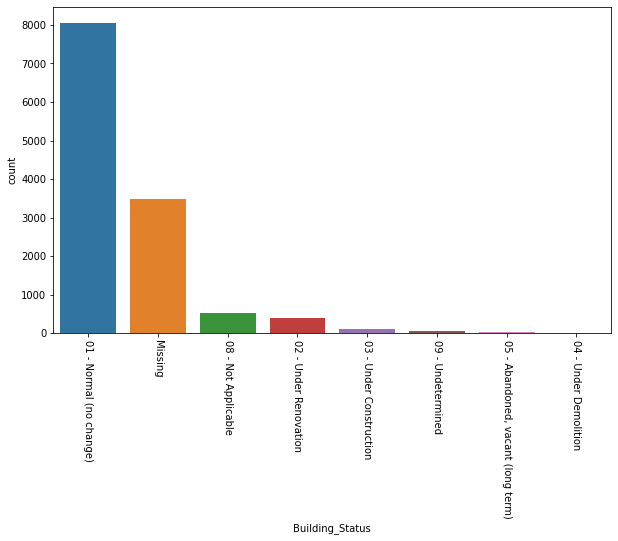

In [308]:
#Building_Status
#Definition: A code and description assigned to the building by the OFM. It describes the state of the building where the fire occurred.

print(fire_data.Building_Status.describe())
print(fire_data.Building_Status.value_counts(normalize = True, dropna = False))

#This a categorical attribute containing nominal data. There are 7 levels.
#63.6% fires occurred in buildings declared "normal" by the OFM. 
#27.4% of the observations are missing data. Rather than risk data loss by imputing new values for the missing data, I will create an eighth level, "Missing", to flag that the data is missing.

fire_data.Building_Status = fire_data.Building_Status.fillna('Missing')

plt.figure(figsize=(10, 6))
sns.countplot(x='Building_Status', data=fire_data, order = fire_data.Building_Status.value_counts().index)
plt.xticks(rotation=-90)

#Converting attribute to category:
fire_data.Building_Status = fire_data.Building_Status.astype('category')
print (fire_data.Building_Status.cat.categories)

In [309]:
#Business_Impact
#Definition: A code and description assigned by the OFM to the business impact caused by the fire. 
#This value is determined only after the fire has been extinguished and fully investigated, so it has no relevance to the research question and can be removed.
del fire_data['Business_Impact']

In [310]:
#Civilian_Casualties
#Definition: The number of civilian deaths caused by the fire. 
#This is one of the attributes from which the class attribute was derived, so has become redundant with its information contained in the class variable.
del fire_data['Civilian_Casualties']

In [311]:
#Count_of_Persons_Rescued
#Definition: The number of persons rescued from the fire. 
#This is one of the attributes from which the class attribute was derived, so had become redundant with its information contained in the class variable.
del fire_data['Count_of_Persons_Rescued']

In [312]:
#Estimated_Dollar_Loss
#Definition: The estimated damage caused by the fire, measured in dollars. 
#This value is determined only after the fire has been extinguished and fully investigated, so is not relevant to the research question and can be removed.
del fire_data['Estimated_Dollar_Loss']

In [313]:
#Estimated_Number_Of_Persons_Displaced
#This value is determined only after the fire has been extinguished and fully investigated, so is not relevant to the research question and can be removed.
del fire_data['Estimated_Number_Of_Persons_Displaced']

count    279.000000
mean       1.612903
std        1.025210
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        7.000000
Name: Exposures, dtype: float64
NaN    12408
1.0      177
2.0       60
3.0       26
4.0       10
6.0        3
5.0        2
7.0        1
Name: Exposures, dtype: int64
count    12687.000000
mean         0.035469
std          0.281048
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: Exposures, dtype: float64
0.0    0.978009
1.0    0.013951
2.0    0.004729
3.0    0.002049
4.0    0.000788
6.0    0.000236
5.0    0.000158
7.0    0.000079
Name: Exposures, dtype: float64


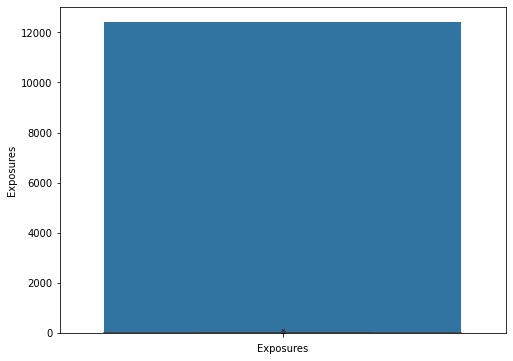

In [314]:
#Exposures
#Definition: Number of exposure fires associated with this fire. An exposure fire refers to secondary fires which are created by a primary fire burning out of control.

print(fire_data.Exposures.describe())
print(fire_data.Exposures.value_counts(dropna = False))

#This is a quantitative attribute with ratio data, with values ranging from 1-7 with 12408 NAs (the vast majority). Rather than missing data, these values are in fact more accurately "0": these are instances in which there were 0 zero exposure fires.

fire_data.Exposures = fire_data.Exposures.fillna(0)

print(fire_data.Exposures.describe())

plt.figure(figsize=(8, 6))
sns.countplot(x='Exposures', data=fire_data, order = fire_data.Exposures.value_counts().index)
plt.xticks(rotation=-90)

print(fire_data.Exposures.value_counts(normalize = True))

#The vast majority of fires - 97.8% - do not cause exposure fires. Unsurprisingly, the median for this attribute is 0, while the mean is 0.35.

sns.boxplot(y="Exposures", data=fire_data)

#All fires resulting in one or more exposures are mathematical outliers. However, there is no indication that these outliers represent incorrect data.

count                   12687
unique                  12679
top       2012-04-18T15:22:10
freq                        2
Name: Ext_agent_app_or_defer_time, dtype: object
0


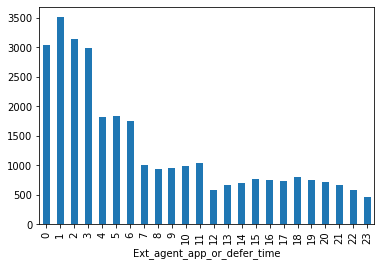

In [315]:
#Ext_agent_app_or_defer_time
#Definition: The date and time at which Toronto Fire Services, at the scene of the fire, determined the course of action required, either spraying water (the "extinguishing agent") at the fire or determining that no application of agent was required ("deferring").

print(fire_data.Ext_agent_app_or_defer_time.describe())

#Attribute was imported as a factor, must convert to a datetime format.

fire_data.Ext_agent_app_or_defer_time = pd.to_datetime(fire_data.Ext_agent_app_or_defer_time)

print(fire_data.Ext_agent_app_or_defer_time.isna().sum())

#This is the first of several related date/time attributes, so I will use this opportunity to do some general analysis about the temporal properties of this data.

fire_data.Ext_agent_app_or_defer_time.groupby(fire_data.Ext_agent_app_or_defer_time.dt.year).count().plot(kind="bar")

#The fires are distributed relatively evenly across the seven years of the data set.

fire_data.Ext_agent_app_or_defer_time.groupby(fire_data.Ext_agent_app_or_defer_time.dt.month).count().plot(kind="bar")

#There is noticeable variance from month, suggesting that fires may occur more frequently during some particular times of year.

fire_data.Ext_agent_app_or_defer_time.groupby(fire_data.Ext_agent_app_or_defer_time.dt.quarter).count().plot(kind="bar")

#Plotting the data by quarters shows that there are more fires during the warmer months (April-September) than in the colder months (October-March)

fire_data.Ext_agent_app_or_defer_time.groupby(fire_data.Ext_agent_app_or_defer_time.dt.hour).count().plot(kind="bar")

#Plotting the data by hour shows that fires vary by time of day. Generally speaking, the least number of fires occur in the morning, while the most dense concentration occurs between 3 and 8 PM.

count                                 9203
unique                                  12
top       1 - Confined to object of origin
freq                                  4224
Name: Extent_Of_Fire, dtype: object
1 - Confined to object of origin                                                    0.332939
NaN                                                                                 0.274612
2 - Confined to part of room/area of origin                                         0.263892
3 - Spread to entire room of origin                                                 0.031528
4 - Spread beyond room of origin, same floor                                        0.028927
9 - Confined to roof/exterior structure                                             0.022700
7 - Spread to other floors, confined to building                                    0.017498
11 - Spread beyond building of origin, resulted in exposure fire(s)                 0.007882
8 - Entire Structure                            

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text major ticklabel objects>)

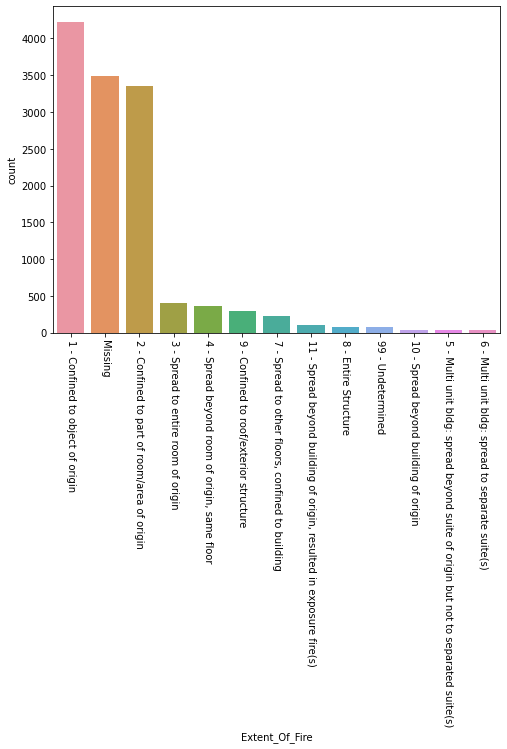

In [316]:
#Extent_Of_Fire
#Definition: A code and description assigned by the OFM to describe the extent of the fire. 

print(fire_data.Extent_Of_Fire.describe())
print(fire_data.Extent_Of_Fire.value_counts(normalize = True, dropna = False))

#This is a categorical attribute with nominal data and 12 levels.
#As with some other attributes that we have encountered, about a quarter (27.5%, to be exact) of the observations are missing. As I have done with other attributes, rather than risking the introduction of bias into my models or data loss, I will create an additional level, "Missing", to flag that the data is missing.

fire_data.Extent_Of_Fire = fire_data.Extent_Of_Fire.fillna('Missing')

#Convert to category data type:

fire_data.Extent_Of_Fire = fire_data.Extent_Of_Fire.astype('category')

plt.figure(figsize=(8, 6))
sns.countplot(x='Extent_Of_Fire', data=fire_data, order = fire_data.Extent_Of_Fire.value_counts().index)
plt.xticks(rotation=-90)


count         12687
unique            2
top       01 - Fire
freq          12594
Name: Final_Incident_Type, dtype: object
01 - Fire                                                            0.99267
02 - Explosion (including during Fire, excluding Codes 3 & 11-13)    0.00733
Name: Final_Incident_Type, dtype: float64


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

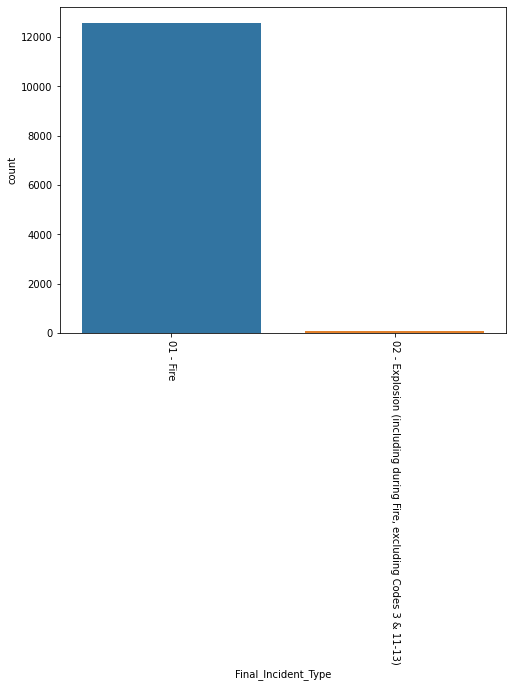

In [317]:
#Final_Incident_Type
#Definition: The final incident type assigned to the fire.

print(fire_data.Final_Incident_Type.describe())
print(fire_data.Final_Incident_Type.value_counts(normalize=True, dropna=False))

#This is a categorical variable with nominal data and 2 levels.
#Convert to category data type:

fire_data.Final_Incident_Type = fire_data.Final_Incident_Type.astype('category')

plt.figure(figsize=(8, 6))
sns.countplot(x='Final_Incident_Type', data=fire_data, order = fire_data.Final_Incident_Type.value_counts().index)
plt.xticks(rotation=-90)

#There are only two categories in this attribute: fire, or explosion. The data is extremely imbalanced: 99.3% of all fire incidents are fires, while 0.7% are explosions.

3484
count                                                  9203
unique                                                    7
top       8 - Not applicable: No fire alarm system, no p...
freq                                                   2545
Name: Fire_Alarm_System_Impact_on_Evacuation, dtype: object
{'7 - Not applicable: Occupant(s) first alerted by other means': 'Not Applicable', '8 - Not applicable: No fire alarm system, no persons present': 'Not Applicable', '1 - All persons (at risk of injury) evacuated as a result of hearing fire alarm system': '1 - All persons (at risk of injury) evacuated as a result of hearing fire alarm system', '9 - Undetermined': '9 - Undetermined', '2 - Some persons (at risk) evacuated as a result of hearing fire alarm system': '2 - Some persons (at risk) evacuated as a result of hearing fire alarm system', '3 - No one (at risk) evacuated as a result of hearing fire alarm system': '3 - No one (at risk) evacuated as a result of hearing fire alarm system'

Not Applicable                                                                            0.368330
Missing                                                                                   0.274612
1 - All persons (at risk of injury) evacuated as a result of hearing fire alarm system    0.128714
9 - Undetermined                                                                          0.104359
2 - Some persons (at risk) evacuated as a result of hearing fire alarm system             0.079688
3 - No one (at risk) evacuated as a result of hearing fire alarm system                   0.041775
4 - Fire Alarm system operated but failed to alert occupant(s)                            0.002522
Name: Fire_Alarm_System_Impact_on_Evacuation, dtype: float64

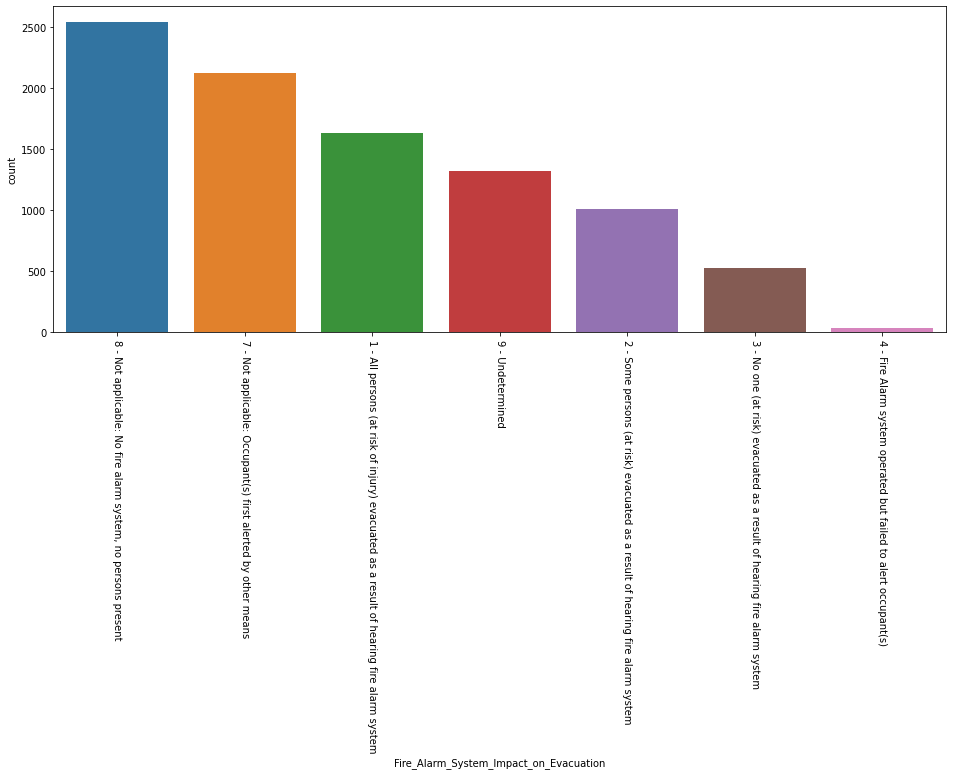

In [318]:
#Fire_Alarm_System_Impact_on_Evacuation
#Definition: A code and description assigned by the OFM to describe the fire alarm system's impact on evacuation.

print(fire_data.Fire_Alarm_System_Impact_on_Evacuation.isna().sum())
print(fire_data.Fire_Alarm_System_Impact_on_Evacuation.describe())

#With only 7 unique values, this attribute contains categorical data instead of character data.

plt.figure(figsize=(16, 6))
sns.countplot(x='Fire_Alarm_System_Impact_on_Evacuation', data=fire_data, order = fire_data.Fire_Alarm_System_Impact_on_Evacuation.value_counts().index)
plt.xticks(rotation=-90)

fire_data.Fire_Alarm_System_Impact_on_Evacuation.value_counts(normalize = True, dropna = False)

#As with some other attributes that we have encountered, about a quarter (27.5%, to be exact) of the observations are missing. As I have done with other attributes, rather than risking the introduction of bias into my models or data loss, I will create an additional level, "Missing", to flag that the data is missing.
fire_data.Fire_Alarm_System_Impact_on_Evacuation = fire_data.Fire_Alarm_System_Impact_on_Evacuation.fillna('Missing')

#Two of the attributes describe not applicable observations. I will combine these levels into one.

FASOE_dict = {'Not Applicable': ['7 - Not applicable: Occupant(s) first alerted by other means', 
                                 '8 - Not applicable: No fire alarm system, no persons present'],
              '1 - All persons (at risk of injury) evacuated as a result of hearing fire alarm system': ['1 - All persons (at risk of injury) evacuated as a result of hearing fire alarm system'], 
              '9 - Undetermined': ['9 - Undetermined'], 
              '2 - Some persons (at risk) evacuated as a result of hearing fire alarm system': ['2 - Some persons (at risk) evacuated as a result of hearing fire alarm system'], 
              '3 - No one (at risk) evacuated as a result of hearing fire alarm system': ['3 - No one (at risk) evacuated as a result of hearing fire alarm system'], 
              '4 - Fire Alarm system operated but failed to alert occupant(s)': ['4 - Fire Alarm system operated but failed to alert occupant(s)'], 
              'Missing': ['Missing']}
FASOE_dict_2 = {v: k for k, vv in FASOE_dict.items() for v in vv}
print(FASOE_dict_2)
fire_data.Fire_Alarm_System_Impact_on_Evacuation = fire_data.Fire_Alarm_System_Impact_on_Evacuation.map(FASOE_dict_2)

#Converting attribute to category:
fire_data.Fire_Alarm_System_Impact_on_Evacuation = fire_data.Fire_Alarm_System_Impact_on_Evacuation.astype('category')
print (fire_data.Fire_Alarm_System_Impact_on_Evacuation.cat.categories)
fire_data.Fire_Alarm_System_Impact_on_Evacuation.value_counts(normalize = True, dropna = False)


count                               9203
unique                                 4
top       1 - Fire alarm system operated
freq                                3656
Name: Fire_Alarm_System_Operation, dtype: object


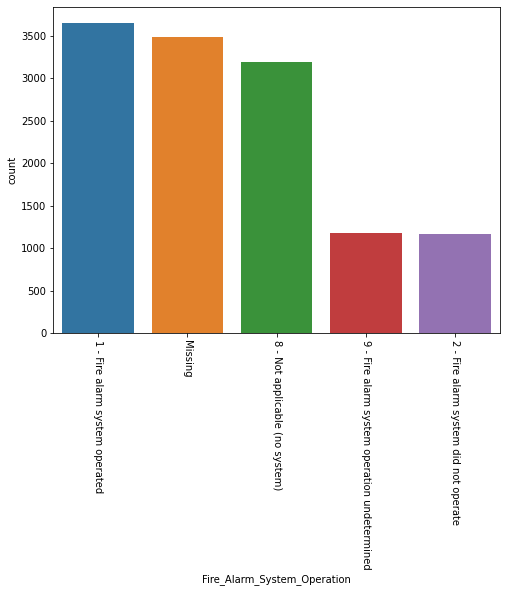

In [319]:
#Fire_Alarm_System_Operation
#Definition: A code and description assigned by the OFM to describe the fire alarm system's operation.

print(fire_data.Fire_Alarm_System_Operation.describe())

#With only 4 unique values, this attribute contains categorical data instead of character data.

fire_data.Fire_Alarm_System_Operation.value_counts(normalize = True, dropna = False)

#As with some other attributes that we have encountered, about a quarter (27.5%, to be exact) of the observations are missing. As I have done with other attributes, rather than risking the introduction of bias into my models or data loss, I will create an additional level, "Missing", to flag that the data is missing.
fire_data.Fire_Alarm_System_Operation = fire_data.Fire_Alarm_System_Operation.fillna('Missing')

plt.figure(figsize=(8, 6))
sns.countplot(x='Fire_Alarm_System_Operation', data=fire_data, order = fire_data.Fire_Alarm_System_Operation.value_counts().index)
plt.xticks(rotation=-90)

#Converting attribute to category:
fire_data.Fire_Alarm_System_Operation = fire_data.Fire_Alarm_System_Operation.astype('category')


count                               9203
unique                                 4
top       1 -  Fire alarm system present
freq                                5073
Name: Fire_Alarm_System_Presence, dtype: object


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

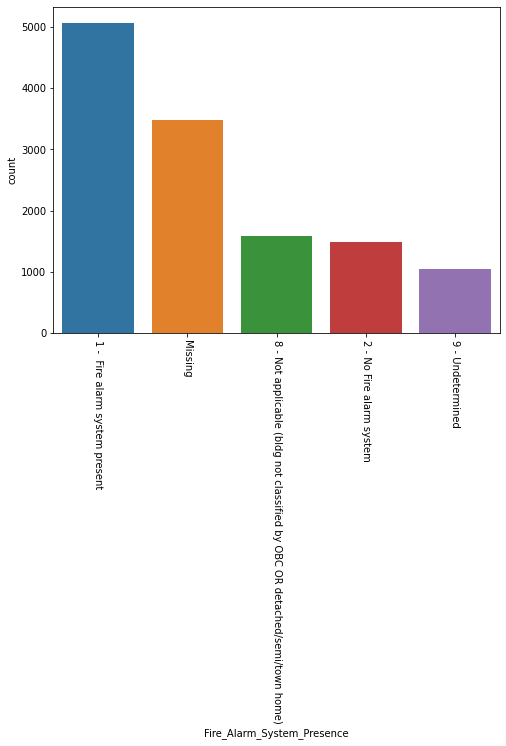

In [320]:
#Fire_Alarm_System_Presence
#Definition: A code and description assigned by the OFM that notes the presence or absence of a fire alarm system.

print(fire_data.Fire_Alarm_System_Presence.describe())

#This is a categorical variable with 4 levels. The levels and their distributions are:

fire_data.Fire_Alarm_System_Presence.value_counts(normalize = True, dropna = False)

#Though the levels are numbers, the numbers do not suggest an order. The data therefore is nominal.

#As with some other attributes that we have already encountered, about a quarter (27.5%, to be exact) of the observations are missing. As I have done with other attributes, rather than risking the introduction of bias into my models or data loss, I will create an additional level, "Missing", to flag that the data is missing.

fire_data.Fire_Alarm_System_Presence = fire_data.Fire_Alarm_System_Presence.fillna('Missing')

#Converting attribute to category dtype:
fire_data.Fire_Alarm_System_Presence = fire_data.Fire_Alarm_System_Presence.astype('category')

plt.figure(figsize=(8, 6))
sns.countplot(x='Fire_Alarm_System_Presence', data=fire_data, order = fire_data.Fire_Alarm_System_Presence.value_counts().index)
plt.xticks(rotation=-90)


In [321]:
#Fire_Under_Control_Time
#Definition: The date and time at which Toronto Fire Services recorded the fire as being under control

fire_data.Fire_Under_Control_Time.dtype

#This attribute was imported as a string, it must be converted to a datetime format.

fire_data.Fire_Under_Control_Time = pd.to_datetime(fire_data.Fire_Under_Control_Time)
print(fire_data.Fire_Under_Control_Time.dtype)

fire_data.Fire_Under_Control_Time.describe()
fire_data.Fire_Under_Control_Time.isna().sum()

#One of the observations is marked not applicable. I will deal with this once I have completed a univariate analysis of all date/time attributes.

print(fire_data.Fire_Under_Control_Time.mean(), fire_data.Ext_agent_app_or_defer_time.mean())
print(fire_data.Fire_Under_Control_Time.quantile(.5), fire_data.Ext_agent_app_or_defer_time.quantile(.5))

#The median and mean of the time when the water began to spray and the time where the fire was declared under control are very close to one another, so plotting this attribute by year, month and hour would yield very similar results as for the Ext_agent_app_or_defer_time attribute. 

datetime64[ns]
2014-06-25 08:57:28.773302016 2014-06-25 08:00:42.499806208
2014-06-09 13:51:43 2014-06-09 11:08:00


object
0
count                  12687
unique                    83
top       999 - Undetermined
freq                    3435
Name: Ignition_Source, dtype: object
999 - Undetermined                                                       0.270750
11 - Stove, Range-top burner                                             0.126113
71 - Smoker's Articles (eg. cigarettes, cigars, pipes already ignited    0.105226
81 - Vehicle - Electrical                                                0.069205
82 - Vehicle - Mechanical                                                0.038386
12 - Oven                                                                0.029164
24 - Circuit Wiring - Copper                                             0.022385
43 - Clothes Dryer                                                       0.018759
55 - Candle                                                              0.017577
98 - Other                                                               0.016158
28 - Cord, Cable f

CategoricalDtype(categories=['Appliances', 'Cooking Equipment',
                  'Electrical distribution equipment',
                  'Heating equipment, chimney etc.', 'Lighting equipment',
                  'Miscellaneous', 'Open flame tools, smokers' articles',
                  'Other electrical, mechanical', 'Processing equipment',
                  'Undetermined'],
                 ordered=False)

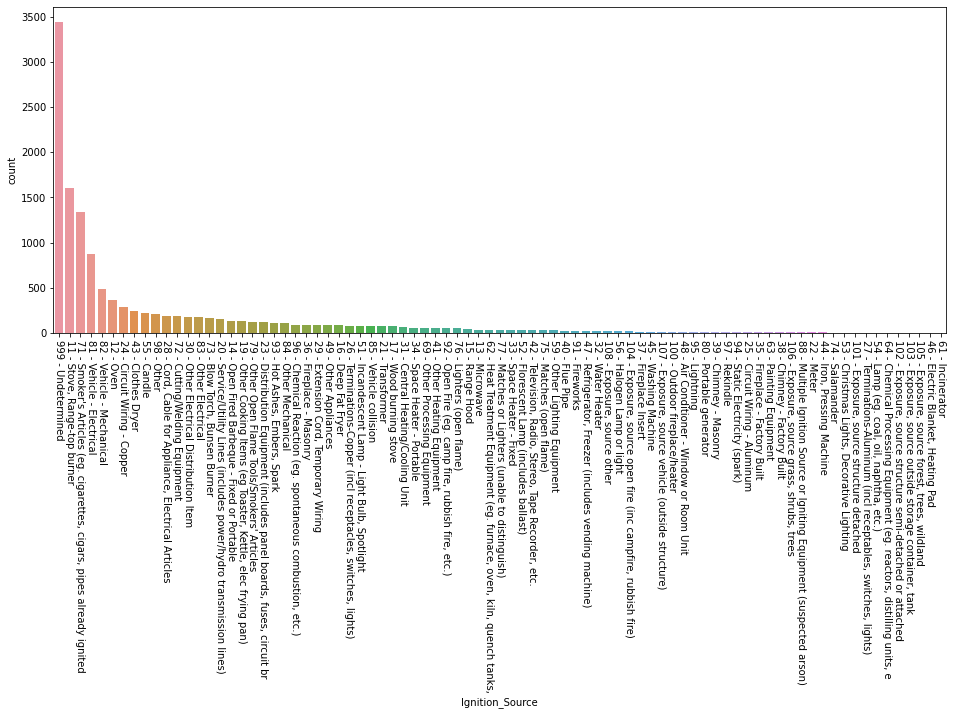

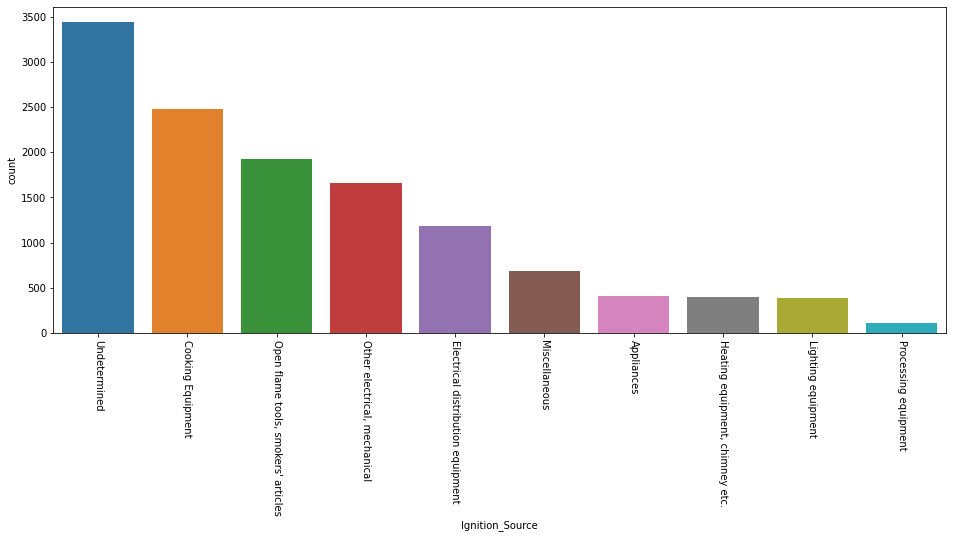

In [322]:
#Ignition_Source
#Definition: A code and description assigned to the fire incident by the Ontario Fire Marshal (OFM). It describes the ignition source of the fire.

print(fire_data.Ignition_Source.dtype)
print(fire_data.Ignition_Source.isna().sum())
print(fire_data.Ignition_Source.describe())
np.unique(fire_data.Ignition_Source)

#Though imported as strings, the data is categorical.
#Though the data is coded with numbers, the numbers do not suggest an order. The data therefore is nominal. 
#There is very high cardinality (83 levels).

plt.figure(figsize=(16, 6))
sns.countplot(x='Ignition_Source', data=fire_data, order = fire_data.Ignition_Source.value_counts().index)
plt.xticks(rotation=-90)

print(fire_data.Ignition_Source.value_counts(normalize = True, dropna = False))

#In 27.1% of cases, the ignition source was undetermined. Only two other levels make up even 10% of the data.

#To reduce cardinality, I will group together the levels as specified in the OFM's Codes List (linked to above). 

Ignition_dict = {'Cooking Equipment': ['11 - Stove, Range-top burner', 
                                       '12 - Oven', 
                                       '13 - Microwave', 
                                       '14 - Open Fired Barbeque - Fixed or Portable', 
                                       '15 - Range Hood', '16 - Deep Fat Fryer', 
                                       '17 - Wood burning stove', 
                                       '19 - Other Cooking Items (eg Toaster, Kettle, elec frying pan)'],
                 'Electrical distribution equipment': ['20 - Service/Utility Lines (includes power/hydro transmission lines)', 
                                                       '21 - Transformer', 
                                                       '22 - Meter', 
                                                       '23 - Distribution Equipment (includes panel boards, fuses, circuit br', 
                                                       '24 - Circuit Wiring - Copper', 
                                                       '25 - Circuit Wiring - Aluminum', 
                                                       '26 - Terminations-Copper (incl receptacles, switches, lights)', 
                                                       '27 - Terminations-Aluminum (incl receptables, switches, lights)', 
                                                       '28 - Cord, Cable for Appliance, Electrical Articles', 
                                                       '29 - Extension Cord, Temporary Wiring', 
                                                       '30 - Other Electrical Distribution Item'],
                 'Heating equipment, chimney etc.': ['31 - Central Heating/Cooling Unit', 
                                                     '32 - Water Heater', 
                                                     '33 - Space Heater - Fixed', 
                                                     '34 - Space Heater - Portable', 
                                                     '35 - Fireplace - Factory Built', 
                                                     '36 - Fireplace - Masonry', 
                                                     '37 - Fireplace Insert', 
                                                     '38 - Chimney - Factory Built', 
                                                     '39 - Chimney - Masonry', 
                                                     '40 - Flue Pipe', 
                                                     '41 - Other Heating Equipment'],
                 'Appliances': ['42 - Television, Radio, Stereo, Tape Recorder, etc.', 
                                '43 - Clothes Dryer', 
                                '44 - Iron, Pressing Machine', 
                                '45 - Washing Machine', 
                                '46 - Electric Blanket, Heating Pad', 
                                '47 - Refrigerator, Freezer (includes vending machine)', 
                                '48 - Air Conditioner - Window or Room Unit', 
                                '49 - Other Appliances'],
                 'Lighting equipment': ['51 - Incandescent Lamp - Light Bulb, Spotlight', 
                                        '52 - Florescent Lamp (includes ballast)', 
                                        '53 - Christmas Lights, Decorative Lighting', 
                                        '54 - Lamp (eg. coal, oil, naphtha, etc.)', 
                                        '55 - Candle', 
                                        '56 - Halogen Lamp or light', 
                                        '59 - Other Lighting Equipment'],
                 'Processing equipment': ['61 - Incinerator', 
                                          '62 - Heat Treatment Equipment (eg. furnace, oven, kiln, quench tanks,', 
                                          '63 - Painting Equipment', 
                                          '64 - Chemical Processing Equipment (eg. reactors, distilling units, e', 
                                          '69 - Other Processing Equipment'],
                 "Open flame tools, smokers' articles": ["71 - Smoker's Articles (eg. cigarettes, cigars, pipes already ignited", 
                                                         '72 - Cutting/Welding Equipment', 
                                                         '73 - Blow Torch, Bunsen Burner', 
                                                         '74 - Salamander', 
                                                         '75 - Matches (open flame)', 
                                                         '76 - Lighters (open flame)', 
                                                         '77 - Matches or Lighters (unable to distinguish)', 
                                                         "79 - Other Open Flame Tools/Smokers' Articles"],
                 'Other electrical, mechanical': ['80 - Portable generator', 
                                                  '81 - Vehicle - Electrical', 
                                                  '82 - Vehicle - Mechanical', 
                                                  '83 - Other Electrical', 
                                                  '84 - Other Mechanical'],
                 'Miscellaneous': ['85 - Vehicle collision', 
                                   '88 - Multiple Ignition Source or Igniting Equipment (suspected arson)', 
                                   '91 - Fireworks', 
                                   '92 - Open Fire (eg. camp fire, rubbish fire, etc.)', 
                                   '93 - Hot Ashes, Embers, Spark', 
                                   '94 - Static Electricity (spark)', 
                                   '95 - Lightning', 
                                   '96 - Chemical Reaction (eg. spontaneous combustion, etc.)', 
                                   '97 - Rekindle', 
                                   '98 - Other', 
                                   '100 - Outdoor fireplace/heater', 
                                   '101 - Exposure, source structure detached', 
                                   '102 - Exposure, source structure semi-detached or attached', 
                                   '103 - Exposure, source outside storage container, tank', 
                                   '104 - Exposure, source open fire (inc campfire, rubbish fire)', 
                                   '105 - Exposure, source forest, trees, wildland', 
                                   '106 - Exposure, source grass, shrubs, trees', 
                                   '107 - Exposure, source vehicle (outside structure)', 
                                   '108 - Exposure, source other'],
                 'Undetermined': ['999 - Undetermined']}
Ignition_dict_2 = {v: k for k, vv in Ignition_dict.items() for v in vv}
fire_data.Ignition_Source = fire_data.Ignition_Source.map(Ignition_dict_2)

plt.figure(figsize=(16, 6))
sns.countplot(x='Ignition_Source', data=fire_data, order = fire_data.Ignition_Source.value_counts().index)
plt.xticks(rotation=-90)

print(fire_data.Ignition_Source.value_counts(normalize = True, dropna = False))

#The attribute now has 10 levels. Other than Undetermined, the most common level is Cooking Equipment, which makes up 19.5% of observations.

#Converting attribute to category dtype:
fire_data.Ignition_Source = fire_data.Ignition_Source.astype('category')
fire_data.Ignition_Source.dtype

In [323]:
#Incident_Number
#Definition: this is the unique identifier assigned to the fire incident by Toronto Fire Services.
#This attribute has no relevance to my research question, so can be removed.
del fire_data['Incident_Number']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]),
 <a list of 84 Text major ticklabel objects>)

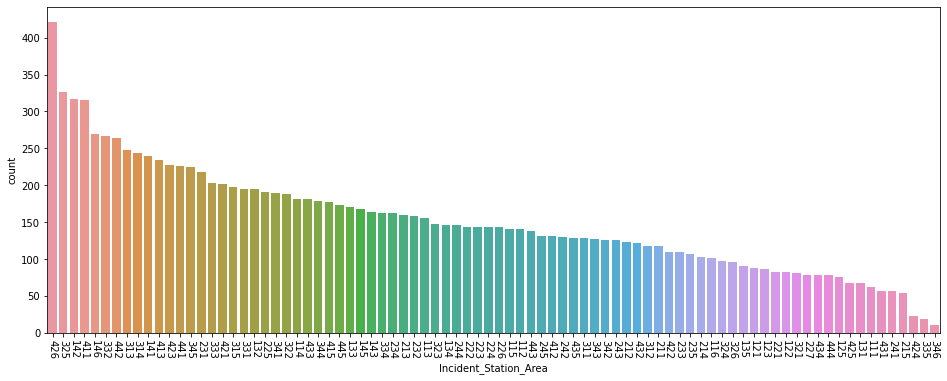

In [324]:
#Incident_Station_Area
#Definition: This refers to the TFS Fire Station closest to where the fire occurred.

fire_data.Incident_Station_Area.describe()

#This is not a true numeric attribute, as it's not used for counting or measurement. It is instead a categorical attribute with nominal data, so I will convert it to a category dtype.

fire_data.Incident_Station_Area = fire_data.Incident_Station_Area.astype('category')
fire_data.Incident_Station_Area.dtype

plt.figure(figsize=(16, 6))
sns.countplot(x='Incident_Station_Area', data=fire_data, order = fire_data.Incident_Station_Area.value_counts().index)
plt.xticks(rotation=-90)

#Fires appear more likely to occur closer to some fire station than others. The station around which the most fires occurred is #426, located on Lansdowne Avenue north of Queen street West.

count    12613.000000
mean        21.047729
std         12.301572
min          1.000000
25%         10.000000
50%         20.000000
75%         30.000000
max         44.000000
Name: Incident_Ward, dtype: float64
category
74
      Incident_Ward                                       Intersection
2               NaN                                  HWY 401 / HWY 401
169             NaN                  Renforth Dr / Renforth 427 S Ramp
455             NaN                        Steeles Ave W / Norfinch Dr
726             NaN                  407 427 S Ramp / 407 W 427 S Ramp
753             NaN                        Steeles Ave W / Rossdean Dr
758             NaN                  Renforth Dr / Renforth 427 S Ramp
814             NaN                  Renforth Dr / Renforth 427 S Ramp
837             NaN                  Renforth Dr / Renforth 427 S Ramp
929             NaN                        HWY 427 / 427 N Fasken Ramp
968             NaN                        Steeles Ave W / Norfinc

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text major ticklabel objects>)

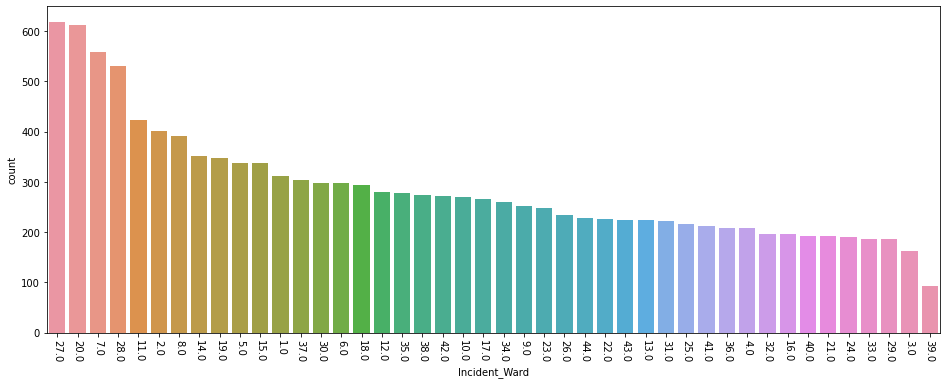

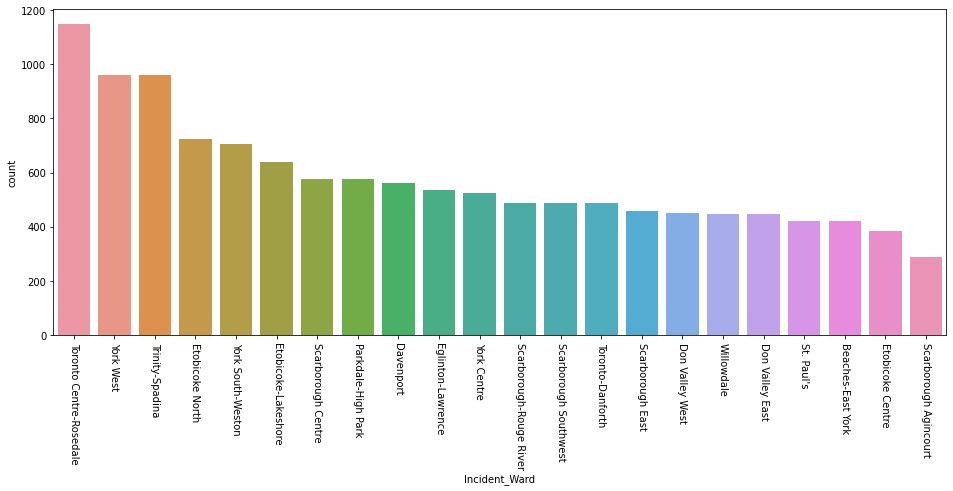

In [325]:
#Incident_Ward
#Definition: This is the municipal ward number in which the fire occurred. Note that these numbers reflect the old 44-ward system, NOT the new 25-ward system.
print(fire_data.Incident_Ward.describe())

#This is not a true numeric field, as it's not used for counting or measurement. It is instead a categorical variable with nominal data, so I will convert it to a category dtype.

fire_data.Incident_Ward = fire_data.Incident_Ward.astype('category')
print(fire_data.Incident_Ward.dtype)

plt.figure(figsize=(16, 6))
sns.countplot(x='Incident_Ward', data=fire_data, order = fire_data.Incident_Ward.value_counts().index)
plt.xticks(rotation=-90)

#As we saw with the Incident_Station_Area attribute, there is geographical variance in the number of fires. It certainly appears that fires may be more likely to occur in some parts of the city than others.

print(fire_data.Incident_Ward.isna().sum())
pd.set_option('display.max_rows', None)
print(fire_data[['Incident_Ward', 'Intersection']][fire_data.Incident_Ward.isna()])

#Looking at the 74 records that are NA, it appears that many of these fires occurred on highways (which are not part of any municipal wards), or occurred on or close to boundary streets such as Steeles Avenue (the north side of which is technically not part of the City of Toronto but which apparently still is serviced by TFS). In all cases, approximate ward can easily be found on Google Maps using longitude and latitude. I used the following map: https://www.google.com/maps/d/viewer?vpsrc=0&ctz=300&ie=UTF8&t=h&oe=UTF8&msa=0&mid=1GVzAjujA652hcRVy7TdHpWwDM3Y&ll=43.80021317824236%2C-79.14074482543947&z=15

print(fire_data[['Incident_Ward', 'Latitude', 'Longitude']][fire_data.Incident_Ward.isna()])
#One missing observation lacks longitude and latitude, so the Ward was derived from the location of the responding fire station.

fire_data.loc[[726, 2595, 3883, 4795, 5211, 6110], ['Incident_Ward']] = 1.0
fire_data.loc[[929, 3535, 4336, 6060], ['Incident_Ward']] = 2.0
fire_data.loc[[169, 758, 814, 837, 2512, 2624, 2744, 3064, 4341, 7003, 8194, 8600], ['Incident_Ward']] = 3.0
fire_data.loc[[7062, 7079], ['Incident_Ward']] = 5.0
fire_data.loc[[1674, 5410], ['Incident_Ward']] = 6.0
fire_data.loc[[753, 1142, 2375, 4555, 6057, 12024], ['Incident_Ward']] = 7.0
fire_data.loc[[455, 968, 1040, 2623, 3459, 8917], ['Incident_Ward']] = 8.0
fire_data.loc[[1455, 6425, 7215, 9696], ['Incident_Ward']] = 10.0
fire_data.loc[[6737, 10751], ['Incident_Ward']] = 11.0
fire_data.loc[[1700], ['Incident_Ward']] = 12.0
fire_data.loc[[3389], ['Incident_Ward']] = 15.0
fire_data.loc[[3631, 4619], ['Incident_Ward']] = 18.0
fire_data.loc[[4040, 4244], ['Incident_Ward']] = 19.0
fire_data.loc[[12005], ['Incident_Ward']] = 22.0
fire_data.loc[[1547, 11850], ['Incident_Ward']] = 23.0
fire_data.loc[[1426, 2980, 3059, 3278, 4502, 6835, 9294, 12091], ['Incident_Ward']] = 24.0
fire_data.loc[[12369], ['Incident_Ward']] = 28.0
fire_data.loc[[1328, 8377], ['Incident_Ward']] = 29.0
fire_data.loc[[8695], ['Incident_Ward']] = 31.0
fire_data.loc[[2846], ['Incident_Ward']] = 32.0
fire_data.loc[[7438], ['Incident_Ward']] = 35.0
fire_data.loc[[4370], ['Incident_Ward']] = 38.0
fire_data.loc[[12200], ['Incident_Ward']] = 39.0
fire_data.loc[[986, 11156], ['Incident_Ward']] = 41.0
fire_data.loc[[2, 3895, 12661], ['Incident_Ward']] = 44.0

print(fire_data.Incident_Ward.isna().sum())

#I can't find any way to convert the 44 pre-2018 municipal wards in this attribute to the new municipal wards established in 2018. However, it is possible to reduce the cardinality of this attribute by combining the pre-2018 municipal wards so that they correspond to the old provincial electoral ridings. For example, Ward 1 and Ward 2 made up the provincial district of Etobicoke North; Ward 3 and Ward 4 made up Etobicoke Centre; Ward 43 and Ward 44 made up Scarborough East, etc. A list of the old municipal wards can be found here: https://www.toronto.ca/city-government/data-research-maps/neighbourhoods-communities/ward-profiles/44-ward-model/

Ward_dict = {'Etobicoke North': [1.0, 2.0], 
             'Etobicoke Centre': [3.0, 4.0], 
             'Etobicoke-Lakeshore': [5.0, 6.0], 
             'York West': [7.0, 8.0], 
             'York Centre': [9.0, 10.0], 
             'York South-Weston': [11.0, 12.0], 
             'Parkdale-High Park': [13.0, 14.0], 
             'Eglinton-Lawrence': [15.0, 16.0], 
             'Davenport': [17.0, 18.0], 
             'Trinity-Spadina': [19.0, 20.0], 
             "St. Paul's": [21.0, 22.0], 
             'Willowdale': [23.0, 24.0], 
             'Don Valley West': [25.0, 26.0], 
             'Toronto Centre-Rosedale': [27.0, 28.0], 
             'Toronto-Danforth': [29.0, 30.0], 
             'Beaches-East York': [31.0, 32.0], 
             'Don Valley East': [33.0, 34.0], 
             'Scarborough Southwest': [35.0, 36.0], 
             'Scarborough Centre': [37.0, 38.0], 
             'Scarborough Agincourt': [39.0, 40.0], 
             'Scarborough-Rouge River': [41.0, 42.0], 
             'Scarborough East': [43.0, 44.0]}

Ward_dict_2 = {v: k for k, vv in Ward_dict.items() for v in vv}
fire_data.Incident_Ward = fire_data.Incident_Ward.map(Ward_dict_2)

print(fire_data.Incident_Ward.describe())
#This categorical attribute now has 22 levels.

#Change attribute back to category dtype:
fire_data.Incident_Ward = fire_data.Incident_Ward.astype('category')
print(fire_data.Incident_Ward.dtype)

plt.figure(figsize=(16, 6))
sns.countplot(x='Incident_Ward', data=fire_data, order = fire_data.Incident_Ward.value_counts().index)
plt.xticks(rotation=-90)
#As we can now see more clearly, fires occur more frequently in some parts of the city. The two parts of the city with the greatest number are located in downtown Toronto: Toronto Centre-Rosedale and Trinity-Spadina.

category


Fire Event Type               0.672342
Vehicle Fire Event            0.180815
Fire Alarm Event Type         0.126192
Vehicle Accident Responses    0.006621
Call Check                    0.006463
Medical Event                 0.001576
Natural Gas Event             0.001498
Hazardous Materials Event     0.001182
Island /BBCCA Events          0.001103
Wires Down                    0.001025
Carbon Monoxide Event         0.000552
Water Problem                 0.000315
Police Assist Event           0.000158
Rescue Event                  0.000079
Lake Events                   0.000079
Name: Initial_CAD_Event_Type, dtype: float64

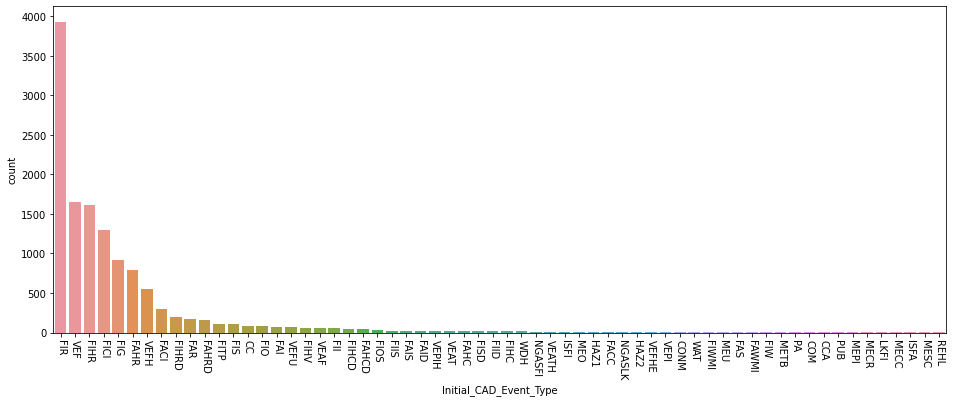

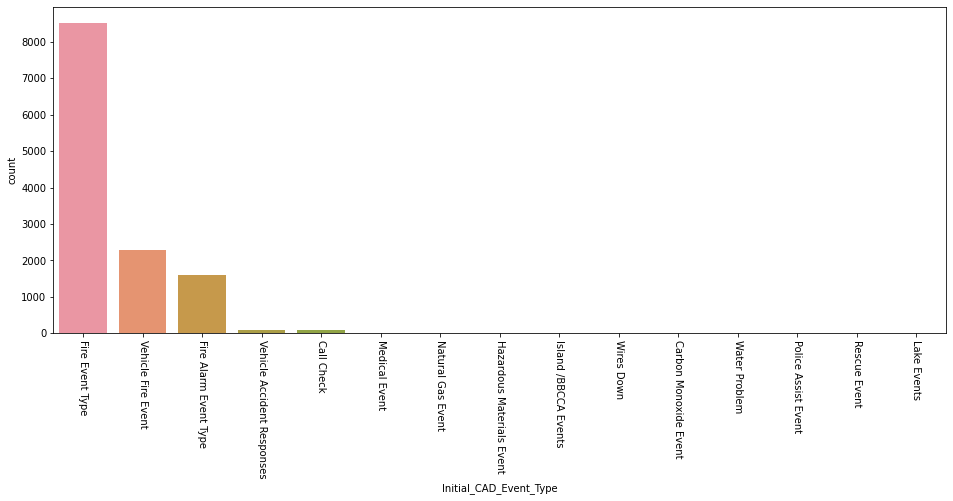

In [326]:
#Initial_CAD_Event_Type
#Definition: The first event type entered in the Computer-Aided Dispatch system for the fire. 

fire_data.Initial_CAD_Event_Type.describe()
fire_data.Initial_CAD_Event_Type.value_counts()
#This is a categorical variable with nominal data and 62 levels.

plt.figure(figsize=(16, 6))
sns.countplot(x='Initial_CAD_Event_Type', data=fire_data, order = fire_data.Initial_CAD_Event_Type.value_counts().index)
plt.xticks(rotation=-90)

#From the plot, three things are apparent at once: the distribution is imbalanced, with almost half the observations consisting of one level ("FIR"); the attribute has very high cardinality; and the levels consist exclusively of alphabetical codes, with no description.
#I was provided a document by Kevin Ku from the City of Toronto that describes these codes and groups them into several clusters. Grouping these codes together as per that document will greatly clarify the data in this attribute, while reducing cardinality.

fire_data.Initial_CAD_Event_Type.unique()

CAD_dict = {'Call Check': ['CC'], 
            'Carbon Monoxide Event': ['COM', 'CONM'], 
            'Fire Alarm Event Type': ['FACC', 'FACI', 'FAHC', 'FAHCD', 'FAHR', 'FAHRD', 'FAI', 'FAID', 'FAIS', 'FAR', 'FAS', 'FAWMI'], 
            'Fire Event Type': ['FICI', 'FIG', 'FIHC', 'FIHCD', 'FIHR', 'FIHRD', 'FIHV', 'FII', 'FIID', 'FIIS', 'FIO', 'FIOS', 'FIR', 'FIS', 'FISD', 'FITP', 'FIW', 'FIWMI'], 
            'Hazardous Materials Event': ['HAZ1', 'HAZ2'], 
            'Island /BBCCA Events': ['CCA', 'ISFA', 'ISFI'], 
            'Lake Events': ['LKFI'], 
            'Medical Event': ['MECC', 'MECR', 'MEO', 'MEPI', 'MESC', 'METB', 'MEU', 'PUB'], 
            'Natural Gas Event': ['NGASFI', 'NGASLK'], 
            'Police Assist Event': ['PA'], 
            'Rescue Event': ['REHL'], 
            'Vehicle Accident Responses': ['VEAF', 'VEAT', 'VEATH'], 
            'Vehicle Fire Event': ['VEF', 'VEFH', 'VEFHE', 'VEFU', 'VEPI', 'VEPIH'], 
            'Water Problem': ['WAT'], 
            'Wires Down': ['WDH']}
CAD_dict_2 = {v: k for k, vv in CAD_dict.items() for v in vv}
fire_data.Initial_CAD_Event_Type = fire_data.Initial_CAD_Event_Type.map(CAD_dict_2)

fire_data.Initial_CAD_Event_Type.describe()
#The attribute has been reduced to 15 levels.

#Change attribute to category dtype:
fire_data.Initial_CAD_Event_Type = fire_data.Initial_CAD_Event_Type.astype('category')
print(fire_data.Initial_CAD_Event_Type.dtype)

plt.figure(figsize=(16, 6))
sns.countplot(x='Initial_CAD_Event_Type', data=fire_data, order = fire_data.Initial_CAD_Event_Type.value_counts().index)
plt.xticks(rotation=-90)

fire_data.Initial_CAD_Event_Type.value_counts(normalize = True, dropna = False)
#The most common level is Fire Event, which makes up 67.2% of the observations.

In [327]:
#Intersection
#Definition: The nearest major or minor intersection in the ward of the incident

fire_data.Intersection.describe()

#There are other attributes that contain more precise geographical information with much lower cardinality, such as station and ward. Additionally, there are attributes for longitude and latitude. The existence of those attributes makes this one redundant, so I will discard it.

del fire_data['Intersection']

In [328]:
#Last_TFS_Unit_Clear_Time
#Definition: The date and time at which the last Toronto Fire Services unit left the scene of the fire.

print(fire_data.Last_TFS_Unit_Clear_Time.describe())

#This attribute was imported as a string, it must be converted to a datetime format.

fire_data.Last_TFS_Unit_Clear_Time = pd.to_datetime(fire_data.Last_TFS_Unit_Clear_Time)
print(fire_data.Last_TFS_Unit_Clear_Time.dtype)

fire_data.Last_TFS_Unit_Clear_Time.describe()
fire_data.Last_TFS_Unit_Clear_Time.isna().sum()

print(fire_data.Fire_Under_Control_Time.mean(), fire_data.Last_TFS_Unit_Clear_Time.mean())
print(fire_data.Fire_Under_Control_Time.quantile(.5), fire_data.Last_TFS_Unit_Clear_Time.quantile(.5))

#Based on the mean and median, the time between the fire being under control and the last TFS unit leaving the scene is very short, so the data distribution by year, month and hour will look essentially similar as for Fire_Under_Control_Time above.

count                   12687
unique                  12687
top       2015-12-15T14:23:06
freq                        1
Name: Last_TFS_Unit_Clear_Time, dtype: object
datetime64[ns]
2014-06-25 08:57:28.773302016 2014-06-25 09:26:50.701744128
2014-06-09 13:51:43 2014-06-09 11:31:19


In [329]:
#Latitude
#Definition: Latitude of nearest major or minor intersection in the ward of the fire incident

fire_data.Latitude.describe()
fire_data.Latitude.isna().sum()

#This is a quantitative, numerical attribute containing ratio data.
#A further analysis of Latitude (along with Longitude) will be conducted in the bivariate analysis section of this project. The missing data in this attribute here will be dealt with below together with longitude.

1

count     9203
unique      58
top        001
freq      3589
Name: Level_Of_Origin, dtype: object
001    0.282888
NaN    0.274612
B01    0.103886
002    0.090171
003    0.041854
999    0.032395
004    0.019626
006    0.015134
005    0.015055
996    0.013084
007    0.011350
997    0.009695
008    0.009459
B02    0.008828
009    0.008119
012    0.007330
010    0.007330
011    0.006148
014    0.004887
015    0.004414
017    0.003862
016    0.003783
998    0.003547
B03    0.002601
018    0.002286
019    0.002207
020    0.002128
021    0.001576
013    0.001419
024    0.001340
023    0.001182
025    0.000946
022    0.000946
027    0.000709
026    0.000552
030    0.000552
B04    0.000552
029    0.000473
028    0.000394
033    0.000236
046    0.000236
037    0.000236
031    0.000158
B07    0.000158
041    0.000158
039    0.000158
034    0.000158
048    0.000158
035    0.000158
047    0.000158
B09    0.000079
054    0.000079
038    0.000079
042    0.000079
036    0.000079
050    0.000079
044    

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

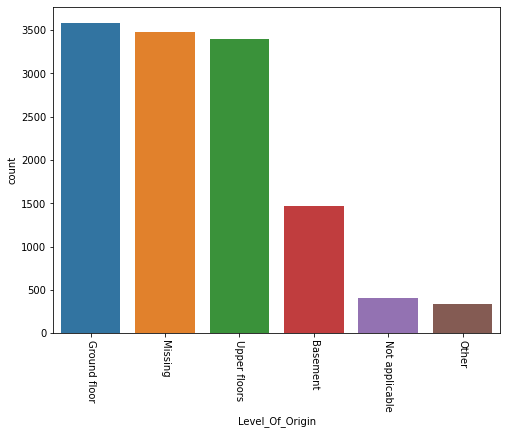

In [330]:
#Level_Of_Origin
#Definition: A code and description given by the OFM to describe the level of the structure where a fire originated.

print(fire_data.Level_Of_Origin.describe())
#This is a categorical attribute with nominal data and 58 levels.

print(fire_data.Level_Of_Origin.value_counts(normalize = True, dropna = False))

#As with some other attributes that we have already encountered, about a quarter (27.5%, to be exact) of the observations are missing. As I have done with other attributes, rather than risking the introduction of bias into my models or data loss, I will create an additional level, "Missing", to flag that the data is missing.
fire_data.Level_Of_Origin = fire_data.Level_Of_Origin.fillna('Missing')

#Codes such as 001, 002, 003... refer to the above ground floor of the structure where the fire originated. Codes such as B01, B02, B03, refer to the basement floors of the structure where the fire originated. Some codes are not described, but I can relabel these levels with the help of the OFM's Codes List.

fire_data.Level_Of_Origin.unique()

Level_dict = {'Ground floor': ['001'], 
              'Upper floors': ['002', '003', '004', '005', '006', '007', '008', '009', '010', 
                               '011', '012', '013', '014', '015', '016', '017', '018', '019', 
                               '020', '021', '022', '023', '024', '025', '026', '027', '028', 
                               '029', '030', '031', '032', '033', '034', '035', '036', '037', 
                               '038', '039', '041', '042', '043', '044', '046', '047', '048', 
                               '050', '054'], 
              'Other': ['996', '997', '998'], 
              'Not applicable': ['999'], 
              'Basement': ['B01', 'B02', 'B03', 'B04', 'B07', 'B09'], 
              'Missing': ['Missing']}
Level_dict_2 = {v: k for k, vv in Level_dict.items() for v in vv}
fire_data.Level_Of_Origin = fire_data.Level_Of_Origin.map(Level_dict_2)

print(fire_data.Level_Of_Origin.describe())
#This attribute how has 6 levels:
print(fire_data.Level_Of_Origin.unique())

#Change attribute to category dtype:
fire_data.Level_Of_Origin = fire_data.Level_Of_Origin.astype('category')
print(fire_data.Level_Of_Origin.dtype)

plt.figure(figsize=(8, 6))
sns.countplot(x='Level_Of_Origin', data=fire_data, order = fire_data.Level_Of_Origin.value_counts().index)
plt.xticks(rotation=-90)

In [331]:
#Longitude
#Definition: Longitude of nearest major or minor intersection in the ward of the fire incident

print(fire_data.Longitude.describe())
#This is a quantitative attribute containing ratio data.

#A further analysis of Longitude (along with Latitude) will be conducted in the bivariate analysis section.

#There is one observation where both Longitude and Latitude is missing.
print(fire_data[['Incident_Station_Area', 'Latitude', 'Longitude']][fire_data.Longitude.isna()])

#I will impute the latitude and longitude of the fire station, which can easily be found using Google Maps.
fire_data.loc[[12661], ['Latitude']] = 43.7941779
fire_data.loc[[12661], ['Longitude']] = -79.1637706
fire_data.loc[[12661], ['Latitude', 'Longitude']]

count    12686.000000
mean       -79.406279
std          0.105077
min        -79.636530
25%        -79.488660
50%        -79.408450
75%        -79.337150
max        -79.124410
Name: Longitude, dtype: float64
      Incident_Station_Area  Latitude  Longitude
12661                   214       NaN        NaN


,Latitude,Longitude
12661,43.794178,-79.163771


Other Objects                     0.302830
Undetermined                      0.151572
Materials                         0.131788
Flammable, combustible liquids    0.112004
Building Component                0.088122
Miscellaneous                     0.084023
Soft goods, wearing apparel       0.064870
Furniture                         0.054229
Gases                             0.010562
Name: Material_First_Ignited, dtype: float64
category


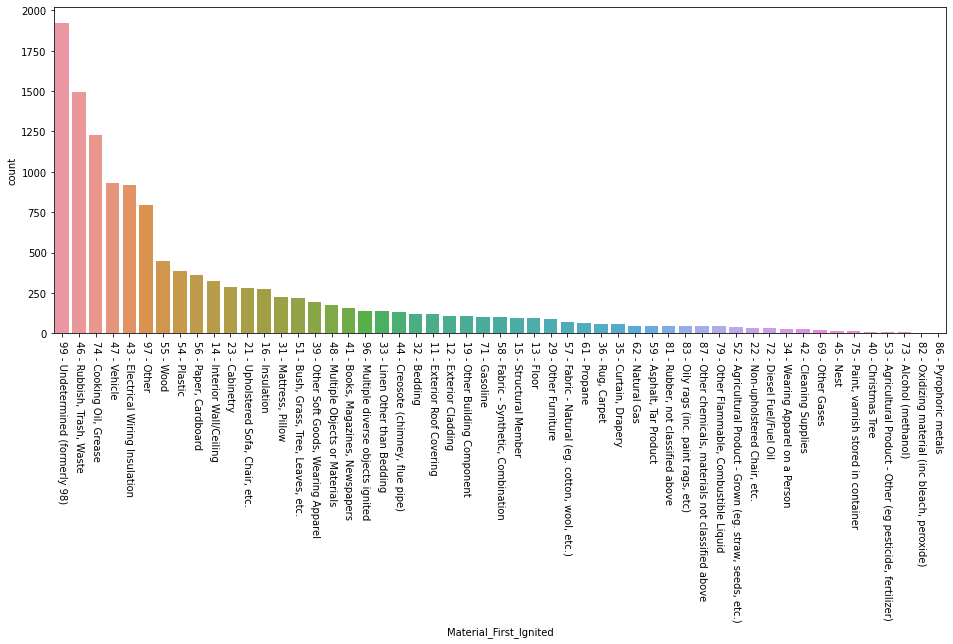

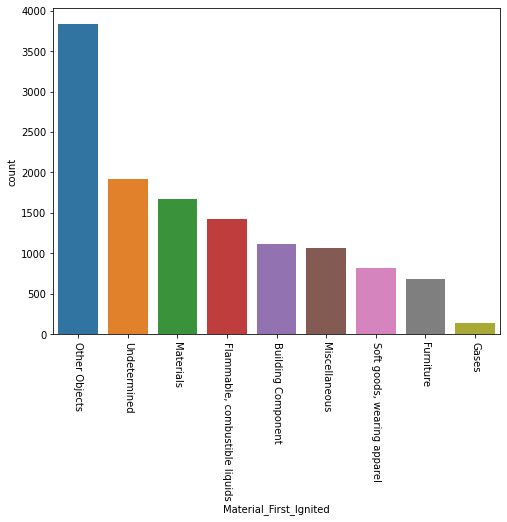

In [332]:
#Material_First_Ignited
#Definition: A code and description assigned to the fire incident by the Ontario Fire Marshal (OFM). It describes the material that was first ignited.
fire_data.Material_First_Ignited.describe()
fire_data.Material_First_Ignited.isna().sum()

#This is a categorical attribute containing nominal data. There are 53 levels:
fire_data.Material_First_Ignited.unique()

plt.figure(figsize=(16, 6))
sns.countplot(x='Material_First_Ignited', data=fire_data, order = fire_data.Material_First_Ignited.value_counts().index)
plt.xticks(rotation=-90)

fire_data.Material_First_Ignited.value_counts(normalize=True)
#There is great variance among the different levels of this attribute, with the most common level ("Undetermined") making up 15.2% of the data, and the least common levels making up a handful of examples.

#The levels in this attribute can be grouped together as per the OFM Codes List, which would significantly reduce the cardinality for this particular attribute from 72 levels.

MFI_dict = {'Building Component': ['11 - Exterior Roof Covering',
                                   '12 - Exterior Cladding', 
                                   '13 - Floor', 
                                   '14 - Interior Wall/Ceiling', 
                                   '15 - Structural Member', 
                                   '16 - Insulation', 
                                   '19 - Other Building Component'], 
            'Furniture': ['21 - Upholstered Sofa, Chair, etc.', 
                          '22 - Non-upholstered Chair, etc.', 
                          '23 - Cabinetry', 
                          '29 - Other Furniture'], 
            'Soft goods, wearing apparel': ['31 - Mattress, Pillow', 
                                            '32 - Bedding', 
                                            '33 - Linen Other than Bedding', 
                                            '34 - Wearing Apparel on a Person', 
                                            '35 - Curtain, Drapery', 
                                            '36 - Rug, Carpet', 
                                            '39 - Other Soft Goods, Wearing Apparel'],
            'Other Objects': ['40 - Christmas Tree', 
                              '41 - Books, Magazines, Newspapers', 
                              '42 - Cleaning Supplies', 
                              '43 - Electrical Wiring Insulation', 
                              '44 - Creosote (chimney, flue pipe)', 
                              '45 - Nest', 
                              '46 - Rubbish, Trash, Waste', 
                              '47 - Vehicle', 
                              '48 - Multiple Objects or Materials'], 
            'Materials': ['51 - Bush, Grass, Tree, Leaves, etc.', 
                          '52 - Agricultural Product - Grown (eg. straw, seeds, etc.)', 
                          '53 - Agricultural Product - Other (eg pesticide, fertilizer)', 
                          '54 - Plastic', 
                          '55 - Wood', 
                          '56 - Paper, Cardboard', 
                          '57 - Fabric - Natural (eg. cotton, wool, etc.)', 
                          '58 - Fabric - Synthetic, Combination', 
                          '59 - Asphalt, Tar Product'], 
            'Gases': ['61 - Propane', 
                      '62 - Natural Gas', 
                      '69 - Other Gases'], 
            'Flammable, combustible liquids': ['71 - Gasoline', 
                                               '72 - Diesel Fuel/Fuel Oil', 
                                               '73 - Alcohol (methanol)', 
                                               '74 - Cooking Oil, Grease', 
                                               '75 - Paint, varnish stored in container', 
                                               '79 - Other Flammable, Combustible Liquid'], 
            'Miscellaneous': ['81 - Rubber, not classified above', 
                              '82 - Oxidizing material (inc bleach, peroxide)', 
                              '83 - Oily rags (inc. paint rags, etc)',  
                              '86 - Pyrophoric metals', 
                              '87 - Other chemicals, materials not classified above', 
                              '96 - Multiple diverse objects ignited', 
                              '97 - Other'], 
            'Undetermined': ['99 - Undetermined (formerly 98)']}
MFI_dict_2 = {v: k for k, vv in MFI_dict.items() for v in vv}
fire_data.Material_First_Ignited = fire_data.Material_First_Ignited.map(MFI_dict_2)

plt.figure(figsize=(8, 6))
sns.countplot(x='Material_First_Ignited', data=fire_data, order = fire_data.Material_First_Ignited.value_counts().index)
plt.xticks(rotation=-90)

print(fire_data.Material_First_Ignited.value_counts(normalize=True))
#The attribute has a much more manageable 9 levels now. The most common level is Other Objects (books, newspapers, cleaning supplies, insulation, waste, vehicles), which makes up 30.3% of the observations.

#Convert to category dtype:
fire_data.Material_First_Ignited = fire_data.Material_First_Ignited.astype('category')
print(fire_data.Material_First_Ignited.dtype)

category


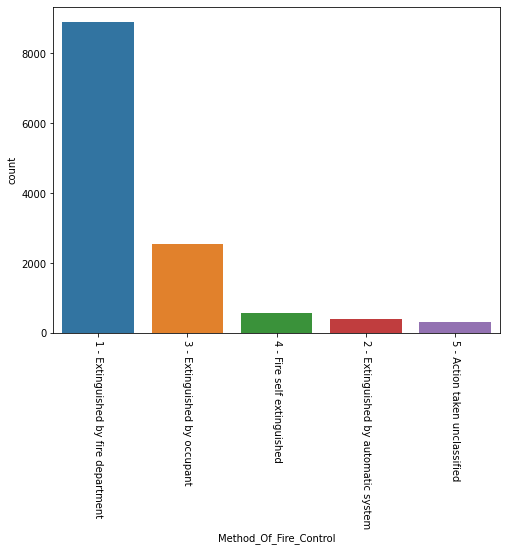

In [333]:
#Method_Of_Fire_Control
#Definition: A code and description given by the OFM to describe the method of fire control.
fire_data.Method_Of_Fire_Control.describe()

#This is a categorical attribute with nominal data. There are 5 levels:
fire_data.Method_Of_Fire_Control.unique()

plt.figure(figsize=(8, 6))
sns.countplot(x='Method_Of_Fire_Control', data=fire_data, order = fire_data.Method_Of_Fire_Control.value_counts().index)
plt.xticks(rotation=-90)

fire_data.Method_Of_Fire_Control.value_counts(normalize=True)
#It not surprising that a majority of the fires (70.1%) were extinguished by the fire department; it can be assumed that in most cases, the fire department is only called when the fire cannot be put out by civilians at the scene.

#Convert to category dtype:
fire_data.Method_Of_Fire_Control = fire_data.Method_Of_Fire_Control.astype('category')
print(fire_data.Method_Of_Fire_Control.dtype)

count    12687.000000
mean         7.389296
std          7.914590
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max        436.000000
Name: Number_of_responding_apparatus, dtype: float64
6      0.276425
1      0.157642
5      0.114369
7      0.076929
10     0.044691
2      0.039883
3      0.035942
11     0.034366
17     0.033420
8      0.026957
4      0.022385
18     0.019075
9      0.018050
12     0.016868
16     0.012611
19     0.010247
13     0.008907
20     0.007252
15     0.005675
14     0.005123
21     0.005123
22     0.005045
24     0.002365
23     0.002128
27     0.001892
28     0.001813
29     0.001813
26     0.001655
25     0.001419
31     0.000709
34     0.000552
33     0.000552
30     0.000552
35     0.000473
39     0.000473
38     0.000473
42     0.000473
43     0.000394
37     0.000394
36     0.000394
51     0.000394
40     0.000315
32     0.000315
45     0.000236
47     0.000236
44     0.000158
50     0.000158
75     0.000158
79 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

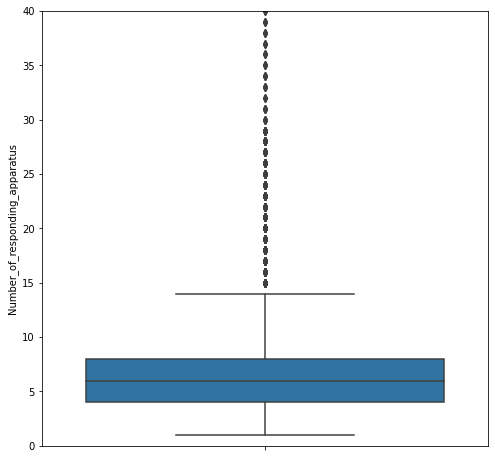

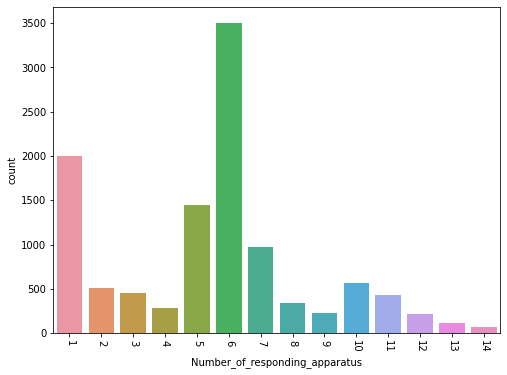

In [334]:
#Number_of_responding_apparatus
#Definition: Number of TFS responding units

print(fire_data.Number_of_responding_apparatus.describe())
#This attribute contains quantitative, ratio data.

print(fire_data.Number_of_responding_apparatus.value_counts(normalize=True))
#The two most common values are 1 and 6. This makes sense given the operating procedures of TFS: any residential fire, no matter how small, are addressed with six units. 64.7% of fires are addressed with 6 units or less.

plt.figure(figsize=(8, 8))
plt.ylim(0, 40)
sns.boxplot(y="Number_of_responding_apparatus", data=fire_data)
#It appears that observations in which 15 or more TFS apparatuses responded to a fire are mathematical outliers.

print(round(len(fire_data[fire_data.Number_of_responding_apparatus >= 15]) / len(fire_data), 3))
#12.1% of the data consists of mathematical outliers. However, there is no indication that these outliers represent incorrect data - some fires simply require greater resources. I can find no reason to delete these observations.

plt.figure(figsize=(8, 6))
sns.countplot(x='Number_of_responding_apparatus', data=fire_data[fire_data.Number_of_responding_apparatus <= 14])
plt.xticks(rotation=-90)

count    12687.000000
mean        24.411997
std         24.268019
min          1.000000
25%         14.000000
50%         21.000000
75%         29.000000
max       1275.000000
Name: Number_of_responding_personnel, dtype: float64
4       0.152124
21      0.132261
22      0.068811
17      0.059746
20      0.055017
18      0.033026
8       0.028060
10      0.026090
23      0.024671
24      0.022779
19      0.022149
16      0.020572
34      0.020336
25      0.019075
35      0.014582
33      0.014109
26      0.013005
52      0.010956
53      0.010877
36      0.010483
13      0.010483
14      0.010326
7       0.009931
37      0.008434
54      0.008276
30      0.008276
29      0.007724
31      0.007724
38      0.007409
28      0.007173
27      0.007094
32      0.007015
15      0.006779
56      0.006227
50      0.005596
55      0.005517
39      0.005281
12      0.005045
51      0.005045
40      0.004887
58      0.004493
3       0.004414
49      0.004414
48      0.004178
11      0.003862
57    

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text major ticklabel objects>)

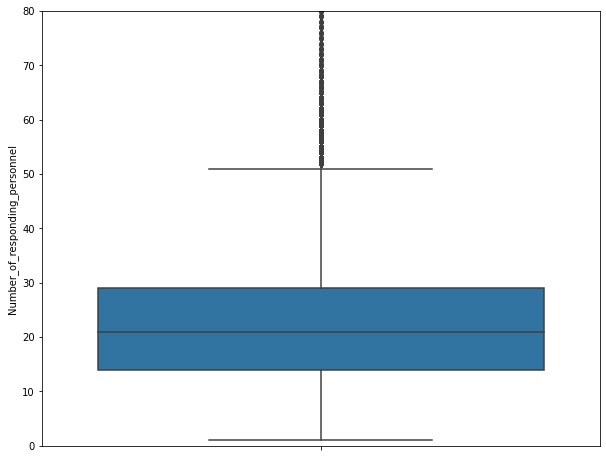

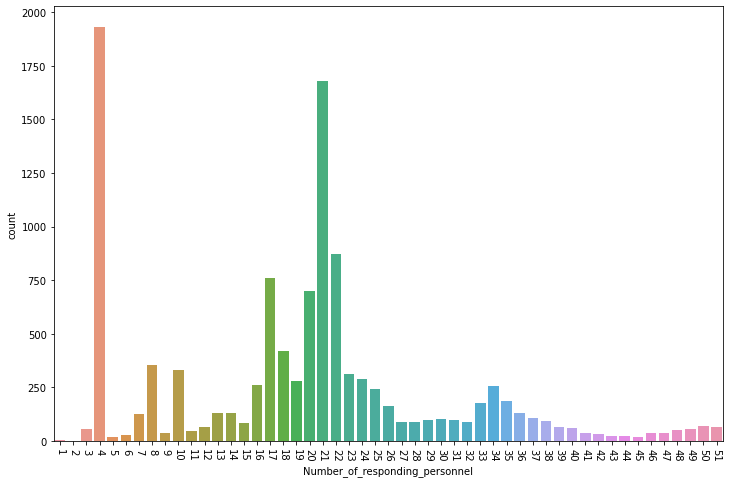

In [335]:
#Number_of_responding_personnel
#Definition: Number of TFS responding personnel

print(fire_data.Number_of_responding_personnel.describe())
#This attribute contains quantitative, ratio data.

print(fire_data.Number_of_responding_personnel.value_counts(normalize=True))

plt.figure(figsize=(10, 8))
plt.ylim(0, 80)
sns.boxplot(y="Number_of_responding_personnel", data=fire_data)

print(round(len(fire_data[fire_data.Number_of_responding_personnel >= 52]) / len(fire_data), 3))
#Instances in which 52 or more firefighters responded to a fire are mathematical outliers - 9.8% of the observations. However, there is no indication that these outliers represent incorrect data - some fires simply require greater resources. I can find no reason to delete these observations.

plt.figure(figsize=(12, 8))
sns.countplot(x='Number_of_responding_personnel', data=fire_data[fire_data.Number_of_responding_personnel <= 51])
plt.xticks(rotation=-90)

count                 12687
unique                   19
top       99 - Undetermined
freq                   2586
Name: Possible_Cause, dtype: object
0
['51 - Mechanical Failure' '11 - Children Playing (Ages 11 and under)'
 '28 - Routine maintenance deficiency, eg creosote, lint, grease buildup'
 '99 - Undetermined' '45 - Improperly Discarded' '52 - Electrical Failure'
 '47 - Improper handling of ignition source or ignited material'
 '60 - Other unintentional cause, not classified'
 '98 - Unintentional, cause undetermined'
 '20 - Design/Construction/Installation/Maintenance Deficiency'
 '44 - Unattended' '46 - Used or Placed too close to combustibles'
 '12 - Vehicle Accident/Collision'
 '50 - Other misuse of ignition source/material ignited'
 '49 - Improper Storage' '48 - Used for purpose not intended'
 '73 - Natural Cause' '72 - Rekindle' '80 - Exposure fire']
99 - Undetermined                                                         0.203831
52 - Electrical Failure                      

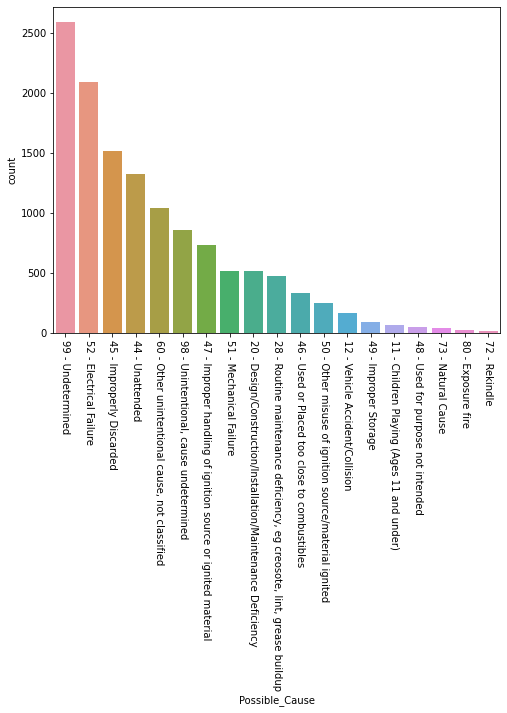

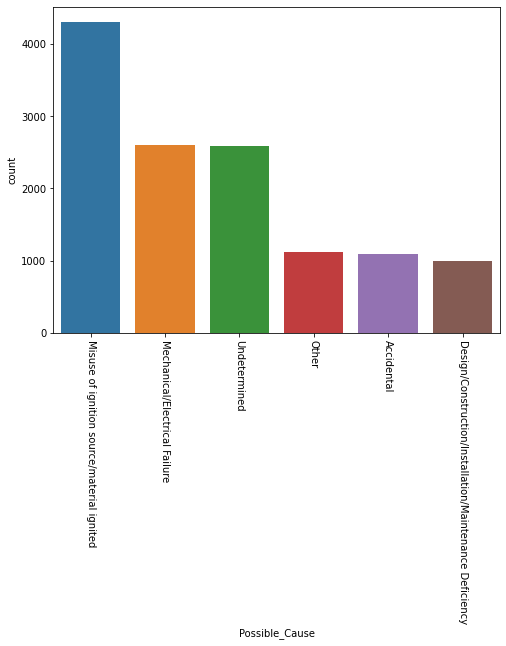

In [336]:
#Possible_Cause
#Definition: A code and description assigned to the fire incident by the Ontario Fire Marshal (OFM). It describes the possible cause of the fire.

print(fire_data.Possible_Cause.describe())
print(fire_data.Possible_Cause.isna().sum())
#This is a categorical attribute with nominal data. There are 19 levels:
print(fire_data.Possible_Cause.unique())

plt.figure(figsize=(8, 6))
sns.countplot(x='Possible_Cause', data=fire_data, order = fire_data.Possible_Cause.value_counts().index)
plt.xticks(rotation=-90)

print(fire_data.Possible_Cause.value_counts(normalize=True))
#The observations are varied, with the most common level ("Undetermined") making up 20.4% of the data.

#It is possible to reduce the cardinality of this attribute using the groups in the OFM Codes List document.

PC_dict = {'Accidental': ['11 - Children Playing (Ages 11 and under)', 
                          '12 - Vehicle Accident/Collision',
                          '98 - Unintentional, cause undetermined'], 
           'Design/Construction/Installation/Maintenance Deficiency': ['20 - Design/Construction/Installation/Maintenance Deficiency', 
                                                                       '28 - Routine maintenance deficiency, eg creosote, lint, grease buildup'], 
           'Misuse of ignition source/material ignited': ['44 - Unattended', 
                                                          '45 - Improperly Discarded', 
                                                          '46 - Used or Placed too close to combustibles', 
                                                          '47 - Improper handling of ignition source or ignited material', 
                                                          '48 - Used for purpose not intended', 
                                                          '49 - Improper Storage', 
                                                          '50 - Other misuse of ignition source/material ignited'], 
           'Mechanical/Electrical Failure': ['51 - Mechanical Failure', 
                                             '52 - Electrical Failure'], 
           'Other': ['60 - Other unintentional cause, not classified', 
                     '72 - Rekindle', 
                     '73 - Natural Cause', 
                     '80 - Exposure fire'], 
           'Undetermined': ['99 - Undetermined']}
PC_dict_2 = {v: k for k, vv in PC_dict.items() for v in vv}
fire_data.Possible_Cause = fire_data.Possible_Cause.map(PC_dict_2)

plt.figure(figsize=(8, 6))
sns.countplot(x='Possible_Cause', data=fire_data, order = fire_data.Possible_Cause.value_counts().index)
plt.xticks(rotation=-90)

print(fire_data.Possible_Cause.value_counts(normalize=True))
fire_data.Possible_Cause.astype('category').cat.categories
#With the cardinality reduction to six levels, Undetermined is now the third most common attribute. The most common level is now "Misuse of ignition source/material ignited," making up 34.5% of the observations.

#Convert to category dtype:
fire_data.Possible_Cause = fire_data.Possible_Cause.astype('category')
print(fire_data.Possible_Cause.dtype)

Residential                               0.556834
Vehicles                                  0.146539
Miscellaneous                             0.128252
Industrial Occupancies                    0.053602
Assembly Occupancies                      0.048479
Mercantile                                0.029481
Business/personal services Occupancies    0.024515
Institutional Occupancies                 0.012297
Name: Property_Use, dtype: float64
category


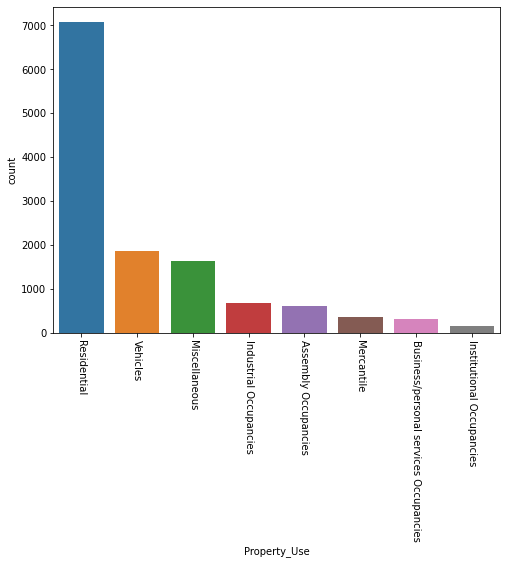

In [337]:
#Property_Use
#Definition: A code and description assigned to the fire incident by the Ontario Fire Marshal (OFM). It describes the use of the property where the fire occurred.
fire_data.Property_Use.describe()
fire_data.Property_Use.isna().sum()
#This is a categorical attribute with nominal data and very high cardinality. There are 270 levels.
#The cardinality of this attribute is so high that it would not be possible even to read a graph. It is possible to reduce the cardinality of this attribute using the groups in the OFM Codes List document.

PU_dict = {'Assembly Occupancies': ['101 - Theatre - Motion Picture', 
                                    '102 - Theatre - Concert Hall, Live', 
                                    '103 - TV, radio, motion picture studio', 
                                    '111 - Museum', 
                                    '112 - Art Gallery', 
                                    '113 - Library', 
                                    '114 - Auditorium', 
                                    '115 - Lecture Hall', 
                                    '121 - Bowling Alley, Billiard Centre, pool hall', 
                                    '123 - Community/Exhibition/Dance Hall', 
                                    '124 - Sports/Country/Social/Yacht Club', 
                                    '125 - Gymnasium', 
                                    '126 - Non Residential Club', 
                                    '127 - Casino', 
                                    '128 - Bingo Hall', 
                                    '131 - School - Pre-Elementary', 
                                    '132 - School - Elementary', 
                                    '133 - School - Secondary Junior High (Gr. 7 & 8)', 
                                    '134 - School - Secondary/Senior High (Gr. 9+)', 
                                    '135 - School - Technical, Industrial Trade', 
                                    '136 - School - Business, Commerce, Secretarial', 
                                    '137 - School - Post Secondary (University)', 
                                    '138 - School - Post Secondary (College)', 
                                    '142 - Bus Terminal', 
                                    '143 - Railway Station', 
                                    '144 - Subway Station', 
                                    '145 - Marine Terminal', 
                                    '151 - Restaurants (occupant load greater than 30 persons, licensed)', 
                                    '152 - Bar, Tavern, Night Club', 
                                    '153 - Church, Other Similar Place of Worship', 
                                    '154 - Funeral Facility', 
                                    '155 - Legislative Facility/Building', 
                                    '156 - Court Facility', 
                                    '157 - Day Care Centre', 
                                    '158 - Church Hall', 
                                    '161 - Arena', 
                                    '162 - Ice Rink', 
                                    '163 - Indoor Swimming Facility', 
                                    '172 - Stadium', 
                                    '173 - Exhibition, Fair Stand, Amusement Park Structure', 
                                    '174 - Bleacher, Grandstand, Reviewing Stand', 
                                    '175 - Tent or temporary structure for assembly activity', 
                                    '199 - Other Assembly'],
           'Institutional Occupancies': ['201 - Jail, Prison, Penitentiary', 
                                         '202 - Reformatory (with detention quarters)', 
                                         '203 - Adult Detention Camp (minimum security)', 
                                         '204 - Police Station (with detention quarters)', 
                                         '206 - Psychiatric Hospital (with detention quarters)', 
                                         '211 - Psychiatric Hospital (without detention quarters)', 
                                         '212 - Public/Private Hospital', 
                                         '216 - Convalescent Home or long term care (excluding senior care)', 
                                         '218 - Hospice', 
                                         '222 - Institute for the blind, deaf', 
                                         '223 - Seniors long term care facility, licensed', 
                                         '229 - Other care facility', 
                                         '231 - Shelter for displaced/abused persons', 
                                         '232 - Halfway/Transitional House', 
                                         '233 - Group Home', 
                                         '234 - Retirement Home', 
                                         '299 - Other Care & Detention Not Classified'], 
           'Residential': ['301 - Detached Dwelling', 
                           '302 - Semi-Detached Dwelling', 
                           '303 - Attached Dwelling (eg. rowhouse, townhouse, etc.)', 
                           '311 - Rooming/Boarding/Lodging House', 
                           '321 - Multi-Unit Dwelling - 2 to 6 Units', 
                           '322 - Multi-Unit Dwelling - 7 to 12 Units', 
                           '323 - Multi-Unit Dwelling - Over 12 Units', 
                           '331 - Apartment, Flat, Tenement with Business', 
                           '332 - Detached Dwelling with Business', 
                           '333 - Semi-Detached Dwelling with Business', 
                           '334 - Attached Dwelling with Business', 
                           '335 - Detached/Semi/Attached with Accessory Apartment Above Grade', 
                           '336 - Detached/Semi/Attached with Accessory Apartment Below Grade', 
                           '341 - Motor Home, Camper, Trailer', 
                           '342 - Mobile Home', 
                           '343 - Tent', 
                           '344 - Houseboat', 
                           '355 - Hotel, Motel, Lodging - 4 or more guests or suites', 
                           '356 - Hotel, Motel, Lodging - Less than 4 guests or suites (inc B&B)', 
                           '361 - School/College Dormitory (detached from educational facility)', 
                           '365 - Detached Garage', 
                           '366 - Residential Club (inc sorority, fraternity)', 
                           '367 - Hostel', 
                           '399 - Other Residential'], 
           'Business/personal services Occupancies': ['401 - Bank', 
                                                      '402 - Post Office', 
                                                      '403 - Barber Shop, Hairdresser, Beauty Parlor, tanning salon', 
                                                      '404 - Laundry, Dry Cleaner (includes self-service)', 
                                                      '405 - General Business Office', 
                                                      '406 - Police Station (without detention quarters)', 
                                                      '407 - Dental/Medical Office', 
                                                      '410 - Small Tool/Appliance Rental/Service Establishment', 
                                                      '411 - Fire Station', 
                                                      '412 - Engineering, Architect or Tech office', 
                                                      '413 - Mailing, photocopying office', 
                                                      '415 - Computer, electronic data processing, records storage', 
                                                      '416 - Furniture, upholstery repair without sales', 
                                                      '418 - Tent or temporary structure for business or personal service activity', 
                                                      '498 - Garage:  General Auto Parking - Structure', 
                                                      '499 - Other Business or Personal Services'], 
           'Mercantile': ['501 - Restaurant (occupant load less than 30 persons)', 
                          '502 - Supermarket, Grocery Store', 
                          '503 - Specialty Food Store (eg. butcher, delicatessen, etc.)', 
                          '504 - Convenience/Variety Store', 
                          '505 - Liquor/Wine/Beer Store', 
                          '506 - Market - Outdoors (flowers, fruit, vegetable sales)', 
                          '507 - Market - Indoors (flowers, fruit, vegetable sales)', 
                          '510 - Mall - public area common to multi store facility', 
                          '511 - Department Store', 
                          '521 - Clothing Store, Accessories, fur', 
                          '522 - Fabric Store', 
                          '523 - Furniture/Appliance Store', 
                          '524 - Paint/Wallpaper Store', 
                          '525 - Hardware Store', 
                          '526 - Building Supply Store', 
                          '527 - Lumber Yard', 
                          '528 - Garden Supply', 
                          '529 - Book/Stationary/Art Supply Store', 
                          '530 - Pharmacy', 
                          '531 - Florist', 
                          '534 - Video Rental Shop', 
                          '535 - Computer/electronics store, service or repair', 
                          '537 - Rug, floor covering store', 
                          '539 - Gifts, jewellery, leather goods, mixed goods', 
                          '541 - Tent or temporary structure for Mercantile activity', 
                          '543 - Big Box Store', 
                          '599 - Other Mercantile'], 
           'Industrial Occupancies': ['601 - Motor Vehicle Sales', 
                                      '602 - Service Station', 
                                      '603 - Motor Vehicle Repair Garage', 
                                      '604 - Motor Vehicle Parts, Accessory Sales', 
                                      '607 - Marina, Marine Service Station', 
                                      '609 - Other Vehicle Sales/Service', 
                                      '612 - Hydro Distribution Facility', 
                                      '614 - Gas Distribution Facility', 
                                      '615 - Water Works', 
                                      '617 - Sanitary Services (includes plant)', 
                                      '619 - Other Utilities', 
                                      '620 - Heating Plant - central/district heating plant, steam, etc', 
                                      '621 - Mfg: Petroleum Products', 
                                      '622 - Mfg: Chemicals, inc hazardous chemicals', 
                                      '623 - Mfg: Plastics', 
                                      '624 - Mfg: Paint, Varnishes, Lacquers', 
                                      '625 - Mfg: Drugs, Cosmetics, Pharmaceutical', 
                                      '626 - Mfg: Rubber Goods', 
                                      '627 - Mfg: Asphalt Products', 
                                      '629 - Mfg: Other Chemical/Petroleum/Paint/Plastic Products', 
                                      '631 - Mfg: Meat/Poultry/Fish Products', 
                                      '633 - Mfg: Grain Products, Bakery Goods', 
                                      '634 - Mfg: Alcoholic Beverages', 
                                      '637 - Mfg: Vegetable/Animal Oil Products', 
                                      '638 - Mfg: Sugar Refining, Sugar Products', 
                                      '639 - Mfg: Other Agr/Food, Beverage, Tabac products', 
                                      '640 - Mfg:  Canning, preserving, processing fruits, vegetables', 
                                      '641 - Mfg: Textile Manufacturing (e.g. preparing fibers, spinning, weaving)', 
                                      '644 - Mfg: Wearing Apparal Manufacturing', 
                                      '645 - Mfg: Dry Cleaning Plant', 
                                      '646 - Mfg:  Floor covering and coated fabrics (exc rubber, ceramic)', 
                                      '649 - Mfg: Other Textiles, Clothing, Leather goods', 
                                      '651 - Mfg: Pulp, Paper Processing', 
                                      '652 - Mfg: Primary Processing (eg sawmill, plywood manufacturer, etc)', 
                                      '653 - Mfg: Secondary Processing (eg finished goods, furniture, etc)', 
                                      '654 - Mfg: Printing, Publishing (eg newspapers, magazines, books)', 
                                      '655 - Mfg: Job Printing (eg forms, greeting cards, etc)', 
                                      '659 - Mfg: Other Wood, Furniture, Paper Products, Printing', 
                                      '661 - Mfg: Road Vehicles, Parts', 
                                      '664 - Mfg: Aircraft, Parts', 
                                      '665 - Specialty Vehicles, Parts', 
                                      '669 - Mfg: Other Vehicles, Parts', 
                                      '671 - Mfg: Primary Metal Processing (eg refining, melting, etc)', 
                                      '672 - Mfg: Secondary Metal Processing (eg rolling, drawing, polishing)', 
                                      '673 - Mfg: Prec.Goods/Instruments (eg surgical instr, cameras, etc)', 
                                      '674 - Mfg: Precious Metals, Jewellery', 
                                      '678 - Mfg:Glass & glass products, china, pottery', 
                                      '679 - Mfg: Other Metal/Eletctrical/Miscellaneous Products', 
                                      '682 - Sto: Chemicals, inc hazardous chemicals', 
                                      '683 - Sto: Plastics', 
                                      '691 - Sto: Tank, Tank Farm, Other Liquids', 
                                      '701 - Sto: Meat/Poultry/Fish products', 
                                      '702 - Sto: Dairy Goods, Produce', 
                                      '703 - Sto: Grain Products, Bakery Goods', 
                                      '705 - Sto: Soft Drinks', 
                                      '707 - Sto: Vegetable/Animal Oil Products', 
                                      '708 - Sto: Sugar Refining, Sugar Products', 
                                      '709 - Sto: Cold Storage - Processed Food', 
                                      '716 - Sto: Packed food stuffs (not classified by other codes)', 
                                      '723 - Sto: Wearing Apparal', 
                                      '724 - Sto: Dry Cleaning Plant', 
                                      '729 - Sto: Other Textile Goods', 
                                      '731 - Sto: Pulp, Paper', 
                                      '733 - Secondary Products (eg. finished goods, furniture, etc.)', 
                                      '739 - Sto: Other Wood, Furniture, Paper Products, Printing', 
                                      '741 - Sto: Road Vehicles, Parts', 
                                      '742 - Sto: Rail Vehicles, Parts', 
                                      '745 - Sto: Specialty Vehicles, Parts', 
                                      '749 - Sto: Other Vehicles, Parts', 
                                      '753 - Sto: Precision Goods/Instruments', 
                                      '759 - Sto: Other Metal/Electrical/Misc Parts', 
                                      '760 - Sto: Warehouse, variety of items, not classified by codes', 
                                      '761 - Sto: Glass & Glass Products, pottery, chinaware', 
                                      '769 - Sto: Tent or temporary structure for industrial storage', 
                                      '791 - Recycling Facility', 
                                      '792 - Waste Transfer Station', 
                                      '793 - Laboratory', 
                                      '799 - Other Industrial'], 
           'Miscellaneous': ['801 - Mine', 
                             '803 - Quarry', 
                             '812 - Bridge, Overpass, Trestle, Tunnel, Underpass', 
                             '821 - Radio Transmission Site, Microwave Tower', 
                             '822 - Telephone Exchange', 
                             '831 - Agricultural Products', 
                             '832 - Processed Food Beverages', 
                             '833 - Flammable/Combustible Liquids, Gases', 
                             '834 - Chemicals, Plastics, Rubber Products', 
                             '836 - Metal Products, Machinery, Appliances', 
                             '837 - Vehicles or Vehicle Parts', 
                             '838 - General Goods', 
                             '839 - Tent or temporary structure not classified under other occupancy', 
                             '841 - Mailbox', 
                             '842 - Fence', 
                             "843 - Shed, Children's Playhouse", 
                             '844 - Privy', 
                             '845 - Telephone Booth', 
                             '846 - Hydro/Telephone Pole', 
                             '847 - Toll Station, Weather/Bus Shelter', 
                             '848 - Trash/Rubbish/Garbage Container or Dumpster', 
                             '849 - Tarpot', 
                             '850 - Parking Lot Kiosk', 
                             '852 - Clothing Drop Box, etc.', 
                             '853 - Gazebo', 
                             '854 - Sauna - Outdoors', 
                             '855 - Outbuildings - structure not classified elsewhere', 
                             '856 - Freestanding deck', 
                             '860 - Lawn around structure', 
                             '861 - Open Land (eg. light ground cover, bush, grass, etc.)', 
                             '862 - Forest, Standing Timber', 
                             '863 - Tree, Hedge', 
                             '864 - Dump, Land Fill Site', 
                             '866 - Silo, Storage Facility', 
                             '868 - Greenhouse', 
                             '869 - Other farm building (e.g. curing shed, growing facility)', 
                             '870 - Barn - containing equipment or produce only', 
                             '871 - Barn - housing animals', 
                             '872 - Animal shelter, excluding farm structures', 
                             '890 - Composting site (large scale, eg municipal)', 
                             '891 - Outdoor general auto parking', 
                             '893 - Cemetery', 
                             '896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)', 
                             '897 - Structure under 10 sq. metres not classified', 
                             '898 - Other property non structure not classified'], 
           'Vehicles': ['901 - Automobile', 
                        '902 - Small Truck (eg. pick-up, van, etc.)', 
                        '903 - Large Truck (Excluding Truck Trailer)', 
                        '904 - Trailer Combin. (e.g. auto trailer, small t&t, t&t, etc)', 
                        '905 - Motorcycle', 
                        '906 - Bus, Trackless Trolley', 
                        '907 - Emergency Vehicle', 
                        '909 - Multiple Road Vehicles', 
                        '911 - Railway Train', 
                        '912 - Subway Train', 
                        '914 - Multiple Rail Vehicles', 
                        '921 - Private or Business Watercraft', 
                        '941 - Construction Vehicles', 
                        '942 - Industrial Vehicles', 
                        '943 - Agricultural Vehicles', 
                        '944 - Multiple Specialty Vehicles', 
                        '945 - Tank truck - Compressed or LP Gas, flammable liquid, chemicals', 
                        '946 - Other specialty vehicle', 
                        '994 - Multiple Vehicles - combination of types', 
                        '999 - Other Vehicle']}
PU_dict_2 = {v: k for k, vv in PU_dict.items() for v in vv}
fire_data.Property_Use = fire_data.Property_Use.map(PU_dict_2)

plt.figure(figsize=(8, 6))
sns.countplot(x='Property_Use', data=fire_data, order = fire_data.Property_Use.value_counts().index)
plt.xticks(rotation=-90)

print(fire_data.Property_Use.value_counts(normalize=True))

#The cardinality has been reduced to eight levels. The most common level is "Residential" - 55.7% of fires occurred at residential properties.
#There is one missing observation. for which I will impute the mode, in this case "Residential." This is not the preferred way to deal with missing values, as the risk with imputation is that it will result in data loss, but for one missing observation out of 12,000+ it represents little risk and will suffice in this case.

fire_data.Property_Use = fire_data.Property_Use.fillna('Residential')

#Convert dtype to category:
fire_data.Property_Use = fire_data.Property_Use.astype('category')
print(fire_data.Property_Use.dtype)

count                                                  9203
unique                                                    5
top       2 - Floor/suite of fire origin: Smoke alarm pr...
freq                                                   3973
Name: Smoke_Alarm_at_Fire_Origin, dtype: object
[nan
 '4 - Floor/suite of fire origin: Smoke alarm present, operation undetermined'
 '1 - Floor/suite of fire origin: No smoke alarm'
 '2 - Floor/suite of fire origin: Smoke alarm present and operated'
 '9 - Floor/suite of fire origin: Smoke alarm presence undetermined'
 '3 - Floor/suite of fire origin: Smoke alarm present did not operate']
2 - Floor/suite of fire origin: Smoke alarm present and operated               0.313155
NaN                                                                            0.274612
1 - Floor/suite of fire origin: No smoke alarm                                 0.158036
3 - Floor/suite of fire origin: Smoke alarm present did not operate            0.117443
9 - Floor/suite o

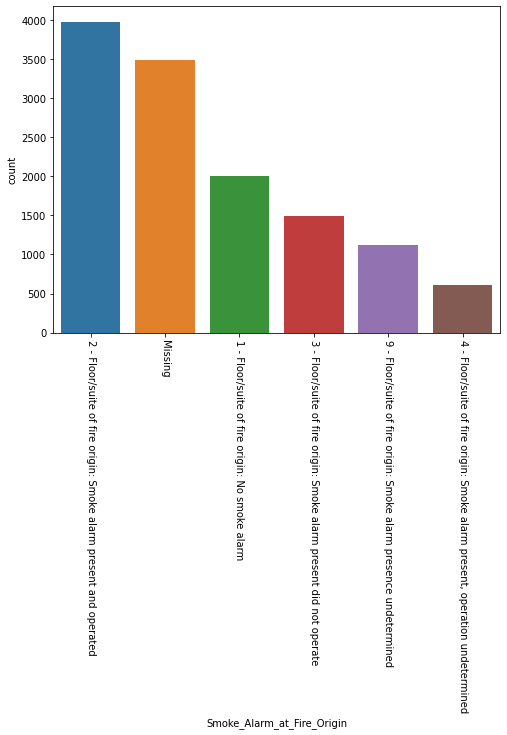

In [338]:
#Smoke_Alarm_at_Fire_Origin
#Definition: A code and description assigned by the OFM to describe the failure of the smoke alarm
print(fire_data.Smoke_Alarm_at_Fire_Origin.describe())

#This is a categorical variable with nominal data and 5 levels. The levels are:
print(fire_data.Smoke_Alarm_at_Fire_Origin.unique())

print(fire_data.Smoke_Alarm_at_Fire_Origin.value_counts(normalize=True, dropna=False))
#As with some other attributes that we have already encountered, about a quarter (27.5%, to be exact) of the observations are missing. As I have done with other attributes, rather than risking the introduction of bias into my models or data loss, I will create an additional level, "Missing", to flag that the data is missing.
fire_data.Smoke_Alarm_at_Fire_Origin = fire_data.Smoke_Alarm_at_Fire_Origin.fillna('Missing')

plt.figure(figsize=(8, 6))
sns.countplot(x='Smoke_Alarm_at_Fire_Origin', data=fire_data, order = fire_data.Smoke_Alarm_at_Fire_Origin.value_counts().index)
plt.xticks(rotation=-90)

print(fire_data.Smoke_Alarm_at_Fire_Origin.value_counts(normalize=True))
#The most common level is "Smoke Alarm Present and Operated," which makes up 31.3% of the observations.

#Convert to category dtype:
fire_data.Smoke_Alarm_at_Fire_Origin = fire_data.Smoke_Alarm_at_Fire_Origin.astype('category')
print(fire_data.Smoke_Alarm_at_Fire_Origin.dtype)

count                                                  9203
unique                                                   11
top       98 - Not applicable: Alarm operated OR presenc...
freq                                                   6270
Name: Smoke_Alarm_at_Fire_Origin_Alarm_Failure, dtype: object
[nan
 '98 - Not applicable: Alarm operated OR presence/operation undetermined'
 '1 - No battery' '99 - Reason for inoperation undetermined'
 '9 - Other reason' '4 - Remote from fire – smoke did not reach alarm'
 '3 - Electrical line or battery not connected'
 '5 - Separated from fire (e.g. wall, etc)' '2 - Dead battery'
 '7 - Unit failure' '8 - Tampered with (vandalism)'
 '6 - Improper installation of unit']
98 - Not applicable: Alarm operated OR presence/operation undetermined    0.494207
NaN                                                                       0.274612
4 - Remote from fire – smoke did not reach alarm                          0.075668
99 - Reason for inoperation undetermi

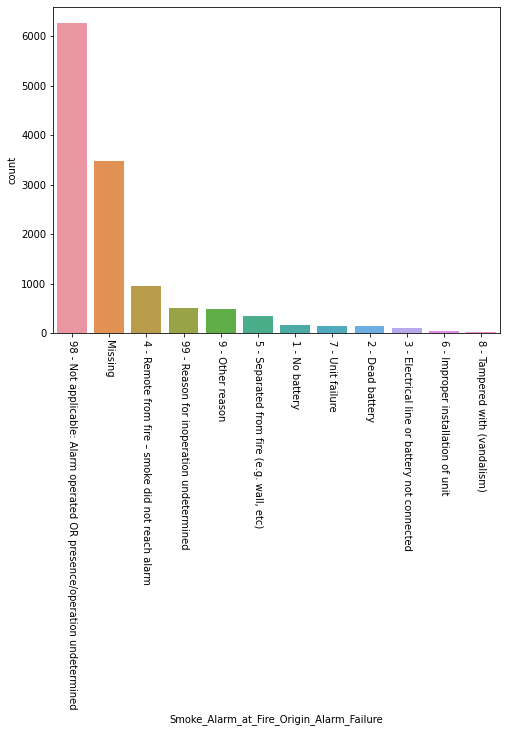

In [339]:
#Smoke_Alarm_at_Fire_Origin_Alarm_Failure
#Definition: A code and description assigned by the OFM to describe the failure of the smoke alarm
print(fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Failure.describe())

#This is a categorical variable with nominal data 11 levels. They are:
print(fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Failure.unique())

print(fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Failure.value_counts(normalize=True, dropna=False))
#As with some other attributes that we have already encountered, about a quarter (27.5%, to be exact) of the observations are missing. As I have done with other attributes, rather than risking the introduction of bias into my models or data loss, I will create an additional level, "Missing", to flag that the data is missing.
fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Failure = fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Failure.fillna('Missing')

plt.figure(figsize=(8, 6))
sns.countplot(x='Smoke_Alarm_at_Fire_Origin_Alarm_Failure', data=fire_data, order = fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Failure.value_counts().index)
plt.xticks(rotation=-90)

print(fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Failure.value_counts(normalize=True, dropna=False))
#The most common level is "Not Applicable," which makes up 49.4% of the observations.

#Convert dtype to category:
fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Failure = fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Failure.astype('category')
print(fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Failure.dtype)

count                                                  9203
unique                                                    6
top       8 - Not applicable - no smoke alarm or presenc...
freq                                                   2099
Name: Smoke_Alarm_at_Fire_Origin_Alarm_Type, dtype: object
[nan '9 - Type undetermined'
 '8 - Not applicable - no smoke alarm or presence undetermined'
 '2 - Hardwired (standalone)' '1 - Battery operated' '4 - Interconnected'
 '3 - Wireless']
NaN                                                             0.274612
8 - Not applicable - no smoke alarm or presence undetermined    0.165445
1 - Battery operated                                            0.157721
2 - Hardwired (standalone)                                      0.147316
4 - Interconnected                                              0.130843
9 - Type undetermined                                           0.122409
3 - Wireless                                                    0.001655
Name: 

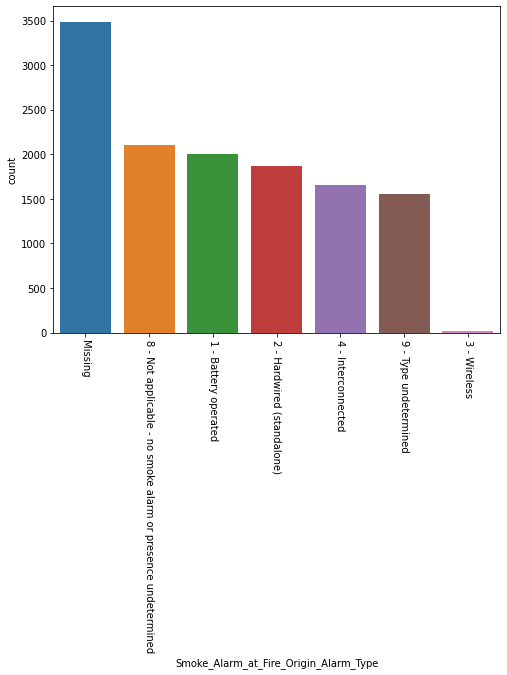

In [340]:
#Smoke_Alarm_at_Fire_Origin_Alarm_Type
#Description: A code and description assigned by the OFM to describe the type of fire alarm where the fire originated
print(fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Type.describe())

#This is a categorical variable with nominal data. There are 6 levels:
print(fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Type.unique())

print(fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Type.value_counts(normalize=True, dropna=False))
#As with some other attributes that we have already encountered, about a quarter (27.5%, to be exact) of the observations are missing. As I have done with other attributes, rather than risking the introduction of bias into my models or data loss, I will create an additional level, "Missing", to flag that the data is missing.
fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Type = fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Type.fillna('Missing')

plt.figure(figsize=(8, 6))
sns.countplot(x='Smoke_Alarm_at_Fire_Origin_Alarm_Type', data=fire_data, order = fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Type.value_counts().index)
plt.xticks(rotation=-90)

print(fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Type.value_counts(normalize=True, dropna=False))
#We can see that there are a diversity of smoke alarms used, as well many observations which are marked Not Applicable (16.5%)

#Convert dtype to category:
fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Type = fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Type.astype('category')
print(fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Type.dtype)

count                                                  9203
unique                                                    7
top       1 - All persons (at risk of injury) self evacu...
freq                                                   2495
Name: Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation, dtype: object
[nan '7 - Not applicable: Occupant(s) first alerted by other means'
 '8 - Not applicable: No alarm, no persons present'
 '1 - All persons (at risk of injury) self evacuated as a result of hearing alarm'
 '9 - Undetermined'
 '2 - Some persons (at risk) self evacuated as a result of hearing alarm'
 '3 - No one (at risk) evacuated as a result of hearing alarm'
 '4 - Alarm operated but failed to alert occupant(s) (at risk)']
NaN                                                                                0.274612
1 - All persons (at risk of injury) self evacuated as a result of hearing alarm    0.196658
7 - Not applicable: Occupant(s) first alerted by other means        

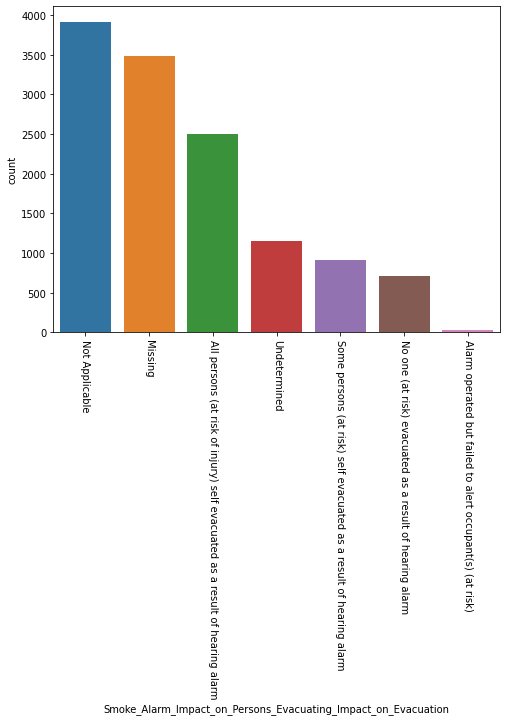

In [341]:
#Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation
#Description: A code and description assigned by the OFM to describe the impact of the smoke alarm on persons evacuating a building during a fire
print(fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation.describe())

#This is a categorical attribute with nominal data and 7 levels. The levels are:
print(fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation.unique())

print(fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation.value_counts(normalize=True, dropna=False))
#As with some other attributes that we have already encountered, about a quarter (27.5%, to be exact) of the observations are missing. As I have done with other attributes, rather than risking the introduction of bias into my models or data loss, I will create an additional level, "Missing", to flag that the data is missing.
fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation = fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation.fillna('Missing')

#Two levels describe not applicable observations. These can be combined together into one level.
SAI_dict = {'Missing': ['Missing'], 
            'All persons (at risk of injury) self evacuated as a result of hearing alarm': ['1 - All persons (at risk of injury) self evacuated as a result of hearing alarm'], 
            'Some persons (at risk) self evacuated as a result of hearing alarm': ['2 - Some persons (at risk) self evacuated as a result of hearing alarm'], 
            'No one (at risk) evacuated as a result of hearing alarm': ['3 - No one (at risk) evacuated as a result of hearing alarm'], 
            'Alarm operated but failed to alert occupant(s) (at risk)': ['4 - Alarm operated but failed to alert occupant(s) (at risk)'], 
            'Not Applicable': ['7 - Not applicable: Occupant(s) first alerted by other means', '8 - Not applicable: No alarm, no persons present'], 
            'Undetermined': ['9 - Undetermined']}
SAI_dict_2 = {v: k for k, vv in SAI_dict.items() for v in vv}
fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation = fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation.map(SAI_dict_2)

plt.figure(figsize=(8, 6))
sns.countplot(x='Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation', data=fire_data, order = fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation.value_counts().index)
plt.xticks(rotation=-90)

print(fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation.value_counts(normalize=True))
#67.3% of the data in this attribute is either missing, not applicable, or unattributed.

#Convert to category dtype:
fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation = fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation.astype('category')
print(fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation.dtype)

count                                            9203
unique                                             10
top       2 - Confined to part of room/area of origin
freq                                             2416
Name: Smoke_Spread, dtype: object
[nan '2 - Confined to part of room/area of origin'
 '4 - Spread beyond room of origin, same floor'
 '3 - Spread to entire room of origin'
 '7 - Spread to other floors, confined to building'
 '9 - Confined to roof/exterior structure' '99 - Undetermined'
 '5 - Multi unit bldg: spread beyond suite of origin but not to separated suite(s)'
 '6 - Multi unit bldg: spread to separate suite(s)' '8 - Entire Structure'
 '10 - Spread beyond building of origin']
NaN                                                                                 0.274612
2 - Confined to part of room/area of origin                                         0.190431
4 - Spread beyond room of origin, same floor                                        0.177583
7 - Spread to oth

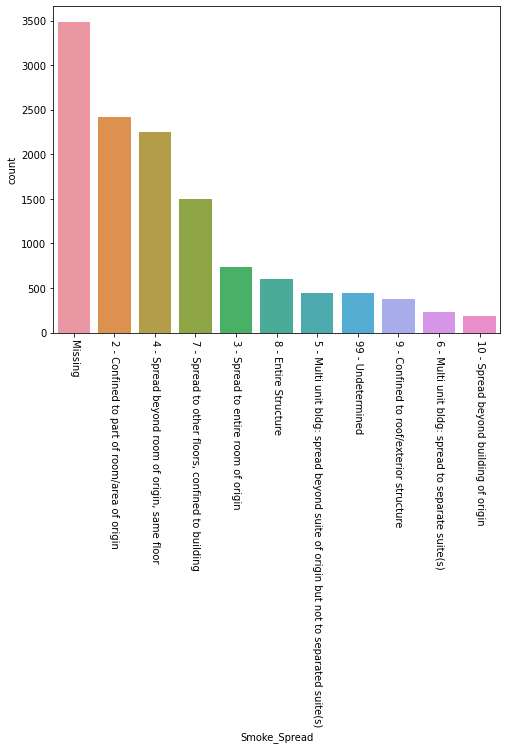

In [342]:
#Smoke_Spread
#Definition: A code and description assigned by the OFM to describe the spread of smoke during the fire.
print(fire_data.Smoke_Spread.describe())

#This is a categorical attribute with nominal data and 10 levels. The levels are:
print(fire_data.Smoke_Spread.unique())

print(fire_data.Smoke_Spread.value_counts(normalize=True, dropna=False))
#As with some other attributes that we have already encountered, about a quarter (27.5%, to be exact) of the observations are missing. As I have done with other attributes, rather than risking the introduction of bias into my models or data loss, I will create an additional level, "Missing", to flag that the data is missing.
fire_data.Smoke_Spread = fire_data.Smoke_Spread.fillna('Missing')

plt.figure(figsize=(8, 6))
sns.countplot(x='Smoke_Spread', data=fire_data, order = fire_data.Smoke_Spread.value_counts().index)
plt.xticks(rotation=-90)

print(fire_data.Smoke_Spread.value_counts(normalize=True))
#Other than missing data, the most common level in this attribute is "Confined to part of room/area of origin." (19%). 47% of the fires were recorded as having spread beyond to the room/area of origin.

#Convert to category dtype:
fire_data.Smoke_Spread = fire_data.Smoke_Spread.astype('category')
print(fire_data.Smoke_Spread.dtype)

count                                                 9203
unique                                                   7
top       8 - Not applicable - no sprinkler system present
freq                                                  5689
Name: Sprinkler_System_Operation, dtype: object
[nan '8 - Not applicable - no sprinkler system present'
 '9 - Activation/operation undetermined'
 '3 - Did not activate: fire too small to trigger system'
 '5 - Did not activate: reason unknown'
 '2 - Did not activate: remote from fire'
 '4 - Other reason for non activation/operation'
 '1 - Sprinkler system activated']
8 - Not applicable - no sprinkler system present          0.448412
NaN                                                       0.274612
2 - Did not activate: remote from fire                    0.104280
1 - Sprinkler system activated                            0.055884
9 - Activation/operation undetermined                     0.054386
3 - Did not activate: fire too small to trigger system    0.

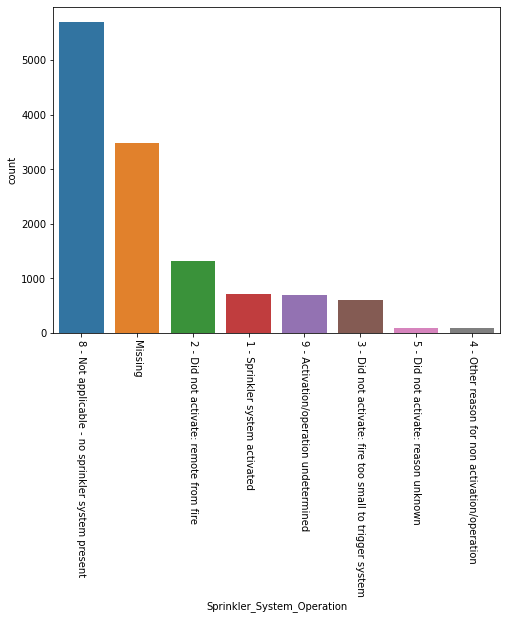

In [343]:
#Sprinkler_System_Operation
#Definition: A code and description assigned by the OFM to describe the functining of the sprinkler system during the fire.
print(fire_data.Sprinkler_System_Operation.describe())

#This is a categorical variable with nominal data. There are 7 levels in this attribute. They are:
print(fire_data.Sprinkler_System_Operation.unique())

print(fire_data.Sprinkler_System_Operation.value_counts(normalize=True, dropna=False))
#As with some other attributes that we have already encountered, about a quarter (27.5%, to be exact) of the observations are missing. As I have done with other attributes, rather than risking the introduction of bias into my models or data loss, I will create an additional level, "Missing", to flag that the data is missing.
fire_data.Sprinkler_System_Operation = fire_data.Sprinkler_System_Operation.fillna('Missing')

plt.figure(figsize=(8, 6))
sns.countplot(x='Sprinkler_System_Operation', data=fire_data, order = fire_data.Sprinkler_System_Operation.value_counts().index)
plt.xticks(rotation=-90)

print(fire_data.Sprinkler_System_Operation.value_counts(normalize=True, dropna=False))
#77.7% of the data in this attribute is either missing, not applicable, or undetermined.

#Convert to category dtype:
fire_data.Sprinkler_System_Operation = fire_data.Sprinkler_System_Operation.astype('category')
print(fire_data.Sprinkler_System_Operation.dtype)

count                        9203
unique                          4
top       3 - No sprinkler system
freq                         5428
Name: Sprinkler_System_Presence, dtype: object
[nan, '3 - No sprinkler system', '9 - Undetermined', '2 - Partial sprinkler system present', '1 - Full sprinkler system present']
3 - No sprinkler system                 0.427840
NaN                                     0.274612
9 - Undetermined                        0.114606
1 - Full sprinkler system present       0.110901
2 - Partial sprinkler system present    0.072042
Name: Sprinkler_System_Presence, dtype: float64
3 - No sprinkler system                 0.589808
9 - Undetermined                        0.157992
1 - Full sprinkler system present       0.152885
2 - Partial sprinkler system present    0.099315
Name: Sprinkler_System_Presence, dtype: float64
category


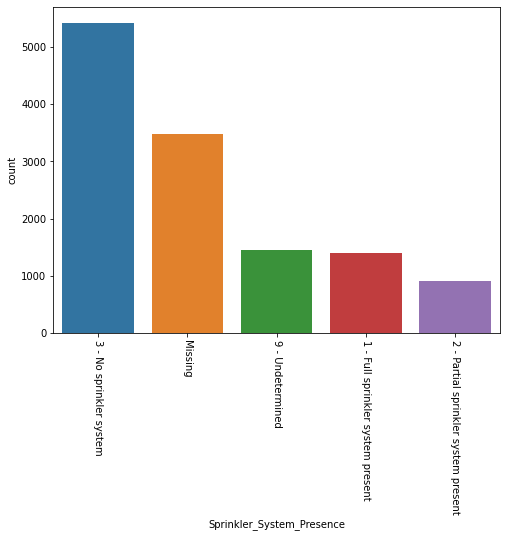

In [344]:
#Sprinkler_System_Presence
#Definition: A code and description assigned by the OFM to describe the presence of a sprinkler system during the fire.
print(fire_data.Sprinkler_System_Presence.describe())

#This is a categorical attribute with nominal data and 4 levels. The levels are:
print(list(fire_data.Sprinkler_System_Presence.unique()))

print(fire_data.Sprinkler_System_Presence.value_counts(normalize=True, dropna=False))
#As with some other attributes that we have already encountered, about a quarter (27.5%, to be exact) of the observations are missing. As I have done with other attributes, rather than risking the introduction of bias into my models or data loss, I will create an additional level, "Missing", to flag that the data is missing.
fire_data.Sprinkler_System_Presence = fire_data.Sprinkler_System_Presence.fillna('Missing')

plt.figure(figsize=(8, 6))
sns.countplot(x='Sprinkler_System_Presence', data=fire_data, order = fire_data.Sprinkler_System_Presence.value_counts().index)
plt.xticks(rotation=-90)

print(fire_data[fire_data.Sprinkler_System_Presence != 'Missing'].Sprinkler_System_Presence.value_counts(normalize=True))
#In 59% of the fires where the sprinkler data is not missing, there was no sprinkler system present.

#Convert to category dtype:
fire_data.Sprinkler_System_Presence = fire_data.Sprinkler_System_Presence.astype('category')
print(fire_data.Sprinkler_System_Presence.dtype)

count                                                 12687
unique                                                    8
top       3 - Fire with smoke showing only - including v...
freq                                                   3326
Name: Status_of_Fire_On_Arrival, dtype: object
['3 - Fire with smoke showing only - including vehicle, outdoor fires', '1 - Fire extinguished prior to arrival', '4 - Flames showing from small area (one storey or less, part of a vehicle, outdoor)', '7 - Fully involved (total structure, vehicle, spreading outdoor fire)', '2 - Fire with no evidence from street', '9 - Unclassified', '5 - Flames showing from large area (more than one storey, large area outdoors)', '8 - Exposure involved']
3 - Fire with smoke showing only - including vehicle, outdoor fires                    0.262158
1 - Fire extinguished prior to arrival                                                 0.257981
2 - Fire with no evidence from street                                          

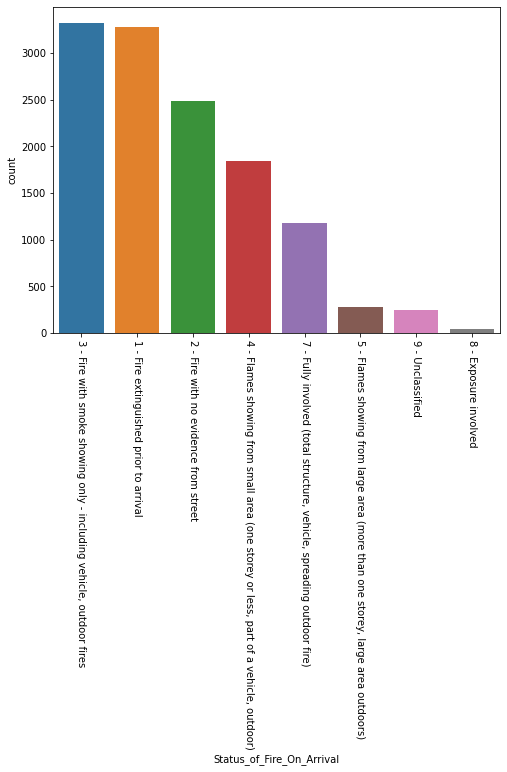

In [345]:
#Status_of_Fire_On_Arrival
#Definition: A code and description assigned by the OFM to describe the status of the fire upon the firefighters' arrival.
print(fire_data.Status_of_Fire_On_Arrival.describe())

#This is a categorical attribute with nominal data and 8 levels. The levels are:
print(list(fire_data.Status_of_Fire_On_Arrival.unique()))

plt.figure(figsize=(8, 6))
sns.countplot(x='Status_of_Fire_On_Arrival', data=fire_data, order = fire_data.Status_of_Fire_On_Arrival.value_counts().index)
plt.xticks(rotation=-90)
#The barplot shows some variance in the fire statuses on arrival, but generally speaking we can see that the majority of fires do not at first glance appear severe.

print(fire_data.Status_of_Fire_On_Arrival.value_counts(normalize=True))
#71.6% of fires had either been extinguished upon arrival, were not visible from the street, or were showing smoke only as opposed to flames.

#Convert to category dtype:
fire_data.Status_of_Fire_On_Arrival = fire_data.Status_of_Fire_On_Arrival.astype('category')
print(fire_data.Status_of_Fire_On_Arrival.dtype)

In [346]:
#TFS_Alarm_Time
#Definition: The date and time that TFS was alerted to the fire.
print(fire_data.TFS_Alarm_Time.describe())

#This attribute was imported as a string, it must be convert to a datetime format.
fire_data.TFS_Alarm_Time = pd.to_datetime(fire_data.TFS_Alarm_Time)
print(fire_data.TFS_Alarm_Time.dtype)
print(fire_data.TFS_Alarm_Time.describe())

count                   12687
unique                  12687
top       2011-10-08T15:47:46
freq                        1
Name: TFS_Alarm_Time, dtype: object
datetime64[ns]
count                   12687
unique                  12687
top       2016-06-30 22:10:53
freq                        1
first     2011-01-01 00:06:48
last      2017-12-31 23:21:07
Name: TFS_Alarm_Time, dtype: object


In [347]:
#TFS_Arrival_Time
#Definition: The date and time that the first TFS unit arrived at the incident.
print(fire_data.TFS_Arrival_Time.describe())

#The attribute was imported as a string, it must be converted to a datetime format.
fire_data.TFS_Arrival_Time = pd.to_datetime(fire_data.TFS_Arrival_Time)
print(fire_data.TFS_Arrival_Time.dtype)
print(fire_data.TFS_Arrival_Time.describe())

count                   12687
unique                  12687
top       2011-07-26T14:22:55
freq                        1
Name: TFS_Arrival_Time, dtype: object
datetime64[ns]
count                   12687
unique                  12687
top       2015-06-23 10:35:48
freq                        1
first     2011-01-01 00:12:54
last      2017-12-31 23:24:59
Name: TFS_Arrival_Time, dtype: object


In [348]:
#TFS_Firefighter_Casualties
#Definition: The number of TFS firefighter casualties caused by the fire. 
#This is one of the attributes from which the class attribute was derived, so has become redundant with its information contained in the class variable.
del fire_data['TFS_Firefighter_Casualties']

count     12687
unique        2
top           0
freq      11662
Name: human_risk, dtype: int64
0    0.919209
1    0.080791
Name: human_risk, dtype: float64


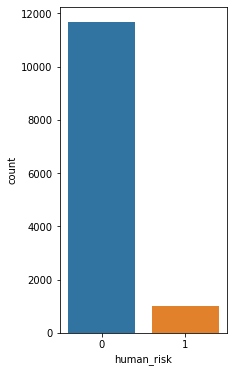

In [349]:
#human_risk
#Definition: this is the class variable. If the fire caused human casualties (civilian or firefighter), or has resulted in civilians being rescued by firefighters, it will have the value of 1; otherwise, it will have the value of zero.
print(fire_data.human_risk.describe())

plt.figure(figsize=(3, 6))
sns.countplot(x='human_risk', data=fire_data, order = fire_data.human_risk.value_counts().index)

print(fire_data.human_risk.value_counts(normalize=True))
#The class variable is imbalanced: only in approximately 8.1% of cases is it true, meaning that in 91.9% cases it is false. This is a class imbalance of approximately 12:1. 

New time variables

There are 5 datetime attributes that represent a specific stage in a fire incident. These attributes are, in order:

TFS_Alarm_Time<br>
TFS_Arrival_Time<br>
Ext_agent_app_or_defer_time<br>
Fire_Under_Control_Time<br>
Last_TFS_Unit_Clear_Time<br>

I am interested in the response time, which I define as the time between the TFS_Alarm_Time and TFS_Arrival_Time, and in the time it takes to fight the fire, which I define as the time between the TFS_Arrival_Time and the Fire_Under_Control_Time. I will extract the time, in seconds, for these two intervals.

count    12686.000000
mean      1067.445846
std       1953.457173
min         19.000000
25%        445.000000
50%        662.000000
75%       1050.000000
max      79158.000000
Name: firefighting_time, dtype: float64
1
658.0
(array([12442]),)
0.093
0.8


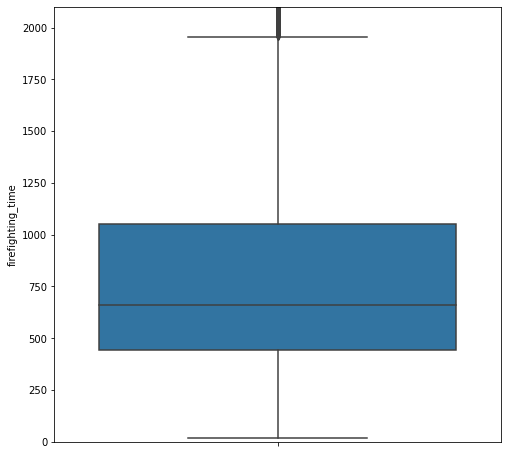

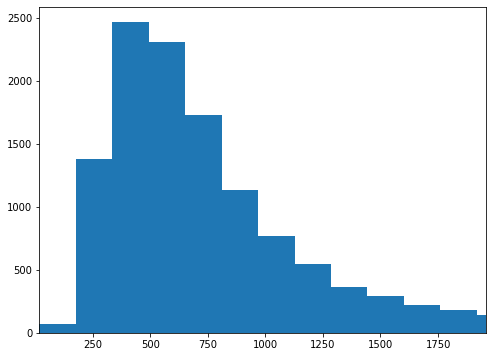

In [350]:
#firefighting time

#Create attribute:
fire_data['firefighting_time'] = (fire_data.Fire_Under_Control_Time - fire_data.TFS_Alarm_Time).dt.seconds

print(fire_data.firefighting_time.describe())
print(fire_data.firefighting_time.isna().sum())
#We can see an NA value here, because of the NA value we observed in the Fire_Under_Control_Time attribute. We can fill in this NA value using the median of the firefighting_time attribute. Admittedly, using the median is usually not the best strategy for replacing values, but for one NA only as in this case it is sufficient.

#Find median firefighting time:
print(stat.median(fire_data.firefighting_time))
#Find index of NA value in Fire_Under_Control_Time attribute:
print(np.where(fire_data.Fire_Under_Control_Time.isna()))
#Index of NA is 12442. Will fill NA in Fire_Under_Control_Time with TFS_Alarm_Time + median of firefighting time.
fire_data.Fire_Under_Control_Time = fire_data.Fire_Under_Control_Time.fillna(fire_data.TFS_Alarm_Time[12442] + datetime.timedelta(seconds=stat.median(fire_data.firefighting_time)))
#Now, filling in NA value for firefighting_time with the median.
fire_data.firefighting_time = fire_data.firefighting_time.fillna(stat.median(fire_data.firefighting_time))

plt.figure(figsize=(8, 8))
plt.ylim(0, 2100)
sns.boxplot(y="firefighting_time", data=fire_data)

ft_Q1 = fire_data.firefighting_time.quantile(0.25)
ft_Q3 = fire_data.firefighting_time.quantile(0.75)
ft_IQR = ft_Q3 - ft_Q1
ft_upper = ft_Q3 + 1.5 * ft_IQR
ft_lower = ft_Q1 - 1.5 * ft_IQR
print(round(sum((fire_data.firefighting_time < ft_lower) | (fire_data.firefighting_time > ft_upper)) / len(fire_data), 3))
#9.3% of the observations are mathematical outliers here. This data is not likely to be normally distributed with no many outliers.

plt.figure(figsize=(8, 6))
plt.xlim(min(fire_data.firefighting_time), ft_upper)
plt.hist(fire_data.firefighting_time, bins = 500)

print(round(sum(fire_data.firefighting_time <= 1200) / len(fire_data), 3))

#Confirming the findings of the boxplot, we can see that the data is not normally distributed: the data has a pronounced right tail. About 80% of fires are declared under control within 20 minutes of TFS being alerted, though there are significant outliers, including one fire that took over a day to subdue.
#There is no indication that the outliers represent dirty or noisy data - some fires are simply more fierce and require more time to fight. I can find no reason to delete these observations.

count    12687.000000
mean       317.198471
std        374.492406
min          1.000000
25%        251.000000
50%        302.000000
75%        362.000000
max      40942.000000
Name: response_time, dtype: float64
302.0
0
3041    40942
3237     1625
Name: response_time, dtype: int64
count    12686.000000
mean       313.996137
std        100.702274
min          1.000000
25%        251.000000
50%        302.000000
75%        362.000000
max       1625.000000
Name: response_time, dtype: float64
0.034


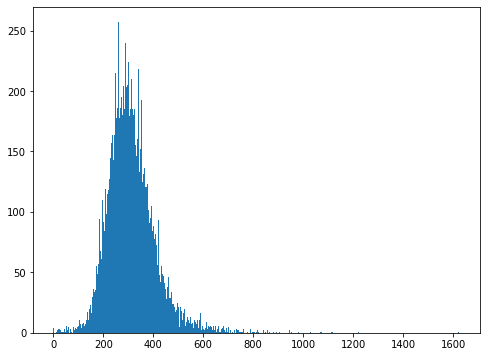

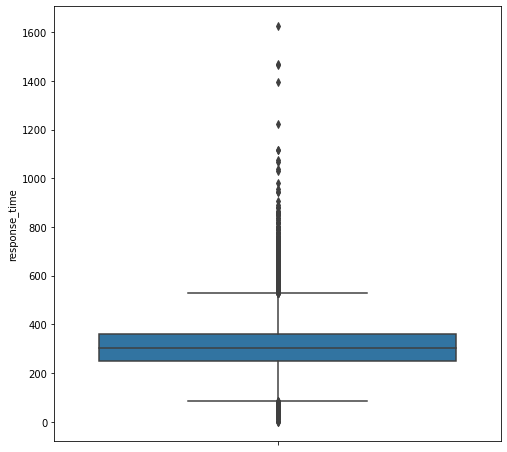

In [351]:
#response_time

#Create attribute:
fire_data['response_time'] = (fire_data.TFS_Arrival_Time - fire_data.TFS_Alarm_Time).dt.seconds

print(fire_data.response_time.describe())
print(np.median(fire_data.response_time))
print(fire_data.response_time.isna().sum())
#I immediately notice that the mode and median are almost the same. The maximum here, 40942 seconds, seems like incorrect data or highly anomalous - it simply is not possible that it took firefighters 11 hours to respond to a fire when the median response time is around 5 minutes.

print(fire_data.response_time.sort_values(ascending=False).head(2))
#The second longest response time works out to 27 minutes, so the maximum here truly is a freak outlier and will be deleted.
fire_data = fire_data.drop([3041], axis=0)

print(fire_data.response_time.describe())

plt.figure(figsize=(8, 6))
plt.hist(fire_data.response_time, bins = 500)
#Sure enough, the distribution of response_time appears close to being normally distributed, though with a slight right tail.

plt.figure(figsize=(8, 8))
sns.boxplot(y="response_time", data=fire_data)

rt_Q1 = fire_data.response_time.quantile(0.25)
rt_Q3 = fire_data.response_time.quantile(0.75)
rt_IQR = rt_Q3 - rt_Q1
rt_upper = rt_Q3 + 1.5 * rt_IQR
rt_lower = rt_Q1 - 1.5 * rt_IQR
print(round(sum((fire_data.response_time < rt_lower) | (fire_data.response_time > rt_upper)) / len(fire_data), 3))
#There are mathematical outliers in this attribute as well, though fewer compared to the firefighting_time attribute - only 3.4% of the observations in this attribute are outliers, compared to ~9% for the firefighting_time attribute. Other than the outlier that was already removed, there is no indication that these outliers represent dirty or noisy data - some fires simply require greater resources and time. I can find no reason to delete these observations.

Additional temporal attributes

Having analyzed the datetime data in my analysis of the Ex_agent_app_of_defer_time attribute, I believe that it will be interesting and potentially useful to isolate the year, month, season and time of day broken out into individual attributes. I will use the TFS_Alarm_Time as the basis for these new attributes. All these attributes are categorical, ordinal, and cyclic. 

In [352]:
#Extract year
fire_data['Year'] = pd.DatetimeIndex(fire_data.TFS_Alarm_Time).year.astype('category')

#Extract month
fire_data['Month'] = pd.DatetimeIndex(fire_data.TFS_Alarm_Time).month.astype('category')

#Extract day
fire_data['Day'] = pd.DatetimeIndex(fire_data.TFS_Alarm_Time).day.astype('category')

#Extract day of week
fire_data['Day_of_Week'] = pd.DatetimeIndex(fire_data.TFS_Alarm_Time).dayofweek.astype('category')

#Extract hour
fire_data['Hour'] = pd.DatetimeIndex(fire_data.TFS_Alarm_Time).hour.astype('category')

#Group months together into seasons
fire_data['Season'] = np.where((fire_data.Month == 1) | (fire_data.Month == 2) | (fire_data.Month == 3), 'Winter', 
         np.where((fire_data.Month == 4) | (fire_data.Month == 5) | (fire_data.Month == 6), 'Spring', 
                  np.where((fire_data.Month == 7) | (fire_data.Month == 8) | (fire_data.Month == 9), 'Summer', 'Autumn')))
fire_data.Season = fire_data.Season.astype('category')

#Group hours into parts of day
tod_dict = {'afternoon': [8, 9, 10, 11, 12, 13, 14, 15], 
            'evening': [16, 17, 18, 19, 20, 21, 22, 23], 
            'morning': [0, 1, 2, 3, 4, 5, 6, 7]}
tod_dict_2 = {v: k for k, vv in tod_dict.items() for v in vv}
fire_data['time_of_day'] = fire_data.Hour.map(tod_dict_2)
fire_data.time_of_day = fire_data.time_of_day.astype('category')

Bivariate Analysis

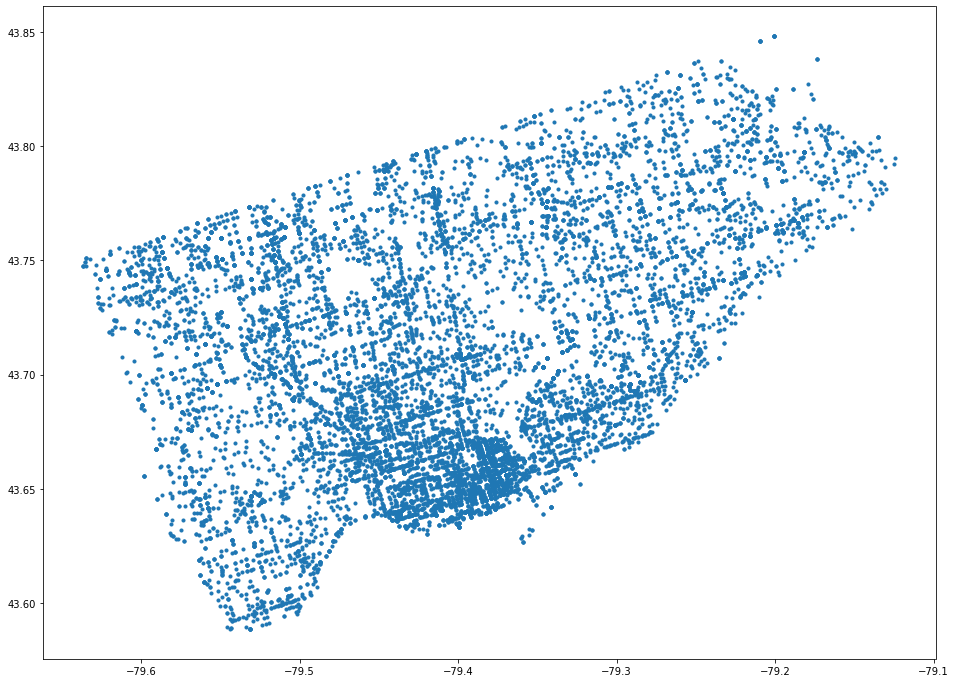

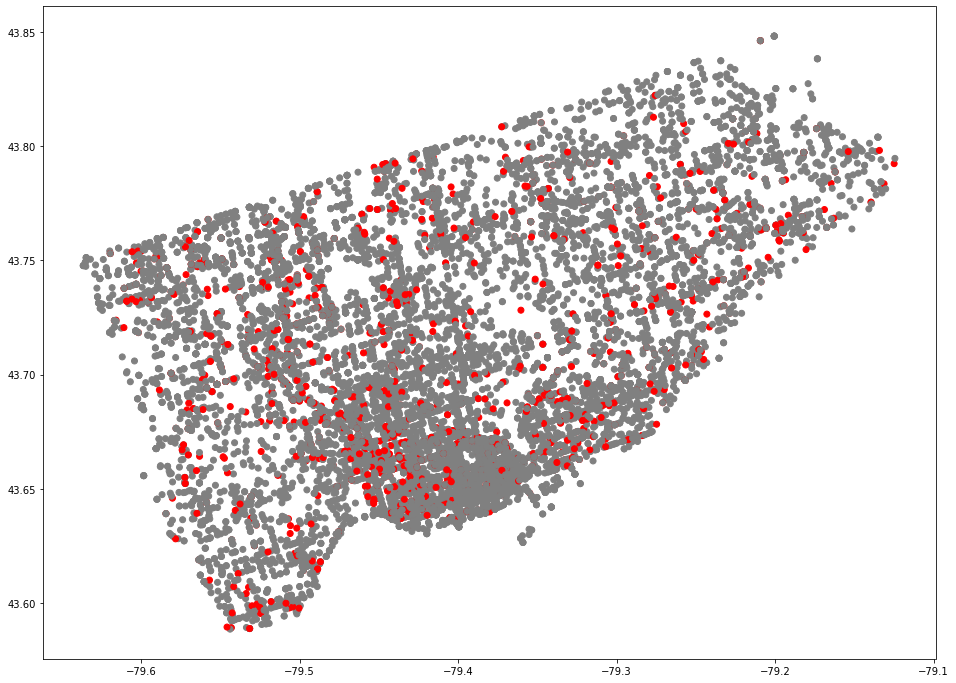

Text(0.5, 0, 'Fire by Property Types, by Ward')

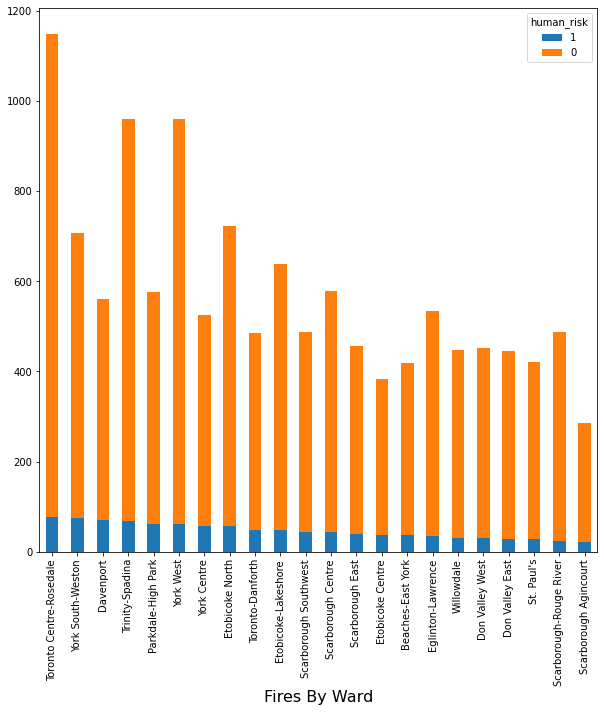

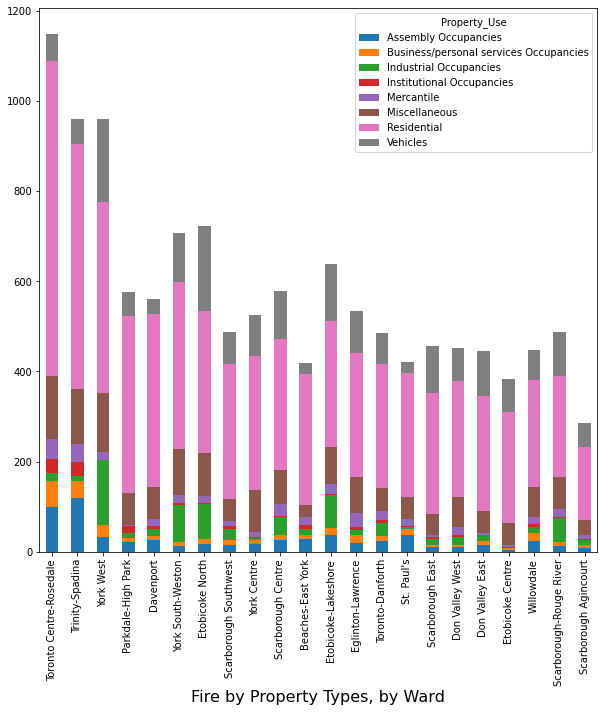

In [353]:
#Spatial analysis

plt.figure(figsize=(16, 12))
plt.scatter(fire_data.Longitude, fire_data.Latitude, s=np.pi*3)
plt.show()

#From the scatterplot, we can see visually that the density of fires varies considerably within the city, and that the densest concentration of fires is downtown. One can also see the outlines of major thoroughfares such as Queen, Bloor, Danforth, Yonge and others, which appear to have highest concentrations of fires than other parts of the city. 

#Looking at our class attribute, there do appear to be sectors in the city with a higher density of the riskest fires.
plt.figure(figsize=(16, 12))
plt.scatter(fire_data.Longitude, fire_data.Latitude, c=fire_data.human_risk, cmap=mpl.colors.ListedColormap(['grey', 'red']))
plt.show()

#But the areas with the highest number of high-risk fires don't necessarily correspond to the highest number of total fires.
plotgroup1 = fire_data.groupby(['Incident_Ward', 'human_risk']).size().reset_index().pivot(columns='Incident_Ward', index='human_risk', values=0).sort_index(ascending=False).unstack().unstack().sort_values(by=[1], ascending=False)
plotgroup1.plot(kind='bar', stacked=True, figsize=(10, 10)).set_xlabel('Fires By Ward', size=16)

#There is variance in the types of properties that experienced fires in the different parts of the city. While the two wards with the greatest number of fires recorded, Toronto-Rosedale and Trinity-Spadina, look proportionately very similar, the ward with the third greatest number of fires recorded, York Centre, is quite different. Comparing York Centre to Trinity-Spadina: York Centre has a greater number of vehicle fires, a greater number of industrial fires, fewer residential fires, and much fewer fires in assembly areas (bars, theatres, arenas, etc.)
plotgroup2 = fire_data.groupby(['Incident_Ward', 'Property_Use']).size().reset_index().pivot(columns='Property_Use', index='Incident_Ward', values=0).sort_values(by=['Residential'], ascending=False)
plotgroup2.plot(kind='bar', stacked=True, figsize=(10, 10)).set_xlabel('Fire by Property Types, by Ward', size=16)

Text(0, 0.5, 'Median Firefighting Time in Seconds')

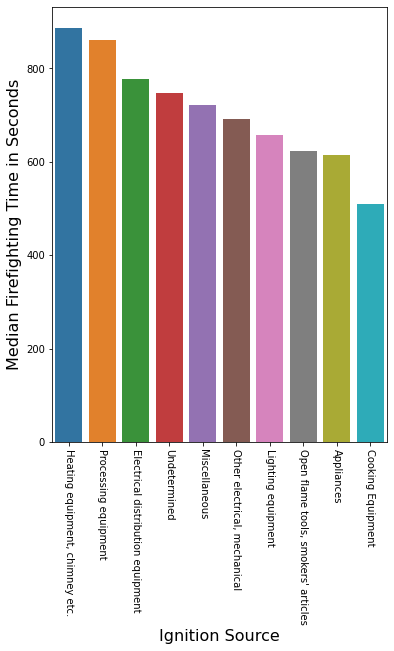

In [354]:
#Median firefighting time for Ignition source
time_ignition = fire_data.groupby(['Ignition_Source'])['firefighting_time'].aggregate(np.median).reset_index().sort_values('firefighting_time', ascending=False)
plt.figure(figsize=(6, 8))
sns.barplot(x="Ignition_Source", y="firefighting_time", data=fire_data, estimator=np.median, ci=None, order=time_ignition['Ignition_Source'])
plt.xticks(rotation=-90)
plt.xlabel("Ignition Source", fontsize=16)
plt.ylabel("Median Firefighting Time in Seconds", fontsize=16)
#The median firefighting time is highest for Heating Equipment/Chimney (e.g. heaters, fireplaces, chimneys), and Processing Equipment (e.g. incinerators, reactors, furnaces) - ignition sources that already operate on high heat. The lowest median firefighting time is for Cooking Equipment (ovens, microwaves, barbecues, fryers, toasters, etc.)

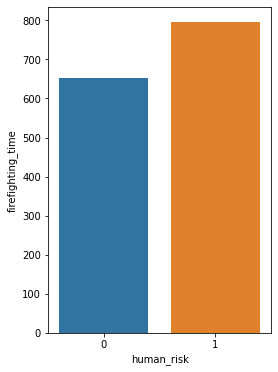

In [355]:
#Median firefighting time for class variable
plt.figure(figsize=(4, 6))
sns.barplot(x="human_risk", y="firefighting_time", data=fire_data, estimator=np.median, ci=None)
#We can see that the median firefighting time for fires in which humans were killed or rescued is around 150 seconds (2.5 minutes) more than fires in which humans were not killed or rescued.

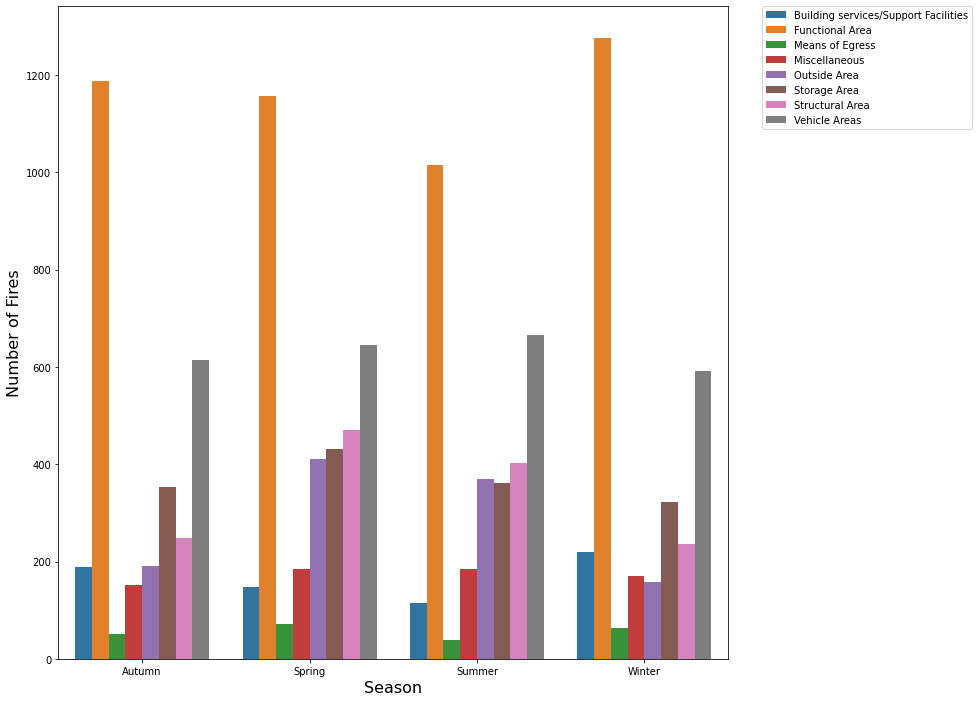

In [356]:
#Origin of Fire by Season
plt.figure(figsize=(12, 12))
sns.countplot(x="Season", hue="Area_of_Origin", data=fire_data)
plt.xlabel("Season", fontsize=16)
plt.ylabel("Number of Fires", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
#Indoor fires in Functional Areas (indoors) trend upward during the colder month, then drop as the weather becomes warmer. Outdoor fires, meanwhile, do the exact opposite: their frequency increase in the spring and summer, and drop as the weather gets colder.

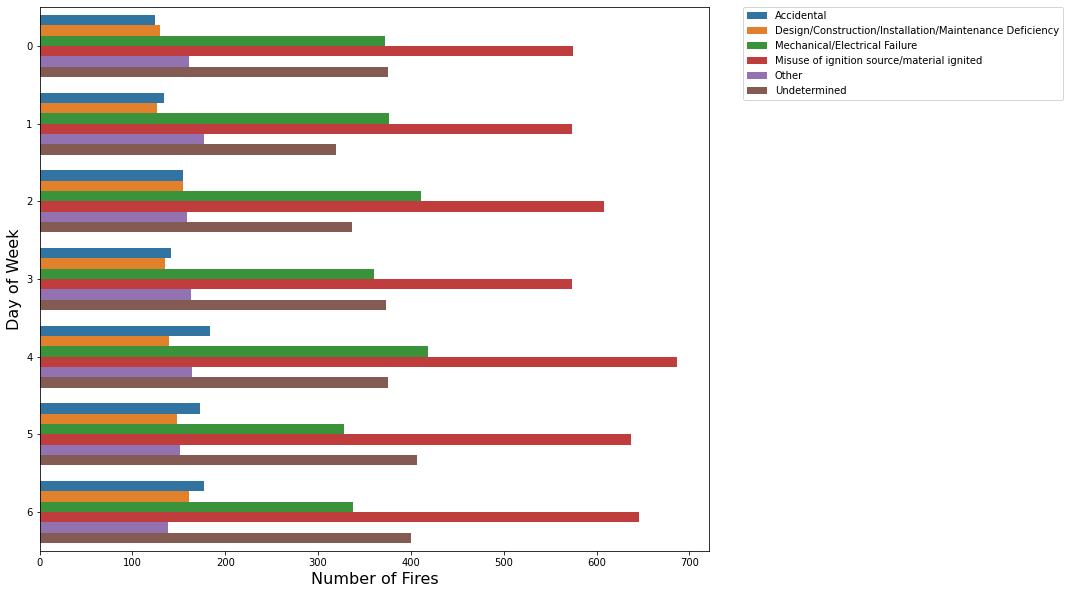

In [357]:
#Possible Cause of Fire by Day of the Week
plt.figure(figsize=(12, 10))
sns.countplot(y="Day_of_Week", hue="Possible_Cause", data=fire_data, orient='h')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Number of Fires", fontsize=16)
plt.ylabel("Day of Week", fontsize=16)
plt.show()
#There isn't much variance in terms of days of the week. The possible fire causes that are directly tied to human activity - Misuse of Ignition Source, Misuse of Material First Ignited, and Accidental - appear slightly more frequent on weekends (days 5 and 6) than during the week (days 0-4).

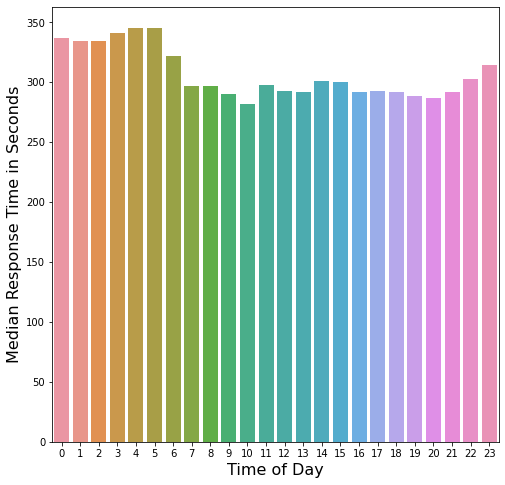

In [358]:
#Median response grouped by time of day.
plt.figure(figsize=(8, 8))
sns.barplot(x="Hour", y="response_time", data=fire_data, estimator=np.median, ci=None)
plt.xlabel("Time of Day", fontsize=16)
plt.ylabel("Median Response Time in Seconds", fontsize=16)
plt.show()
#Firefighters' median response time is at its worst late at night and early in the morning, from 11 PM until about 5 AM, when it begins to improve. Overall, response time is pretty consistent regardless of time of day.

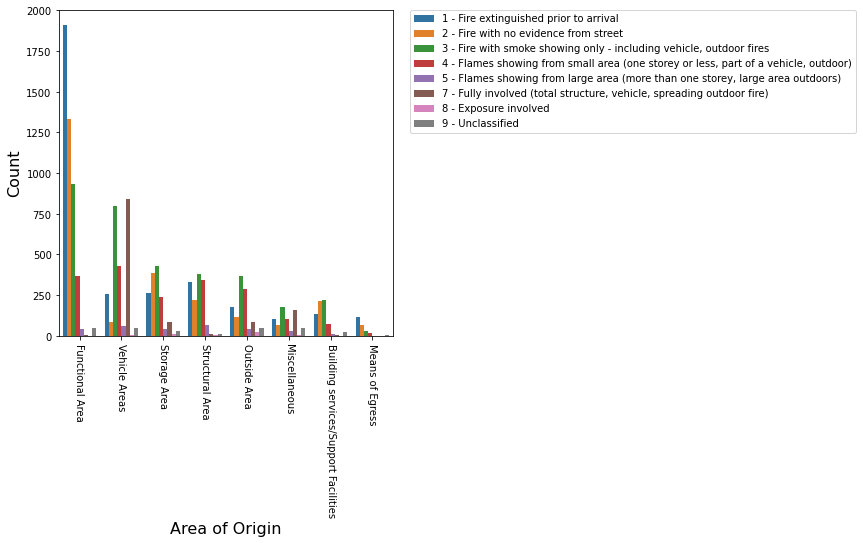

In [359]:
#Fires by Area of Origin and Status on Arrival
plt.figure(figsize=(6, 6))
sns.countplot(x="Area_of_Origin", hue="Status_of_Fire_On_Arrival", data=fire_data, order=fire_data['Area_of_Origin'].value_counts().index)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=-90)
plt.xlabel("Area of Origin", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.show()
#Jumping out immediately is the prominent block of purple for fires originating in vehicles. A much larger proportion of vehicle fires are already consuming the entire structure than for any other area of origin. This reflects the small size of most vehicles, as well as their flammability.

Removal of Redundant Attributes

In [360]:
#With year, month, day, day of week, hour, firefighting_time and response_time extracted into other attributes, the datetime fields are redundant and can be removed. I will preserve one: TFS_Alarm_Time, in the event that it is required for any purpose down the road.
del fire_data['Ext_agent_app_or_defer_time']
del fire_data['Fire_Under_Control_Time']
del fire_data['Last_TFS_Unit_Clear_Time']
del fire_data['TFS_Arrival_Time']

#There are several attributes that contain information about fires' geospatial distribution: Incident_Station_Area, Incident_Ward, and Latitude/Longitude. Of these Incident_Ward is the best arrtibute for my analysis, grouping as it does Toronto into 22 different sections. 
del fire_data['Incident_Station_Area']
del fire_data['Latitude']
del fire_data['Longitude']

Correlation Analysis

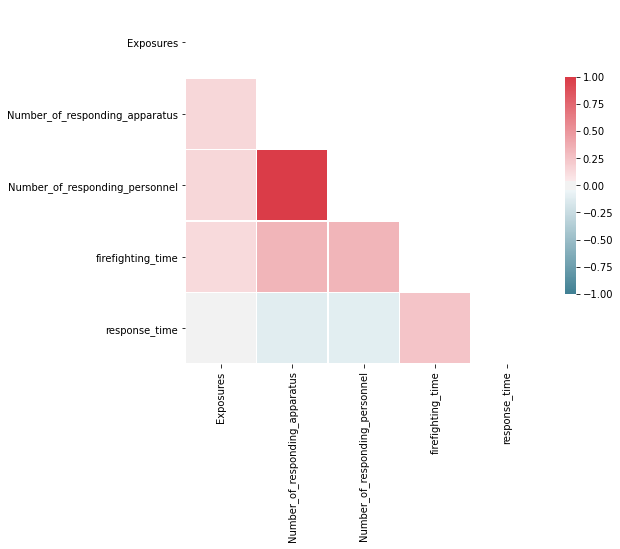

In [361]:
#I am using Spearman correlation for my numeric data, because none of the numerical attributes are evenly distributed but also because the attributes contain a lot of outliers.
cor_attr = fire_data[['Exposures', 'Number_of_responding_apparatus', 'Number_of_responding_personnel', 'firefighting_time', 'response_time']]
cor_matrix = cor_attr.corr(method='spearman')

mask = np.triu(np.ones_like(cor_matrix, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(8, 8))
sns.heatmap(cor_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

#The relationship between Number_of_responding_apparatus and Number_of_responding_personnel is close to perfectly correlated, which is logical given the way firefighters work (there are x firefighters per truck). To avoid multicollinearity, one of these two attributes should be removed - I select Number_of_responding_apparatus as it is characterized by a higher percentage of outliers. 
del fire_data['Number_of_responding_apparatus']

Chi-square test

In [362]:
from scipy.stats import chi2_contingency

print(chi2_contingency(np.array(pd.crosstab(fire_data.Area_of_Origin, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Building_Status, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Extent_Of_Fire, fire_data.human_risk)))[0:3])
#P-value > 0.05:
print(chi2_contingency(np.array(pd.crosstab(fire_data.Final_Incident_Type, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Fire_Alarm_System_Impact_on_Evacuation, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Fire_Alarm_System_Operation, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Fire_Alarm_System_Presence, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Ignition_Source, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Incident_Ward, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Initial_CAD_Event_Type, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Level_Of_Origin, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Material_First_Ignited, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Method_Of_Fire_Control, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Possible_Cause, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Property_Use, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Smoke_Alarm_at_Fire_Origin, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Failure, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Type, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Smoke_Spread, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Sprinkler_System_Operation, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Sprinkler_System_Presence, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Status_of_Fire_On_Arrival, fire_data.human_risk)))[0:3])
#P-value > 0.05:
print(chi2_contingency(np.array(pd.crosstab(fire_data.Year, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Month, fire_data.human_risk)))[0:3])
#P-value > 0.05:
print(chi2_contingency(np.array(pd.crosstab(fire_data.Day, fire_data.human_risk)))[0:3])
#P-value > 0.05:
print(chi2_contingency(np.array(pd.crosstab(fire_data.Day_of_Week, fire_data.human_risk)))[0:3])
#P-value > 0.05:
print(chi2_contingency(np.array(pd.crosstab(fire_data.Hour, fire_data.human_risk)))[0:3])
print(chi2_contingency(np.array(pd.crosstab(fire_data.Season, fire_data.human_risk)))[0:3])
#P-value > 0.05:
print(chi2_contingency(np.array(pd.crosstab(fire_data.time_of_day, fire_data.human_risk)))[0:3])
#There are six variables for which we cannot reject the null hypothesis of independence: Final_Incident_Type, year, day, day_of_week, hour, and time_of_day. The only variables extracted from a datetime attribute that proved not to be independent of the class variable are month and season. 

(540.5403382518593, 1.5314290875893162e-112, 7)
(333.33614707052857, 4.534757878769074e-68, 7)
(933.1042362930675, 4.456341026271865e-192, 12)
(3.6255504611185283, 0.05689874653336949, 1)
(377.7235579902316, 1.7148600530119392e-78, 6)
(291.16732906378616, 8.707699098240703e-62, 4)
(292.38595705238504, 4.754263262072401e-62, 4)
(255.25396916747746, 7.752443916358105e-50, 9)
(62.71290322340774, 4.919754729756257e-06, 21)
(263.0421359930301, 5.726396506753487e-48, 14)
(363.7927694209026, 1.875340719147613e-76, 5)
(487.54754698275855, 3.3003541368740903e-100, 8)
(25.21188956795624, 4.5607518745111833e-05, 4)
(144.9211668581099, 1.607843838009972e-29, 5)
(422.68843267326486, 3.239037925017963e-87, 7)
(297.17376769234625, 4.057397876714946e-62, 5)
(427.0326867469197, 1.1061655822840666e-84, 11)
(363.1506633487551, 2.315808445499443e-75, 6)
(465.6965571739797, 2.051746917540612e-97, 6)
(685.7902981071773, 7.047644199473651e-141, 10)
(370.32390090656463, 5.4747121576768724e-76, 7)
(368.1313782

k-Prototypes clustering

In [363]:
#Find the optimal number of clusters:
cost = []
for num_clusters in list(range(1,10)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(fire_data.drop(['TFS_Alarm_Time','human_risk'], axis=1), categorical=[0,1,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,27,28,29,30,31,32,33])
    cost.append(kproto.cost_)
plt.plot(cost)

kproto = KPrototypes(n_clusters=4, init='Cao', verbose=2)
clusters = kproto.fit_predict(fire_data.drop(['TFS_Alarm_Time','human_risk'], axis=1), categorical=[0,1,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,27,28,29,30,31,32,33])

# Print cluster centroids of the trained model.
print(kproto.cluster_centroids_)


Discretization and level reduction

Grouping categories comprising the bottom 15% of data into a category called "Other"



In [364]:
#Area_of_Origin
print(fire_data.Area_of_Origin.value_counts(normalize=True).cumsum())
fire_data.Area_of_Origin = fire_data.Area_of_Origin.map({'Functional Area': 'Functional Area', 
                                                         'Vehicle Areas': 'Vehicle Areas', 
                                                         'Storage Area': 'Storage Area', 
                                                         'Structural Area': 'Structural Area', 
                                                         'Outside Area': 'Other', 
                                                         'Miscellaneous': 'Other', 
                                                         'Building services/Support Facilities': 'Other', 
                                                         'Means of Egress': 'Other'}).astype('category')

Functional Area                         0.365442
Vehicle Areas                           0.563692
Storage Area                            0.679568
Structural Area                         0.786536
Outside Area                            0.875374
Miscellaneous                           0.929686
Building services/Support Facilities    0.982343
Means of Egress                         1.000000
Name: Area_of_Origin, dtype: float64


In [365]:
#Building_Status
print(fire_data.Building_Status.value_counts(normalize=True).cumsum())
fire_data.Building_Status = fire_data.Building_Status.map({'01 - Normal (no change)': 'Normal', 
                                                           'Missing': 'Other', 
                                                           '08 - Not Applicable': 'Other', 
                                                           '02 - Under Renovation': 'Other', 
                                                           '03 - Under Construction': 'Other', 
                                                           '09 - Undetermined': 'Other', 
                                                           '05 - Abandoned, vacant (long term)': 'Other', 
                                                           '04 - Under Demolition': 'Other'}).astype('category')

01 - Normal (no change)               0.635583
Missing                               0.909980
08 - Not Applicable                   0.950418
02 - Under Renovation                 0.982106
03 - Under Construction               0.991329
09 - Undetermined                     0.995901
05 - Abandoned, vacant (long term)    0.998975
04 - Under Demolition                 1.000000
Name: Building_Status, dtype: float64


In [366]:
#Exposures
#I will turn this into a yes/no categorical variable
fire_data.Exposures = np.where(fire_data.Exposures == 0, 'No', 'Yes')
fire_data.Exposures = fire_data.Exposures.astype('category')

In [367]:
#Extent_Of_Fire
print(fire_data.Extent_Of_Fire.value_counts(normalize=True).cumsum())
fire_data.Extent_Of_Fire = fire_data.Extent_Of_Fire.map({'1 - Confined to object of origin': 'Confined to object of origin', 
                                                         'Missing': 'Missing', 
                                                         '2 - Confined to part of room/area of origin': 'Other', 
                                                         '3 - Spread to entire room of origin': 'Other', 
                                                         '4 - Spread beyond room of origin, same floor': 'Other', 
                                                         '9 - Confined to roof/exterior structure': 'Other', 
                                                         '7 - Spread to other floors, confined to building': 'Other', 
                                                         '11 - Spread beyond building of origin, resulted in exposure fire(s)': 'Other', 
                                                         '8 - Entire Structure': 'Other', 
                                                         '99 - Undetermined': 'Other', 
                                                         '10 - Spread beyond building of origin': 'Other', 
                                                         '5 - Multi unit bldg: spread beyond suite of origin but not to separated suite(s)': 'Other', 
                                                         '6 - Multi unit bldg: spread to separate suite(s)': 'Other'}).astype('category')

1 - Confined to object of origin                                                    0.332965
Missing                                                                             0.607520
2 - Confined to part of room/area of origin                                         0.871433
3 - Spread to entire room of origin                                                 0.902964
4 - Spread beyond room of origin, same floor                                        0.931893
9 - Confined to roof/exterior structure                                             0.954596
7 - Spread to other floors, confined to building                                    0.972095
11 - Spread beyond building of origin, resulted in exposure fire(s)                 0.979978
8 - Entire Structure                                                                0.986048
99 - Undetermined                                                                   0.991566
10 - Spread beyond building of origin                                 

In [368]:
#Final_Incident_Type
print(fire_data.Final_Incident_Type.value_counts(normalize=True).cumsum())
#Cannot be further collapsed

01 - Fire                                                            0.992669
02 - Explosion (including during Fire, excluding Codes 3 & 11-13)    1.000000
Name: Final_Incident_Type, dtype: float64


In [369]:
#Fire_Alarm_System_Impact_on_Evacuation
print(fire_data.Fire_Alarm_System_Impact_on_Evacuation.value_counts(normalize=True).cumsum())
fire_data.Fire_Alarm_System_Impact_on_Evacuation = fire_data.Fire_Alarm_System_Impact_on_Evacuation.map({'Not Applicable': 'Not Applicable', 
                                                                                                         'Missing': 'Missing', 
                                                                                                         '1 - All persons (at risk of injury) evacuated as a result of hearing fire alarm system': 'All persons evacuated', 
                                                                                                         '9 - Undetermined': 'Other', 
                                                                                                         '2 - Some persons (at risk) evacuated as a result of hearing fire alarm system': 'Other', 
                                                                                                         '3 - No one (at risk) evacuated as a result of hearing fire alarm system': 'Other', 
                                                                                                         '4 - Fire Alarm system operated but failed to alert occupant(s)': 'Other'}).astype('category')

Not Applicable                                                                            0.368359
Missing                                                                                   0.642913
1 - All persons (at risk of injury) evacuated as a result of hearing fire alarm system    0.771638
9 - Undetermined                                                                          0.876005
2 - Some persons (at risk) evacuated as a result of hearing fire alarm system             0.955699
3 - No one (at risk) evacuated as a result of hearing fire alarm system                   0.997478
4 - Fire Alarm system operated but failed to alert occupant(s)                            1.000000
Name: Fire_Alarm_System_Impact_on_Evacuation, dtype: float64


In [370]:
#Fire_Alarm_System_Operation
print(fire_data.Fire_Alarm_System_Operation.value_counts(normalize=True).cumsum())
fire_data.Fire_Alarm_System_Operation = fire_data.Fire_Alarm_System_Operation.map({'1 - Fire alarm system operated': 'Fire alarm system operated', 
                                                                                   'Missing': 'Missing', 
                                                                                   '8 - Not applicable (no system)': 'Not Applicable', 
                                                                                   '9 - Fire alarm system operation undetermined': 'Other', 
                                                                                   '2 - Fire alarm system did not operate': 'Other'}).astype('category')

1 - Fire alarm system operated                  0.288192
Missing                                         0.562746
8 - Not applicable (no system)                  0.814678
9 - Fire alarm system operation undetermined    0.907772
2 - Fire alarm system did not operate           1.000000
Name: Fire_Alarm_System_Operation, dtype: float64


In [371]:
#Fire_Alarm_System_Presence
print(fire_data.Fire_Alarm_System_Presence.value_counts(normalize=True).cumsum())
fire_data.Fire_Alarm_System_Presence = fire_data.Fire_Alarm_System_Presence.map({'1 -  Fire alarm system present': 'Fire alarm system present', 
                                                                                 'Missing': 'Missing', 
                                                                                 '8 - Not applicable (bldg not classified by OBC OR detached/semi/town home)': 'Not Applicable', 
                                                                                 '2 - No Fire alarm system': 'Other', 
                                                                                 '9 - Undetermined': 'Other'}).astype('category')

1 -  Fire alarm system present                                                0.399890
Missing                                                                       0.674444
8 - Not applicable (bldg not classified by OBC OR detached/semi/town home)    0.799937
2 - No Fire alarm system                                                      0.917862
9 - Undetermined                                                              1.000000
Name: Fire_Alarm_System_Presence, dtype: float64


In [372]:
#Ignition_Source
print(fire_data.Ignition_Source.value_counts(normalize=True).cumsum())
fire_data.Ignition_Source = fire_data.Ignition_Source.map({'Undetermined': 'Undetermined', 
                                                           'Cooking Equipment': 'Cooking Equipment', 
                                                           "Open flame tools, smokers' articles": "Open flame tools, smokers' articles", 
                                                           'Other electrical, mechanical': 'Other electrical, mechanical', 
                                                           'Electrical distribution equipment': 'Electrical distribution equipment', 
                                                           'Miscellaneous': 'Other', 
                                                           'Appliances': 'Other', 
                                                           'Heating equipment, chimney etc.': 'Other', 
                                                           'Lighting equipment': 'Other', 
                                                           'Processing equipment': 'Other'}).astype('category')

Undetermined                           0.270771
Cooking Equipment                      0.466183
Open flame tools, smokers' articles    0.618241
Other electrical, mechanical           0.749330
Electrical distribution equipment      0.842898
Miscellaneous                          0.896815
Appliances                             0.929450
Heating equipment, chimney etc.        0.960586
Lighting equipment                     0.991329
Processing equipment                   1.000000
Name: Ignition_Source, dtype: float64


In [373]:
#Incident Ward
#Will collapse using business logic - will group into city boroughs: Old Toronto, East York, Scarborough, North York, York, Etobicoke

#To do this, it is necessary to go back to the original data, as the it is easier to map borough from the 44 wards as opposed to the 22 condensed ones.
fire_data_2 = pd.read_csv('https://raw.githubusercontent.com/terrygitersos/CKME136/master/Data/Original%20Fire%20Incidents%20Data.csv')
ward = fire_data_2.Incident_Ward.drop([3041], axis=0)
ward.loc[726, 2595, 3883, 4795, 5211, 6110] = 1.0
ward.loc[929, 3535, 4336, 6060] = 2.0
ward.loc[169, 758, 814, 837, 2512, 2624, 2744, 3064, 4341, 7003, 8194, 8600] = 3.0
ward.loc[7062, 7079] = 5.0
ward.loc[1674, 5410] = 6.0
ward.loc[753, 1142, 2375, 4555, 6057, 12024] = 7.0
ward.loc[455, 968, 1040, 2623, 3459, 8917] = 8.0
ward.loc[1455, 6425, 7215, 9696] = 10.0
ward.loc[6737, 10751] = 11.0
ward.loc[1700] = 12.0
ward.loc[3389] = 15.0
ward.loc[3631, 4619] = 18.0
ward.loc[4040, 4244] = 19.0
ward.loc[12005] = 22.0
ward.loc[1547, 11850] = 23.0
ward.loc[1426, 2980, 3059, 3278, 4502, 6835, 9294, 12091] = 24.0
ward.loc[12369] = 28.0
ward.loc[1328, 8377] = 29.0
ward.loc[8695] = 31.0
ward.loc[2846] = 32.0
ward.loc[7438] = 35.0
ward.loc[4370] = 38.0
ward.loc[12200] = 39.0
ward.loc[986, 11156] = 41.0
ward.loc[2, 3895, 12661] = 44.0

fire_data.Incident_Ward = ward
ward_dict = {'Etobicoke': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0], 
             'Scarborough': [35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0], 
             'North York': [7.0, 8.0, 9.0, 10.0, 15.0, 16.0, 23.0, 24.0, 25.0, 33.0, 34.0], 
             'York': [11.0, 12.0, 17.0, 21.0], 
             'East York': [26.0, 29.0, 31.0],
             'Old Toronto': [13.0, 14.0, 18.0, 19.0, 20.0, 22.0, 27.0, 28.0, 30.0, 32.0]}       
ward_dict_2 = {v: k for k, vv in ward_dict.items() for v in vv}
fire_data.Incident_Ward = ward.map(ward_dict_2).astype('category')

In [374]:
#Initial_CAD_Event_Type
print(fire_data.Initial_CAD_Event_Type.value_counts(normalize=True).cumsum())
fire_data.Initial_CAD_Event_Type = fire_data.Initial_CAD_Event_Type.map({'Fire Event Type': 'Fire Event Type', 
                                                                         'Vehicle Fire Event': 'Other', 
                                                                         'Fire Alarm Event Type': 'Other', 
                                                                         'Vehicle Accident Responses': 'Other', 
                                                                         'Call Check': 'Other', 
                                                                         'Medical Event': 'Other', 
                                                                         'Natural Gas Event': 'Other', 
                                                                         'Hazardous Materials Event': 'Other', 
                                                                         'Island /BBCCA Events': 'Other', 
                                                                         'Wires Down': 'Other', 
                                                                         'Carbon Monoxide Event': 'Other', 
                                                                         'Water Problem': 'Other', 
                                                                         'Police Assist Event': 'Other', 
                                                                         'Rescue Event': 'Other', 
                                                                         'Lake Events': 'Other'}).astype('category')

Fire Event Type               0.672395
Vehicle Fire Event            0.853145
Fire Alarm Event Type         0.979347
Vehicle Accident Responses    0.985969
Call Check                    0.992433
Medical Event                 0.994009
Natural Gas Event             0.995507
Hazardous Materials Event     0.996689
Island /BBCCA Events          0.997793
Wires Down                    0.998818
Carbon Monoxide Event         0.999369
Water Problem                 0.999685
Police Assist Event           0.999842
Rescue Event                  0.999921
Lake Events                   1.000000
Name: Initial_CAD_Event_Type, dtype: float64


In [375]:
#Level_Of_Origin
print(fire_data.Level_Of_Origin.value_counts(normalize=True).cumsum())
fire_data.Level_Of_Origin = fire_data.Level_Of_Origin.map({'Ground floor': 'Ground floor', 
                                                           'Missing': 'Missing', 
                                                           'Upper floors': 'Upper floors', 
                                                           'Basement': 'Other', 
                                                           'Not applicable': 'Other', 
                                                           'Other': 'Other'}).astype('category')

Ground floor      0.282910
Missing           0.557465
Upper floors      0.825162
Basement          0.941274
Not applicable    0.973672
Other             1.000000
Name: Level_Of_Origin, dtype: float64


In [376]:
#Material_First_Ignited
print(fire_data.Material_First_Ignited.value_counts(normalize=True).cumsum())
fire_data.Material_First_Ignited = fire_data.Material_First_Ignited.map({'Other Objects': 'Other', 
                                                                         'Undetermined': 'Undetermined', 
                                                                         'Materials': 'Materials', 
                                                                         'Flammable, combustible liquids': 'Flammable, combustible liquids', 
                                                                         'Building Component': 'Building Component', 
                                                                         'Miscellaneous': 'Other', 
                                                                         'Soft goods, wearing apparel': 'Other', 
                                                                         'Furniture': 'Other', 
                                                                         'Gases': 'Other'}).astype('category')

Other Objects                     0.302854
Undetermined                      0.454359
Materials                         0.586158
Flammable, combustible liquids    0.698171
Building Component                0.786300
Miscellaneous                     0.870329
Soft goods, wearing apparel       0.935204
Furniture                         0.989437
Gases                             1.000000
Name: Material_First_Ignited, dtype: float64


In [377]:
#Method_Of_Fire_Control
print(fire_data.Method_Of_Fire_Control.value_counts(normalize=True).cumsum())
fire_data.Method_Of_Fire_Control = fire_data.Method_Of_Fire_Control.map({'1 - Extinguished by fire department': 'Extinguished by fire department', 
                                                                         '3 - Extinguished by occupant': 'Other', 
                                                                         '4 - Fire self extinguished': 'Other', 
                                                                         '2 - Extinguished by automatic system': 'Other', 
                                                                         '5 - Action taken unclassified': 'Other'}).astype('category')

1 - Extinguished by fire department     0.701009
3 - Extinguished by occupant            0.901230
4 - Fire self extinguished              0.944900
2 - Extinguished by automatic system    0.976037
5 - Action taken unclassified           1.000000
Name: Method_Of_Fire_Control, dtype: float64


In [378]:
#Possible_Cause
print(fire_data.Possible_Cause.value_counts(normalize=True).cumsum())
fire_data.Possible_Cause = fire_data.Possible_Cause.map({'Misuse of ignition source/material ignited': 'Misuse of ignition source/material ignited', 
                                                         'Mechanical/Electrical Failure': 'Mechanical/Electrical Failure', 
                                                         'Undetermined': 'Undetermined', 
                                                         'Other': 'Other', 
                                                         'Accidental': 'Other', 
                                                         'Design/Construction/Installation/Maintenance Deficiency': 'Other'}).astype('category')

Misuse of ignition source/material ignited                 0.339035
Mechanical/Electrical Failure                              0.544222
Undetermined                                               0.748069
Other                                                      0.835803
Accidental                                                 0.921646
Design/Construction/Installation/Maintenance Deficiency    1.000000
Name: Possible_Cause, dtype: float64


In [379]:
#Property_Use
print(fire_data.Property_Use.value_counts(normalize=True).cumsum())
fire_data.Property_Use = fire_data.Property_Use.map({'Residential': 'Residential', 
                                                     'Vehicles': 'Vehicles', 
                                                     'Miscellaneous': 'Miscellaneous', 
                                                     'Industrial Occupancies': 'Other', 
                                                     'Assembly Occupancies': 'Other', 
                                                     'Mercantile': 'Other', 
                                                     'Business/personal services Occupancies': 'Other', 
                                                     'Institutional Occupancies': 'Other'}).astype('category')

Residential                               0.556913
Vehicles                                  0.703374
Miscellaneous                             0.831625
Industrial Occupancies                    0.885228
Assembly Occupancies                      0.933706
Mercantile                                0.963188
Business/personal services Occupancies    0.987703
Institutional Occupancies                 1.000000
Name: Property_Use, dtype: float64


In [380]:
#Smoke_Alarm_at_Fire_Origin
print(fire_data.Smoke_Alarm_at_Fire_Origin.value_counts(normalize=True).cumsum())
fire_data.Smoke_Alarm_at_Fire_Origin = fire_data.Smoke_Alarm_at_Fire_Origin.map({'2 - Floor/suite of fire origin: Smoke alarm present and operated': 'Smoke alarm present and operated', 
                                                                                 'Missing': 'Missing', 
                                                                                 '1 - Floor/suite of fire origin: No smoke alarm': 'No smoke alarm', 
                                                                                 '3 - Floor/suite of fire origin: Smoke alarm present did not operate': 'Other', 
                                                                                 '9 - Floor/suite of fire origin: Smoke alarm presence undetermined': 'Other', 
                                                                                 '4 - Floor/suite of fire origin: Smoke alarm present, operation undetermined': 'Other'}).astype('category')

2 - Floor/suite of fire origin: Smoke alarm present and operated               0.313180
Missing                                                                        0.587735
1 - Floor/suite of fire origin: No smoke alarm                                 0.745783
3 - Floor/suite of fire origin: Smoke alarm present did not operate            0.863235
9 - Floor/suite of fire origin: Smoke alarm presence undetermined              0.951758
4 - Floor/suite of fire origin: Smoke alarm present, operation undetermined    1.000000
Name: Smoke_Alarm_at_Fire_Origin, dtype: float64


In [381]:
#Smoke_Alarm_at_Fire_Origin_Alarm_Failure
print(fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Failure.value_counts(normalize=True).cumsum())
fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Failure = fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Failure.map({'98 - Not applicable: Alarm operated OR presence/operation undetermined': 'Not Applicable', 
                                                                                                             'Missing': 'Missing', 
                                                                                                             '4 - Remote from fire – smoke did not reach alarm': 'Smoke did not reach alarm', 
                                                                                                             '99 - Reason for inoperation undetermined': 'Other', 
                                                                                                             '9 - Other reason': 'Other', 
                                                                                                             '5 - Separated from fire (e.g. wall, etc)': 'Other', 
                                                                                                             '1 - No battery': 'Other', 
                                                                                                             '7 - Unit failure': 'Other', 
                                                                                                             '2 - Dead battery': 'Other', 
                                                                                                             '3 - Electrical line or battery not connected': 'Other', 
                                                                                                             '6 - Improper installation of unit': 'Other', 
                                                                                                             '8 - Tampered with (vandalism)': 'Other'}).astype('category')

98 - Not applicable: Alarm operated OR presence/operation undetermined    0.494246
Missing                                                                   0.768800
4 - Remote from fire – smoke did not reach alarm                          0.844474
99 - Reason for inoperation undetermined                                  0.884755
9 - Other reason                                                          0.923774
5 - Separated from fire (e.g. wall, etc)                                  0.950654
1 - No battery                                                            0.963503
7 - Unit failure                                                          0.975564
2 - Dead battery                                                          0.986363
3 - Electrical line or battery not connected                              0.994719
6 - Improper installation of unit                                         0.997950
8 - Tampered with (vandalism)                                             1.000000
Name

In [382]:
#Smoke_Alarm_at_Fire_Origin_Alarm_Type
print(fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Type.value_counts(normalize=True).cumsum())
fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Type = fire_data.Smoke_Alarm_at_Fire_Origin_Alarm_Type.map({'Missing': 'Missing', 
                                                                                                       '8 - Not applicable - no smoke alarm or presence undetermined': 'Not Applicable', 
                                                                                                       '1 - Battery operated': 'Battery Operated', 
                                                                                                       '2 - Hardwired (standalone)': 'Hardwired', 
                                                                                                       '4 - Interconnected': 'Other', 
                                                                                                       '9 - Type undetermined': 'Other', 
                                                                                                       '3 - Wireless': 'Other'}).astype('category')

Missing                                                         0.274555
8 - Not applicable - no smoke alarm or presence undetermined    0.440013
1 - Battery operated                                            0.597746
2 - Hardwired (standalone)                                      0.745073
4 - Interconnected                                              0.875926
9 - Type undetermined                                           0.998345
3 - Wireless                                                    1.000000
Name: Smoke_Alarm_at_Fire_Origin_Alarm_Type, dtype: float64


In [383]:
#Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation
print(fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation.value_counts(normalize=True).cumsum())
fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation = fire_data.Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation.map({'Not Applicable': 'Not Applicable', 
                                                                                                                                                       'Missing': 'Missing', 
                                                                                                                                                       'All persons (at risk of injury) self evacuated as a result of hearing alarm': 'All persons (at risk of injury) self evacuated as a result of hearing alarm', 
                                                                                                                                                       'Undetermined': 'Other', 
                                                                                                                                                       'Some persons (at risk) self evacuated as a result of hearing alarm': 'Other', 
                                                                                                                                                       'No one (at risk) evacuated as a result of hearing alarm': 'Other', 
                                                                                                                                                       'Alarm operated but failed to alert occupant(s) (at risk)': 'Other'}).astype('category')

Not Applicable                                                                 0.308450
Missing                                                                        0.583005
All persons (at risk of injury) self evacuated as a result of hearing alarm    0.779678
Undetermined                                                                   0.870014
Some persons (at risk) self evacuated as a result of hearing alarm             0.941589
No one (at risk) evacuated as a result of hearing alarm                        0.998029
Alarm operated but failed to alert occupant(s) (at risk)                       1.000000
Name: Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation, dtype: float64


In [384]:
#Smoke_Spread
print(fire_data.Smoke_Spread.value_counts(normalize=True).cumsum())
fire_data.Smoke_Spread = fire_data.Smoke_Spread.map({'Missing': 'Missing', 
                                                     '2 - Confined to part of room/area of origin': 'Confined to part of room/area of origin', 
                                                     '4 - Spread beyond room of origin, same floor': 'Spread beyond room of origin, same floor', 
                                                     '7 - Spread to other floors, confined to building': 'Spread to other floors, confined to building', 
                                                     '3 - Spread to entire room of origin': 'Spread to entire room of origin', 
                                                     '8 - Entire Structure': 'Other', 
                                                     '5 - Multi unit bldg: spread beyond suite of origin but not to separated suite(s)': 'Other', 
                                                     '99 - Undetermined': 'Other', 
                                                     '9 - Confined to roof/exterior structure': 'Other', 
                                                     '6 - Multi unit bldg: spread to separate suite(s)': 'Other', 
                                                     '10 - Spread beyond building of origin': 'Other'}).astype('category')

Missing                                                                             0.274555
2 - Confined to part of room/area of origin                                         0.465001
4 - Spread beyond room of origin, same floor                                        0.642598
7 - Spread to other floors, confined to building                                    0.761154
3 - Spread to entire room of origin                                                 0.819565
8 - Entire Structure                                                                0.866625
5 - Multi unit bldg: spread beyond suite of origin but not to separated suite(s)    0.901703
99 - Undetermined                                                                   0.936387
9 - Confined to roof/exterior structure                                             0.966183
6 - Multi unit bldg: spread to separate suite(s)                                    0.984865
10 - Spread beyond building of origin                                 

In [385]:
#Sprinkler_System_Operation
print(fire_data.Sprinkler_System_Operation.value_counts(normalize=True).cumsum())
fire_data.Sprinkler_System_Operation = fire_data.Sprinkler_System_Operation.map({'8 - Not applicable - no sprinkler system present': 'Not Applicable', 
                                                                                 'Missing': 'Missing', 
                                                                                 '2 - Did not activate: remote from fire': 'Did not activate', 
                                                                                 '1 - Sprinkler system activated': 'Other', 
                                                                                 '9 - Activation/operation undetermined': 'Other', 
                                                                                 '3 - Did not activate: fire too small to trigger system': 'Other', 
                                                                                 '5 - Did not activate: reason unknown': 'Other', 
                                                                                 '4 - Other reason for non activation/operation': 'Other'}).astype('category')

8 - Not applicable - no sprinkler system present          0.448447
Missing                                                   0.723002
2 - Did not activate: remote from fire                    0.827290
1 - Sprinkler system activated                            0.883178
9 - Activation/operation undetermined                     0.937569
3 - Did not activate: fire too small to trigger system    0.985181
5 - Did not activate: reason unknown                      0.992669
4 - Other reason for non activation/operation             1.000000
Name: Sprinkler_System_Operation, dtype: float64


In [386]:
#Sprinkler_System_Presence
print(fire_data.Sprinkler_System_Presence.value_counts(normalize=True).cumsum())
fire_data.Sprinkler_System_Presence = fire_data.Sprinkler_System_Presence.map({'3 - No sprinkler system': 'No sprinkler system', 
                                                                               'Missing': 'Missing', 
                                                                               '9 - Undetermined': 'Undetermined', 
                                                                               '1 - Full sprinkler system present': 'Other', 
                                                                               '2 - Partial sprinkler system present': 'Other'}).astype('category')

3 - No sprinkler system                 0.427873
Missing                                 0.702428
9 - Undetermined                        0.817042
1 - Full sprinkler system present       0.927952
2 - Partial sprinkler system present    1.000000
Name: Sprinkler_System_Presence, dtype: float64


In [387]:
#Status_of_Fire_On_Arrival
print(fire_data.Status_of_Fire_On_Arrival.value_counts(normalize=True).cumsum())
fire_data.Status_of_Fire_On_Arrival = fire_data.Status_of_Fire_On_Arrival.map({'3 - Fire with smoke showing only - including vehicle, outdoor fires': 'Fire with smoke showing only', 
                                                                               '1 - Fire extinguished prior to arrival': 'Fire extinguished prior to arrival', 
                                                                               '2 - Fire with no evidence from street': 'Fire with no evidence from street', 
                                                                               '4 - Flames showing from small area (one storey or less, part of a vehicle, outdoor)': 'Other', 
                                                                               '7 - Fully involved (total structure, vehicle, spreading outdoor fire)': 'Other', 
                                                                               '5 - Flames showing from large area (more than one storey, large area outdoors)': 'Other', 
                                                                               '9 - Unclassified': 'Other', 
                                                                               '8 - Exposure involved': 'Other'}).astype('category')

3 - Fire with smoke showing only - including vehicle, outdoor fires                    0.262100
1 - Fire extinguished prior to arrival                                                 0.520101
2 - Fire with no evidence from street                                                  0.715671
4 - Flames showing from small area (one storey or less, part of a vehicle, outdoor)    0.861107
7 - Fully involved (total structure, vehicle, spreading outdoor fire)                  0.954438
5 - Flames showing from large area (more than one storey, large area outdoors)         0.976904
9 - Unclassified                                                                       0.996453
8 - Exposure involved                                                                  1.000000
Name: Status_of_Fire_On_Arrival, dtype: float64


In [388]:
#Year
print(fire_data.Year.value_counts(normalize=True).cumsum())
#Cannot be further collapsed

2014    0.145278
2016    0.289847
2012    0.434337
2015    0.577487
2011    0.720243
2013    0.861816
2017    1.000000
Name: Year, dtype: float64


In [389]:
#Month
#Can be removed, this attribute has been reduced already into the Season attribute
del fire_data['Month']

In [390]:
#Day
Day_dict = {'1-10': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
            '11-20': [11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
            '21-31': [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]}
Day_dict_2 = {v: k for k, vv in Day_dict.items() for v in vv}
fire_data.Day = fire_data.Day.map(Day_dict_2).astype('category')

In [391]:
#Day_of_Week
print(fire_data.Day_of_Week.value_counts(normalize=True).cumsum())
Dow_dict = {'Monday-Thursday': [0, 1, 2, 3], 
            'Friday-Sunday': [4, 5, 6]}
Dow_dict_2 = {v: k for k, vv in Dow_dict.items() for v in vv}
fire_data.Day_of_Week = fire_data.Day_of_Week.map(Dow_dict_2).astype('category')

4    0.155053
6    0.301671
5    0.447028
2    0.590809
3    0.728520
0    0.865442
1    1.000000
Name: Day_of_Week, dtype: float64


In [392]:
#hour
#Can be removed, this attribute has been reduced already into the time_of_day attribute
del fire_data['Hour']

In [ ]:
fire_data.dtypes
len(fire_data.columns)

One-hot encoding

In [396]:
#I will now binarize the data. Binarizing the data will make it useable for machine learning algorithms that don't accept categorical variables, and will also ensure that the models will not misinterpret the ordering of the levels.

fd_processed = pd.get_dummies(fire_data.drop(['human_risk'], axis=1), prefix_sep="__")
fire_data_bin = pd.concat([fd_processed, fire_data['human_risk']], axis=1, ignore_index=False)

['Number_of_responding_personnel',
 'TFS_Alarm_Time',
 'firefighting_time',
 'response_time',
 'Area_of_Origin__Functional Area',
 'Area_of_Origin__Other',
 'Area_of_Origin__Storage Area',
 'Area_of_Origin__Structural Area',
 'Area_of_Origin__Vehicle Areas',
 'Building_Status__Normal',
 'Building_Status__Other',
 'Exposures__No',
 'Exposures__Yes',
 'Extent_Of_Fire__Confined to object of origin',
 'Extent_Of_Fire__Missing',
 'Extent_Of_Fire__Other',
 'Final_Incident_Type__01 - Fire',
 'Final_Incident_Type__02 - Explosion (including during Fire, excluding Codes 3 & 11-13)',
 'Fire_Alarm_System_Impact_on_Evacuation__All persons evacuated',
 'Fire_Alarm_System_Impact_on_Evacuation__Missing',
 'Fire_Alarm_System_Impact_on_Evacuation__Not Applicable',
 'Fire_Alarm_System_Impact_on_Evacuation__Other',
 'Fire_Alarm_System_Operation__Fire alarm system operated',
 'Fire_Alarm_System_Operation__Missing',
 'Fire_Alarm_System_Operation__Not Applicable',
 'Fire_Alarm_System_Operation__Other',
 'Fir

Check correlations now that attributes have been collapsed and binarized

In [398]:
#Remove year and TFS_Alarm_Time fields, which are for data partitoning and time slicing.
corr_data = fire_data_bin.drop(['TFS_Alarm_Time', 'Year__2011', 'Year__2012', 'Year__2013', 'Year__2014', 'Year__2015', 'Year__2016', 'Year__2017'], axis=1)
corr_data.corr()

#Many attributes are now strongly correlated, and must be removed to prevent machine learning models from overfitting. Most of the highly correlated attributes are those coded "Missing," which have been discussed above.

#Search for all pairwise correlations above 0.75, and return vector of columns to remove to reduce pairwise correlations.

correlation_matrix = corr_data.corr().abs()
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

fire_data_transformed = pd.concat(
    [corr_data.drop(corr_data[to_drop], axis=1), 
     fire_data_bin[['TFS_Alarm_Time', 'Year__2011', 'Year__2012', 'Year__2013', 'Year__2014', 'Year__2015', 'Year__2016', 'Year__2017']]], 
     axis=1, ignore_index=False)

len(fire_data_transformed.columns)
list(fire_data_transformed.columns)

97